In [1]:
# ====================================================
# 0. Environment: install, import, Drive mount, config
# ====================================================

# ---- Clean install of HF stack (no Python switching needed) ----
try:
    flag = NOTEBOOK_INITIALIZED
except NameError:
    flag = False

if not flag:
  !pip uninstall -y tokenizers transformers datasets evaluate accelerate
  !pip cache purge

  !pip install -U transformers datasets tokenizers evaluate accelerate


Found existing installation: tokenizers 0.22.1
Uninstalling tokenizers-0.22.1:
  Successfully uninstalled tokenizers-0.22.1
Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: datasets 4.0.0
Uninstalling datasets-4.0.0:
  Successfully uninstalled datasets-4.0.0
Found existing installation: accelerate 1.11.0
Uninstalling accelerate-1.11.0:
  Successfully uninstalled accelerate-1.11.0
Files removed: 0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [2]:
NOTEBOOK_INITIALIZED = True

### Overview of Key Configuration Flags

This section summarizes the most important settings in the notebook, which control the execution mode and workflow.

*   **`SMOKE_TEST = False`** (cell_id: `YwTG0SYEswsn`)
    *   `True`: Fast testing mode, where processes run only on a configured mini-dataset. Ideal for quick code validation, but not suitable for generating real results.
    *   `False`: Full execution mode, where the notebook works with the entire dataset. This can take a long time and utilizes GPU resources.

*   **`BASE_MODELS` list** (cell_id: `tI_vS_FQqqD9`)
    *   This list defines the base models you want to use. For each model, you can set:
        *   `"hpo": True/False`: Whether Hyperparameter Optimization (HPO) should run for the given model.
        *   `"train": True/False`: Whether the final training should run for the given model with the best HPO configuration.
    *   **Important:** If you want to run full HPO and training, set these flags to `True` for the desired models. For example:
        ```python
        BASE_MODELS = [
            {"name": "nreimers/MiniLM-L6-H384-uncased", "hpo": True, "hpo_mode": RAW_CONFIG_NAME, "train": True, "train_mode": RAW_CONFIG_NAME},
            # ...
        ]
        ```

*   **`RUN_QUANTIZATION = False`** (cell_id: `tI_vS_FQqqD9`)
    *   `True`: Enables the execution of the quantization and final evaluation of quantized models.
    *   `False`: Skips the quantization phase.
    *   **Note:** Quantization should ideally be run after HPO and final training are complete.

*   **`GENERATE_FINAL_REPORT = False`** (cell_id: `tI_vS_FQqqD9`)
    *   `True`: Enables the generation of the final PDF report.
    *   `False`: Skips report generation.
    *   **Note:** The report will only contain all results if all previous steps (HPO, training, quantization) have been completed.

In [3]:
# ====================================================
# RUN MODE: SMOKE TEST vs FULL
# ====================================================
SMOKE_TEST = False    # True = tiny debugging subset, False = full HPO
MINI_TRAIN_SIZE = 50
MINI_VALID_SIZE = 20

In [4]:
RAW_CONFIG_NAME = "raw"
SIMPLIFIED_CONFIG_NAME = "simplified"

In [5]:
BASE_MODELS = [
    {"name": "nreimers/MiniLM-L6-H384-uncased", "hpo": False, "hpo_mode": RAW_CONFIG_NAME, "train": False, "train_mode": RAW_CONFIG_NAME},
    {"name": "google/electra-small-discriminator", "hpo": False, "hpo_mode": RAW_CONFIG_NAME, "train": False, "train_mode": RAW_CONFIG_NAME},
    {"name": "roberta-base", "hpo": False, "hpo_mode": RAW_CONFIG_NAME, "train": False, "train_mode": RAW_CONFIG_NAME},
]

In [6]:
RUN_QUANTIZATION = True    # <<< CHANGE TO TRUE when all training has been done after all HPO has been done

In [7]:
GENERATE_FINAL_REPORT = True

In [8]:
EXPORT_FOR_GIT = False

In [9]:
# ---- Standard imports ----
import os
import random
import json
from typing import Dict, Any, List, Tuple

import numpy as np
import torch

In [10]:
# ---- HuggingFace imports ----
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import load_dataset, DatasetDict, load_from_disk, Dataset
import evaluate
from torch import nn

In [11]:
# ---- Mount Google Drive ----
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# ====================================================
# Directory structure
# ====================================================

PROJECT_ROOT = "/content/drive/MyDrive/emotion_project"

if SMOKE_TEST:
    MODE_ROOT = os.path.join(PROJECT_ROOT, "mini")
else:
    MODE_ROOT = os.path.join(PROJECT_ROOT, "full")

DATA_CACHE_DIR = os.path.join(MODE_ROOT, "cache")
TOKENIZED_DIR  = os.path.join(MODE_ROOT, "tokenized")
TRIALS_DIR     = os.path.join(MODE_ROOT, "trials")
FINAL_DIR      = os.path.join(MODE_ROOT, "final_models")
LOGS_DIR       = os.path.join(MODE_ROOT, "logs")

for d in [PROJECT_ROOT, MODE_ROOT, DATA_CACHE_DIR, TOKENIZED_DIR, TRIALS_DIR, FINAL_DIR, LOGS_DIR]:
    os.makedirs(d, exist_ok=True)


In [13]:
# ====================================================
# Training configs
# ====================================================

NUM_EPOCHS = 6
MAX_LENGTH = 64
BATCH_SIZE = 8
NUM_EPOCHS_HPO = 3
SEED = 42

In [14]:

# ====================================================
# HPO configs
# ====================================================

# ---- Manual HPO grid ----
'''
HPO_GRID = [
    {
        "learning_rate": 2e-5,
        "warmup_ratio": 0.05,
        "weight_decay": 0.01,
        "scheduler": "linear",
        "batch_size": 16,
        "max_length": 64,
        "optimizer": "adamw_torch",
    },
    {
        "learning_rate": 3e-5,
        "warmup_ratio": 0.1,
        "weight_decay": 0.01,
        "scheduler": "cosine",
        "batch_size": 8,
        "max_length": 128,
        "optimizer": "adamw_torch",
    },
    {
        "learning_rate": 5e-5,
        "warmup_ratio": 0.0,
        "weight_decay": 0.0,
        "scheduler": "linear",
        "batch_size": 16,
        "max_length": 64,
        "optimizer": "adafactor",
    },
]
'''
HPO_GRID = [
    {
        # Konzervatív, stabil beállítás
        "learning_rate": 1e-5,
        "warmup_ratio": 0.0,
        "weight_decay": 0.01,
        "scheduler": "linear",
        "batch_size": 32,
        "max_length": 128,
        "optimizer": "adamw_torch",
    },
    {
        # Kiegyensúlyozott, kicsit agresszívebb LR + cosine
        "learning_rate": 2e-5,
        "warmup_ratio": 0.05,
        "weight_decay": 0.01,
        "scheduler": "cosine",
        "batch_size": 16,
        "max_length": 64,
        "optimizer": "adamw_torch",
    },
    {
        # Merészebb LR, weight_decay nélkül
        "learning_rate": 3e-5,
        "warmup_ratio": 0.1,
        "weight_decay": 0.0,
        "scheduler": "linear",
        "batch_size": 32,
        "max_length": 64,
        "optimizer": "adamw_torch",
    },
]


In [15]:
# ---- Reproducibility ----
def set_global_seed(seed: int = SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


In [16]:
from functools import lru_cache
from itertools import chain

GOEMOTIONS_28 = [
    'admiration','amusement','anger','annoyance','approval','caring',
    'confusion','curiosity','desire','disappointment','disapproval','disgust',
    'embarrassment','excitement','fear','gratitude','grief','joy','love',
    'nervousness','optimism','pride','realization','relief','remorse',
    'sadness','surprise'
]

# ====================================================
# RAW label-info (28 labels)
# ====================================================
def get_label_info_raw(ds: DatasetDict) -> Dict[str, Any]:
    train_ds = ds["train"]

    label_names = GOEMOTIONS_28
    num_labels = len(label_names)

    arr = np.stack([train_ds[col] for col in label_names], axis=1).astype(np.float32)
    counts = arr.sum(axis=0)

    N = len(train_ds)
    pos = torch.tensor(counts, dtype=torch.float32)
    neg = torch.tensor(N - counts, dtype=torch.float32)
    ratio = neg / (pos + 1e-6)
    pos_weight = torch.log1p(ratio)

    id2label = {i: name for i, name in enumerate(label_names)}
    label2id = {name: i for i, name in id2label.items()}

    return {
        "mode": "raw",
        "num_labels": num_labels,
        "id2label": id2label,
        "label2id": label2id,
        "pos_weight": torch.tensor(pos_weight, dtype=torch.float32),
        "class_weights": None,
    }


# ====================================================
# SIMPLIFIED label-info (28 labels)
# ====================================================
def get_label_info_simplified(ds: DatasetDict) -> Dict[str, Any]:
    train_ds = ds["train"]
    features = train_ds.features

    labels_feature = features["labels"]

    # Ensure the feature is a Sequence(ClassLabel)
    if hasattr(labels_feature, "feature") and hasattr(labels_feature.feature, "names"):
        label_names = labels_feature.feature.names
    else:
        raise ValueError("Simplified 'labels' must be Sequence(ClassLabel).")

    num_labels = len(label_names)

    # ---- FAST LABEL COUNTS (for class_weights) ----
    N = len(train_ds) # Total number of samples in the training dataset
    counts = np.zeros(num_labels, dtype=np.float32)
    for example_labels in train_ds["labels"]:
        # For simplified, example_labels is typically a list with one element, e.g., [7]
        # The actual label ID is example_labels[0]
        counts[example_labels[0]] += 1

    # Calculate class weights for CrossEntropyLoss (inverse frequency: N_total / N_k)
    class_weights_array = np.zeros(num_labels, dtype=np.float32)
    for i in range(num_labels):
        if counts[i] > 0:
            class_weights_array[i] = N / counts[i]
        else:
            # If a class has no samples, assign it a weight of 0.0 so it doesn't contribute to loss
            class_weights_array[i] = 0.0

    id2label = {i: n for i, n in enumerate(label_names)}
    label2id = {n: i for i, n in id2label.items()}

    return {
        "mode": SIMPLIFIED_CONFIG_NAME,
        "num_labels": num_labels,
        "id2label": id2label,
        "label2id": label2id,
        "pos_weight": None, # pos_weight is for multi-label, set to None for simplified
        "class_weights": torch.tensor(class_weights_array, dtype=torch.float32), # Now calculated
    }


# ====================================================
# RAW → multi-label conversion (28 labels)
# ====================================================
def convert_raw_to_multilabel(ds: DatasetDict) -> DatasetDict:
    """
    Converting the RAW GoEmotions dataset (28 binary columns)
    → to one multi-hot list 'labels'.
    """

    def build_labels(example):
        return {
            "labels": [int(example[label]) for label in GOEMOTIONS_28]
        }

    converted = ds.map(build_labels)

    # remove original 28 columns
    converted = converted.remove_columns(GOEMOTIONS_28)

    return converted


# ====================================================
#  Load datasets + compute label infos
# ====================================================
@lru_cache()
def get_datasets_and_label_infos() -> Tuple[Dict[str, DatasetDict], Dict[str, Dict[str, Any]]]:

    set_global_seed(SEED)

    print("Loading GoEmotions RAW config...")
    raw_full = load_dataset("go_emotions", RAW_CONFIG_NAME)

    # Train/validation split
    raw_train_valid = raw_full["train"].train_test_split(test_size=0.1, seed=SEED)
    raw_train_valid["validation"] = raw_train_valid.pop("test")

    print("Loading GoEmotions SIMPLIFIED config...")
    simplified_ds = load_dataset("go_emotions", SIMPLIFIED_CONFIG_NAME)

    # MINI slicing (if needed)
    if SMOKE_TEST:
        raw_train_valid["train"] = raw_train_valid["train"].select(range(MINI_TRAIN_SIZE))
        raw_train_valid["validation"] = raw_train_valid["validation"].select(range(MINI_VALID_SIZE))
        simplified_ds["train"] = simplified_ds["train"].select(range(MINI_TRAIN_SIZE))
        simplified_ds["validation"] = simplified_ds["validation"].select(range(MINI_VALID_SIZE))

    print("Computing RAW label-info\u2026 (28 labels)")
    raw_info = get_label_info_raw(raw_train_valid)

    print("Converting RAW → multi-label (28)")
    raw_ml = convert_raw_to_multilabel(raw_train_valid)

    print("Computing SIMPLIFIED label-info\u2026 (28 labels)")
    simplified_info = get_label_info_simplified(simplified_ds)

    datasets = {
        RAW_CONFIG_NAME: raw_ml,
        SIMPLIFIED_CONFIG_NAME: simplified_ds,
    }
    infos = {
        RAW_CONFIG_NAME: raw_info,
        SIMPLIFIED_CONFIG_NAME: simplified_info,
    }

    return datasets, infos

In [17]:
# ====================================================
# 2. Tokenization + caching (tokenized dataset saved to Drive)
# ====================================================

from transformers import AutoTokenizer


# ----------------------------------------------------
# Tokenizer loader
# ----------------------------------------------------
def prepare_tokenizer(model_name: str) -> AutoTokenizer:
    return AutoTokenizer.from_pretrained(model_name, use_fast=True)


# ----------------------------------------------------
# RAW preprocessing (multi-label)
# ----------------------------------------------------
def preprocess_function_raw(examples, tokenizer, num_labels: int, max_len: int):
    texts = examples["text"]

    encodings = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=max_len,
    )

    # examples["labels"] is already multi-hot lists
    multi_hot = np.array(examples["labels"], dtype=np.float32)

    if multi_hot.shape[1] != num_labels:
        raise ValueError(f"Expected {num_labels} labels, got {multi_hot.shape[1]}")

    encodings["labels"] = multi_hot.tolist()
    return encodings


# ----------------------------------------------------
# Simplified preprocessing (single-label)
# ----------------------------------------------------
def preprocess_function_simplified(examples, tokenizer, max_len: int):
    texts = examples["text"]

    encodings = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=max_len,
    )

    # Simplified: labels = [[13], [7], ...]
    encodings["labels"] = [lbl_list[0] for lbl_list in examples["labels"]]

    return encodings


# ----------------------------------------------------
# Tokenize dataset for a given model
# ----------------------------------------------------
def tokenize_dataset_for_model(
    model_name: str,
    ds: DatasetDict,
    mode: str,            # "raw" or "simplified"
    label_info: Dict[str, Any],
    max_len: int = MAX_LENGTH,
) -> Tuple[DatasetDict, AutoTokenizer]:

    tokenizer = prepare_tokenizer(model_name)

    if mode == RAW_CONFIG_NAME:
        fn = lambda ex: preprocess_function_raw(
            ex, tokenizer, label_info["num_labels"], max_len
        )
    else:
        fn = lambda ex: preprocess_function_simplified(
            ex, tokenizer, max_len
        )

    # Remove original columns to keep dataset compact
    tokenized = ds.map(
        fn,
        batched=True,
        remove_columns=ds["train"].column_names,
        desc=f"Tokenizing for model={model_name}, mode={mode}",
    )

    tokenized.set_format(type="torch")
    return tokenized, tokenizer


# ----------------------------------------------------
# Cached tokenized dataset loader
# ----------------------------------------------------
def get_tokenized_dataset_cached(
    base_model_name: str,
    mode: str,
    max_len: int = MAX_LENGTH,
) -> Tuple[DatasetDict, AutoTokenizer, Dict[str, Any]]:

    datasets_dict, infos_dict = get_datasets_and_label_infos()
    ds = datasets_dict[mode]
    label_info = infos_dict[mode]

    model_key = base_model_name.replace("/", "_")
    cache_dir = os.path.join(TOKENIZED_DIR, f"{model_key}_{mode}_len{max_len}")

    # ---- Load from cache ----
    if os.path.exists(cache_dir):
        print(f"[CACHE] Loading tokenized dataset from {cache_dir}")
        tokenized = load_from_disk(cache_dir)
        tokenizer = prepare_tokenizer(base_model_name)
        return tokenized, tokenizer, label_info

    # ---- Create new tokenized version ----
    print(f"[TOKENIZE] Creating tokenized dataset for model={base_model_name} | mode={mode}")
    tokenized, tokenizer = tokenize_dataset_for_model(
        model_name=base_model_name,
        ds=ds,
        mode=mode,
        label_info=label_info,
        max_len=max_len,
    )

    os.makedirs(cache_dir, exist_ok=True)
    tokenized.save_to_disk(cache_dir)
    print(f"[TOKENIZE] Saved tokenized dataset to {cache_dir}")

    return tokenized, tokenizer, label_info



In [18]:
# ====================================================
# 3. Plutchik-distance metrics + WeightedTrainer
# ====================================================

# Simple mapping: GoEmotions label → Plutchik primary category
RAW_LABEL_TO_PLUTCHIK = {
    "admiration": "trust",
    "amusement": "joy",
    "anger": "anger",
    "annoyance": "anger",
    "approval": "trust",
    "caring": "trust",
    "confusion": "surprise",
    "curiosity": "anticipation",
    "desire": "anticipation",
    "disappointment": "sadness",
    "disapproval": "disgust",
    "disgust": "disgust",
    "embarrassment": "sadness",
    "excitement": "joy",
    "fear": "fear",
    "gratitude": "joy",
    "grief": "sadness",
    "joy": "joy",
    "love": "joy",
    "nervousness": "fear",
    "optimism": "anticipation",
    "pride": "joy",
    "realization": "surprise",
    "relief": "joy",
    "remorse": "sadness",
    "sadness": "sadness",
    "surprise": "surprise",
    "neutral": "neutral",
}


def plutchik_distance(primary_a: str, primary_b: str) -> float:
    """
    Very simple distance on Plutchik primary categories:
    - 0.0 if same category
    - 0.5 if one of them is 'neutral'
    - 1.0 otherwise
    """
    if primary_a == primary_b:
        return 0.0
    if "neutral" in (primary_a, primary_b):
        return 0.5
    return 1.0


def compute_plutchik_metrics_multilabel(
    logits: np.ndarray,
    labels: np.ndarray,
    id2label: Dict[int, str],
    threshold: float = 0.5,
) -> Dict[str, float]:
    """
    Multi-label evaluation:
    - standard micro F1
    - Plutchik "soft" F1 that gives partial credit when
      predicted emotions fall in the same Plutchik primary category.
    """
    sigmoid = 1.0 / (1.0 + np.exp(-logits))
    preds = (sigmoid >= threshold).astype(int)

    eps = 1e-8

    # Standard micro F1
    tp = np.sum((preds == 1) & (labels == 1))
    fp = np.sum((preds == 1) & (labels == 0))
    fn = np.sum((preds == 0) & (labels == 1))

    prec = tp / (tp + fp + eps)
    rec = tp / (tp + fn + eps)
    f1_micro = 2 * prec * rec / (prec + rec + eps)

    # Precompute primary category for each label id
    num_labels = len(id2label)
    id_to_primary = [
        RAW_LABEL_TO_PLUTCHIK.get(id2label[i], "neutral") for i in range(num_labels)
    ]

    soft_tp = 0.0
    soft_fp = 0.0
    soft_fn = 0.0

    # Plutchik-aware soft counts
    for i in range(labels.shape[0]):
        true_ids = np.where(labels[i] == 1)[0].tolist()
        pred_ids = np.where(preds[i] == 1)[0].tolist()

        true_set = set(true_ids)
        pred_set = set(pred_ids)

        for pid in pred_ids:
            if pid in true_set:
                soft_tp += 1.0
            else:
                p_primary = id_to_primary[pid]
                # Check if there is a true label with the same primary category
                if any(
                    plutchik_distance(
                        p_primary,
                        id_to_primary[tid],
                    )
                    == 0.0
                    for tid in true_ids
                ):
                    soft_tp += 0.5
                else:
                    soft_fp += 1.0

        for tid in true_ids:
            if tid not in pred_set:
                soft_fn += 1.0

    s_prec = soft_tp / (soft_tp + soft_fp + eps)
    s_rec = soft_tp / (soft_tp + soft_fn + eps)
    plutchik_f1 = 2 * s_prec * s_rec / (s_prec + s_rec + eps)

    return {
        "f1_micro": float(f1_micro),
        "plutchik_f1": float(plutchik_f1),
    }


def compute_plutchik_metrics_singlelabel(
    logits: np.ndarray,
    labels: np.ndarray,
    id2label: Dict[int, str],
) -> Dict[str, float]:
    """
    Single-label evaluation (simplified config):
    - accuracy
    - Plutchik "soft" score with partial credit:
        1.0  for exact match
        0.5  if same primary category
        0.25 if one is neutral w.r.t. Plutchik distance
    """
    preds = np.argmax(logits, axis=-1)
    acc = (preds == labels).mean()
    soft_score = 0.0
    n = len(labels)

    num_labels = len(id2label)
    id_to_primary = [
        RAW_LABEL_TO_PLUTCHIK.get(id2label[i], "neutral") for i in range(num_labels)
    ]

    for p, t in zip(preds, labels):
        if p == t:
            soft_score += 1.0
        else:
            primary_p = id_to_primary[p]
            primary_t = id_to_primary[t]
            d = plutchik_distance(primary_p, primary_t)
            if d == 0.0:
                soft_score += 0.5
            elif d == 0.5:
                soft_score += 0.25

    return {
        "accuracy": float(acc),
        "plutchik_soft": float(soft_score / n),
    }


def make_compute_metrics_raw(id2label: Dict[int, str]):
    """
    Factory that returns a compute_metrics function for the RAW (multi-label) setting,
    ready to be passed to the HF Trainer.
    """
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        logits = np.array(logits)
        labels = np.array(labels)
        return compute_plutchik_metrics_multilabel(logits, labels, id2label)

    return compute_metrics


def make_compute_metrics_simplified(id2label: Dict[int, str]):
    """
    Factory that returns a compute_metrics function for the SIMPLIFIED (single-label) setting.
    """
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        logits = np.array(logits)
        labels = np.array(labels)
        return compute_plutchik_metrics_singlelabel(logits, labels, id2label)

    return compute_metrics


class WeightedTrainer(Trainer):
    """
    Extension of HF Trainer with:
    - BCEWithLogitsLoss + pos_weight for multi-label
    - CrossEntropyLoss + class weights for single-label
    """
    def __init__(
        self,
        is_multilabel: bool,
        pos_weight: torch.Tensor = None,
        class_weights: torch.Tensor = None,
        num_labels: int = None,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.is_multilabel = is_multilabel
        self.pos_weight = pos_weight
        self.class_weights = class_weights
        self.num_labels = num_labels

        if self.pos_weight is not None:
            self.pos_weight = self.pos_weight.to(self.args.device)
        if self.class_weights is not None:
            self.class_weights = self.class_weights.to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.is_multilabel:
            # Multi-label: BCE with logits, optional pos_weight for imbalance
            labels = labels.to(logits.dtype)
            loss_fct = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
            loss = loss_fct(logits, labels)
        else:
            # Single-label: standard CrossEntropy with optional class weights
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


In [19]:
# ====================================================
# 4. Run a single HPO trial and save results to Drive
# ====================================================

def save_json(obj, path: str):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)


def run_hpo_trial(
    base_model_name: str,
    mode: str,         # "raw" or "simplified"
    trial_index: int,  # HPO grid index
) -> Dict[str, Any]:

    # Disable HPO in MINI mode (safety)
    if SMOKE_TEST:
        raise RuntimeError(
            "HPO (run_hpo_trial) is disabled in SMOKE_TEST. "
            "Set SMOKE_TEST=False for full runs."
        )

    assert mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]
    assert 0 <= trial_index < len(HPO_GRID)

    set_global_seed(SEED)

    # -------------------------------------------------
    # Load HPO config
    # -------------------------------------------------
    cfg = HPO_GRID[trial_index]
    model_key = base_model_name.replace("/", "_")

    # effective batch size (prevent OOM on large models)
    effective_bs = cfg["batch_size"]
    if "roberta" in base_model_name.lower():
        effective_bs = min(effective_bs, 8)

    # -------------------------------------------------
    # Prepare trial dirs
    # -------------------------------------------------
    trial_root = os.path.join(TRIALS_DIR, f"{model_key}_{mode}")
    os.makedirs(trial_root, exist_ok=True)

    trial_dir = os.path.join(trial_root, f"trial_{trial_index:02d}")
    os.makedirs(trial_dir, exist_ok=True)

    metrics_path = os.path.join(trial_dir, "metrics.json")
    if os.path.exists(metrics_path):
        print(f"[SKIP] Trial already exists, loading metrics from {metrics_path}")
        with open(metrics_path, "r", encoding="utf-8") as f:
            return json.load(f)

    # -------------------------------------------------
    print("\n" + "="*90)
    print(f"Running HPO TRIAL for {base_model_name} | mode={mode} | trial={trial_index}")
    print("HPO config:", cfg)
    print("="*90)

    # -------------------------------------------------
    # Load tokenized dataset
    # -------------------------------------------------
    tokenized_ds, tokenizer, label_info = get_tokenized_dataset_cached(
        base_model_name, mode, max_len=cfg["max_length"]
    )

    num_labels = label_info["num_labels"]
    id2label = label_info["id2label"]
    label2id = label_info["label2id"]

    # -------------------------------------------------
    # Build model config
    # -------------------------------------------------
    problem_type = (
        "multi_label_classification" if mode == RAW_CONFIG_NAME
        else "single_label_classification"
    )

    config = AutoConfig.from_pretrained(
        base_model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
        problem_type=problem_type,
    )

    # -------------------------------------------------
    # Metrics + loss mode
    # -------------------------------------------------
    if mode == RAW_CONFIG_NAME:
        compute_metrics = make_compute_metrics_raw(id2label)
        is_multilabel = True
        pos_weight = label_info["pos_weight"]
        class_weights = None
        best_metric_name = "plutchik_f1"
    else:
        compute_metrics = make_compute_metrics_simplified(id2label)
        is_multilabel = False
        pos_weight = None
        class_weights = label_info["class_weights"]
        best_metric_name = "plutchik_soft"

    # -------------------------------------------------
    # Load pretrained model
    # -------------------------------------------------
    model = AutoModelForSequenceClassification.from_pretrained(
        base_model_name,
        config=config,
    )

    # -------------------------------------------------
    # TrainingArguments (fully HPO-driven)
    # -------------------------------------------------
    training_args = TrainingArguments(
        output_dir=trial_dir,

        eval_strategy="epoch",
        save_strategy="no",

        learning_rate=cfg["learning_rate"],
        warmup_ratio=cfg["warmup_ratio"],
        weight_decay=cfg["weight_decay"],
        num_train_epochs=NUM_EPOCHS_HPO,
        lr_scheduler_type=cfg["scheduler"],
        optim=cfg["optimizer"],

        per_device_train_batch_size=effective_bs,
        per_device_eval_batch_size=effective_bs,

        logging_steps=200,
        report_to=[],
        seed=SEED,

        fp16=False,
        #bf16=torch.cuda.is_available(),   # stable on Ampere GPUs
        bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8
    )

    # -------------------------------------------------
    # Trainer
    # -------------------------------------------------
    trainer = WeightedTrainer(
        is_multilabel=is_multilabel,
        pos_weight=pos_weight,
        class_weights=class_weights,
        num_labels=num_labels,
        model=model,
        args=training_args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Run training + evaluation
    trainer.train()
    eval_metrics = trainer.evaluate(tokenized_ds["validation"])
    print("Eval metrics:", eval_metrics)

    main_metric = eval_metrics.get(best_metric_name)
    if main_metric is None:  # backup fallback
        main_metric = eval_metrics.get("f1_micro", eval_metrics.get("accuracy", 0.0))

    # -------------------------------------------------
    # Save results
    # -------------------------------------------------
    result = {
        "base_model_name": base_model_name,
        "mode": mode,
        "trial_index": trial_index,
        "hpo_config": cfg,
        "eval_metrics": eval_metrics,
        "main_metric_name": best_metric_name,
        "main_metric_value": float(main_metric),
    }

    trainer.save_model(trial_dir)
    tokenizer.save_pretrained(trial_dir)
    save_json(result, metrics_path)

    print(f"[DONE] Trial metrics saved to {metrics_path}")
    return result


In [20]:
# ====================================================
# 5. Best trial selection + quantization + export
# ====================================================

from glob import glob


def load_all_trials(base_model_name: str, mode: str) -> List[Dict[str, Any]]:
    """
    Loads all HPO trial results (metrics.json) for a given base model and mode.
    """
    model_key = base_model_name.replace("/", "_")
    trial_root = os.path.join(TRIALS_DIR, f"{model_key}_{mode}")

    if not os.path.exists(trial_root):
        print("No trials directory:", trial_root)
        return []

    results = []
    for trial_dir in sorted(glob(os.path.join(trial_root, "trial_*"))):
        metrics_path = os.path.join(trial_dir, "metrics.json")
        if not os.path.exists(metrics_path):
            continue
        with open(metrics_path, "r", encoding="utf-8") as f:
            res = json.load(f)
        res["trial_dir"] = trial_dir
        results.append(res)

    return results


def select_best_trial(
    base_model_name: str,
    mode: str,
    metric_name: str = None,
) -> Dict[str, Any]:
    results = load_all_trials(base_model_name, mode)
    if not results:
        raise ValueError("No trial results found. Run run_hpo_trial first.")

    if metric_name is None:
        metric_name = "eval_plutchik_f1" if mode == RAW_CONFIG_NAME else "eval_plutchik_soft"

    best = None
    best_value = -1e9

    for r in results:
        m = r["eval_metrics"]

        mv = m.get(metric_name)
        if mv is None:
            mv = m.get("eval_plutchik_f1") or m.get("eval_plutchik_soft")

        if mv is None:
            continue

        if mv > best_value:
            best_value = mv
            best = r

    if best is None:
        raise ValueError(f"No usable metric found among trials.")

    print(f"Best trial for {base_model_name} | mode={mode}")
    print(f"  trial_index = {best['trial_index']}")
    print(f"  best_metric = {best_value:.4f}")
    print(f"  trial_dir = {best['trial_dir']}")

    return best




In [21]:
# ============================================================
# HPO Launcher (improved)
# ============================================================

if not SMOKE_TEST:
  for model_cfg in BASE_MODELS:
      if model_cfg["hpo"]:
          model_name = model_cfg["name"]
          mode = model_cfg["hpo_mode"]

          print("\n" + "#"*80)
          print(f"RUNNING HPO FOR MODEL: {model_name} | MODE: {mode}")
          print("#"*80)

          for trial_idx in range(len(HPO_GRID)):
              print(f"\nRunning HPO trial {trial_idx+1} / {len(HPO_GRID)}")
              run_hpo_trial(model_name, mode, trial_idx)

          print("\n=== HPO finished ===")


In [ ]:
# ============================================================
# TRAINING Launcher (uses best HPO config)
# ============================================================
if not SMOKE_TEST:
  for model_cfg in BASE_MODELS:
      if model_cfg["train"]:
          model_name = model_cfg["name"]
          mode = model_cfg["train_mode"]

          print("\n" + "#"*80)
          print(f"RUNNING FINAL TRAINING FOR MODEL: {model_name} | MODE: {mode}")
          print("#"*80)

          # =========================================
          # Load best HPO trial
          # =========================================
          best = select_best_trial(model_name, RAW_CONFIG_NAME)

          best_trial_idx = best["trial_index"]
          best_cfg = best["hpo_config"]

          print(f"Using best trial index: {best_trial_idx}")
          print("Best HPO config:", best_cfg)

          # =========================================
          # Load dataset (tokenized)
          # =========================================
          tokenized_ds, tokenizer, label_info = get_tokenized_dataset_cached(
              base_model_name=model_name,
              mode=mode,
              max_len=best_cfg["max_length"],
          )

          num_labels = label_info["num_labels"]
          id2label = label_info["id2label"]
          label2id = label_info["label2id"]

          problem_type = (
              "multi_label_classification" if mode == RAW_CONFIG_NAME
              else "single_label_classification"
          )

          # =========================================
          # Build config + model
          # =========================================
          config = AutoConfig.from_pretrained(
              model_name,
              num_labels=num_labels,
              id2label=id2label,
              label2id=label2id,
              problem_type=problem_type,
          )

          model = AutoModelForSequenceClassification.from_pretrained(
              model_name,
              config=config,
          )

          # =========================================
          # Loss + metrics
          # =========================================
          if mode == RAW_CONFIG_NAME:
              compute_metrics = make_compute_metrics_raw(id2label)
              is_multilabel = True
              pos_weight = label_info["pos_weight"]
              class_weights = None
              best_metric_name = "plutchik_f1"
          else:
              compute_metrics = make_compute_metrics_simplified(id2label)
              is_multilabel = False
              pos_weight = None
              class_weights = label_info["class_weights"]
              best_metric_name = "plutchik_soft"

          # =========================================
          # TrainingArguments using best HPO config
          # =========================================
          out_dir = os.path.join(
              FINAL_DIR,
              f"{model_name.replace('/', '_')}_{mode}_final_trained"
          )
          os.makedirs(out_dir, exist_ok=True)

          effective_bs = best_cfg["batch_size"]
          if "roberta" in model_name.lower():
              effective_bs = min(effective_bs, 8)

          training_args = TrainingArguments(
              output_dir=out_dir,
              learning_rate=best_cfg["learning_rate"],
              warmup_ratio=best_cfg["warmup_ratio"],
              weight_decay=best_cfg["weight_decay"],
              lr_scheduler_type=best_cfg["scheduler"],
              optim=best_cfg["optimizer"],
              num_train_epochs=NUM_EPOCHS,

              per_device_train_batch_size=effective_bs,
              per_device_eval_batch_size=effective_bs,
              #per_device_train_batch_size=best_cfg["batch_size"],
              #per_device_eval_batch_size=best_cfg["batch_size"],

              eval_strategy="epoch",
              save_strategy="epoch",
              save_total_limit=2,
              load_best_model_at_end=True,
              report_to=[],
              seed=SEED,
              fp16=False,
              #bf16=torch.cuda.is_available(),
              bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8
          )

          # =========================================
          # Trainer
          # =========================================
          trainer = WeightedTrainer(
              is_multilabel=is_multilabel,
              pos_weight=pos_weight,
              class_weights=class_weights,
              num_labels=num_labels,
              model=model,
              args=training_args,
              train_dataset=tokenized_ds["train"],
              eval_dataset=tokenized_ds["validation"],
              tokenizer=tokenizer,
              compute_metrics=compute_metrics,
          )

          # =========================================
          # TRAIN + EVALUATE
          # =========================================
          trainer.train()
          final_metrics = trainer.evaluate(tokenized_ds["validation"])

          print("\nFinal evaluation metrics:")
          print(final_metrics)

          # Save summary
          summary_path = os.path.join(out_dir, "training_summary.json")
          save_json({
              "model_name": model_name,
              "mode": mode,
              "best_trial_index": best_trial_idx,
              "best_hpo_config": best_cfg,
              "final_metrics": final_metrics,
          }, summary_path)

          print(f"\nSaved final trained model + summary to {out_dir}")
          print("#"*80)



################################################################################
RUNNING FINAL TRAINING FOR MODEL: nreimers/MiniLM-L6-H384-uncased | MODE: raw
################################################################################
Best trial for nreimers/MiniLM-L6-H384-uncased | mode=raw
  trial_index = 2
  best_metric = 0.4595
  trial_dir = /content/drive/MyDrive/emotion_project/full/trials/nreimers_MiniLM-L6-H384-uncased_raw/trial_02
Using best trial index: 2
Best HPO config: {'learning_rate': 3e-05, 'warmup_ratio': 0.1, 'weight_decay': 0.0, 'scheduler': 'linear', 'batch_size': 32, 'max_length': 64, 'optimizer': 'adamw_torch'}
Loading GoEmotions RAW config...
Loading GoEmotions SIMPLIFIED config...
Computing RAW label-info… (28 labels)


/tmp/ipython-input-1692949811.py:38: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Converting RAW → multi-label (28)
Computing SIMPLIFIED label-info… (28 labels)
[CACHE] Loading tokenized dataset from /content/drive/MyDrive/emotion_project/full/tokenized/nreimers_MiniLM-L6-H384-uncased_raw_len64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nreimers/MiniLM-L6-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-261510795.py:211: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.



Epoch,Training Loss,Validation Loss,F1 Micro,Plutchik F1
1,0.256400,0.246787,0.334250,0.376962
2,0.237100,0.229492,0.390148,0.452642
3,0.222100,0.225221,0.404792,0.471183
4,0.216300,0.221034,0.411965,0.476500
5,0.212800,0.220027,0.413832,0.478178
6,0.206100,0.219700,0.415275,0.480919



Final evaluation metrics:
{'eval_loss': 0.21970002353191376, 'eval_f1_micro': 0.4152753058368419, 'eval_plutchik_f1': 0.4809185436013768, 'eval_runtime': 13.6459, 'eval_samples_per_second': 1547.939, 'eval_steps_per_second': 48.44, 'epoch': 6.0}

Saved final trained model + summary to /content/drive/MyDrive/emotion_project/full/final_models/nreimers_MiniLM-L6-H384-uncased_raw_final_trained
################################################################################


In [27]:
# ============================================================
# FIXED QUANTIZATION + FINAL EVALUATION PIPELINE
# ============================================================
if not SMOKE_TEST and RUN_QUANTIZATION:
  import os
  import json
  import torch
  from transformers import (
      AutoConfig,
      AutoModelForSequenceClassification,
      TrainingArguments,
  )
  from glob import glob

  def try_load_json(path):
      if not os.path.exists(path):
          return None
      with open(path, "r") as f:
          return json.load(f)

  def find_best_checkpoint(trained_dir):
      """Read trainer_state.json and return the checkpoint folder containing the best model."""
      state_path = os.path.join(trained_dir, "trainer_state.json")
      state = try_load_json(state_path)

      if not state or "best_model_checkpoint" not in state:
          # fallback: choose last checkpoint lexicographically
          ckpts = sorted(glob(os.path.join(trained_dir, "checkpoint-*")))
          if not ckpts:
              return None
          return ckpts[-1]

      best = state["best_model_checkpoint"]
      if os.path.exists(best):
          return best
      else:
          # fallback again
          ckpts = sorted(glob(os.path.join(trained_dir, "checkpoint-*")))
          return ckpts[-1] if ckpts else None


  # ============================================================

  if not RUN_QUANTIZATION:
      print("⏭ Quantization skipped. Set RUN_QUANTIZATION=True to run.")
  else:
      print("🚀 Starting FIXED QUANTIZATION + FINAL EVALUATION pipeline...\n")

  if RUN_QUANTIZATION:

      for model_cfg in BASE_MODELS:

          model_name = model_cfg["name"]

          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:

              print("\n" + "#"*80)
              print(f"QUANTIZATION + FINAL EVALUATION for MODEL: {model_name} | MODE: {mode}")
              print("#"*80)

              trained_dir = os.path.join(
                  FINAL_DIR,
                  f"{model_name.replace('/', '_')}_{mode}_final_trained",
              )

              if not os.path.exists(trained_dir):
                  print(f"❌ Trained directory does NOT exist: {trained_dir}")
                  continue

              # -------------------------------------------------------
              # FIND BEST CHECKPOINT
              # -------------------------------------------------------
              best_ckpt = find_best_checkpoint(trained_dir)

              if not best_ckpt:
                  print("❌ No checkpoint folder found inside trained_dir!")
                  continue

              print(f"✔ Best checkpoint found: {best_ckpt}")

              # -------------------------------------------------------
              # Load dataset
              # -------------------------------------------------------
              tokenized_ds, tokenizer, label_info = get_tokenized_dataset_cached(
                  model_name, mode, max_len=MAX_LENGTH
              )

              num_labels = label_info["num_labels"]
              id2label = label_info["id2label"]
              label2id = label_info["label2id"]

              problem_type = (
                  "multi_label_classification" if mode == RAW_CONFIG_NAME
                  else "single_label_classification"
              )

              # -------------------------------------------------------
              # Load config from checkpoint (NOT trained_dir!)
              # -------------------------------------------------------
              config = AutoConfig.from_pretrained(
                  best_ckpt,
                  num_labels=num_labels,
                  id2label=id2label,
                  label2id=label2id,
                  problem_type=problem_type,
              )

              # -------------------------------------------------------
              # Load model from checkpoint (CPU)
              # -------------------------------------------------------
              print("Loading best checkpoint model...")
              model_cpu = AutoModelForSequenceClassification.from_pretrained(
                  best_ckpt,
                  config=config,
              ).cpu()

              model_cpu.eval()

              # -------------------------------------------------------
              # Quantization attempt
              # -------------------------------------------------------
              print("Attempting dynamic quantization...")

              quantized_out = os.path.join(
                  FINAL_DIR,
                  f"{model_name.replace('/', '_')}_{mode}_quantized_final"
              )
              os.makedirs(quantized_out, exist_ok=True)

              quantized_success = False

              try:
                  try:
                      from torch.ao.quantization import quantize_dynamic
                  except:
                      from torch.quantization import quantize_dynamic

                  qmodel = quantize_dynamic(
                      model_cpu,
                      {torch.nn.Linear},
                      dtype=torch.qint8,
                  )

                  qmodel.save_pretrained(quantized_out)
                  quantized_success = True
                  print("✔ Dynamic quantization successful!")

              except Exception as e:
                  print("⚠ Quantization failed, exporting FP32 instead:", e)
                  model_cpu.save_pretrained(quantized_out)

              tokenizer.save_pretrained(quantized_out)

              # -------------------------------------------------------
              # Evaluation
              # -------------------------------------------------------
              print("\nEvaluating quantized model...")
              eval_model = AutoModelForSequenceClassification.from_pretrained(
                  quantized_out,
                  config=config,
              ).to(DEVICE)

              if mode == RAW_CONFIG_NAME:
                  compute_metrics = make_compute_metrics_raw(id2label)
                  is_multilabel = True
                  pos_weight = label_info["pos_weight"]
                  class_weights = None
              else:
                  compute_metrics = make_compute_metrics_simplified(id2label)
                  is_multilabel = False
                  pos_weight = None
                  class_weights = label_info["class_weights"]

              eval_args = TrainingArguments(
                  output_dir=os.path.join(quantized_out, "eval_tmp"),
                  per_device_eval_batch_size=8,
                  report_to=[],
              )

              eval_trainer = WeightedTrainer(
                  is_multilabel=is_multilabel,
                  pos_weight=pos_weight,
                  class_weights=class_weights,
                  num_labels=num_labels,
                  model=eval_model,
                  args=eval_args,
                  eval_dataset=tokenized_ds["validation"],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics,
              )

              quant_metrics = eval_trainer.evaluate()
              print("Final quantized metrics:", quant_metrics)

              # -------------------------------------------------------
              # Save summary
              # -------------------------------------------------------
              summary = {
                  "model_name": model_name,
                  "mode": mode,
                  "quantized_dir": quantized_out,
                  "quantized_success": quantized_success,
                  "quantized_metrics": quant_metrics,
                  "best_checkpoint_used": best_ckpt,
              }

              with open(os.path.join(quantized_out, "quantization_summary.json"), "w") as f:
                  json.dump(summary, f, indent=2)

              print(f"✔ Saved quantized model summary to {quantized_out}")
              print("#"*80)


🚀 Starting FIXED QUANTIZATION + FINAL EVALUATION pipeline...


################################################################################
QUANTIZATION + FINAL EVALUATION for MODEL: nreimers/MiniLM-L6-H384-uncased | MODE: raw
################################################################################
✔ Best checkpoint found: /content/drive/MyDrive/emotion_project/full/final_models/nreimers_MiniLM-L6-H384-uncased_raw_final_trained/checkpoint-47526
Loading GoEmotions RAW config...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

raw/train-00000-of-00001.parquet:   0%|          | 0.00/24.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/211225 [00:00<?, ? examples/s]

Loading GoEmotions SIMPLIFIED config...


simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Computing RAW label-info… (28 labels)
Converting RAW → multi-label (28)


/tmp/ipython-input-1692949811.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "pos_weight": torch.tensor(pos_weight, dtype=torch.float32),


Map:   0%|          | 0/190102 [00:00<?, ? examples/s]

Map:   0%|          | 0/21123 [00:00<?, ? examples/s]

Computing SIMPLIFIED label-info… (28 labels)
[CACHE] Loading tokenized dataset from /content/drive/MyDrive/emotion_project/full/tokenized/nreimers_MiniLM-L6-H384-uncased_raw_len64


tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Loading best checkpoint model...
Attempting dynamic quantization...


/tmp/ipython-input-2918202596.py:138: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  qmodel = quantize_dynamic(


⚠ Quantization failed, exporting FP32 instead: 'torch.dtype' object has no attribute 'data_ptr'

Evaluating quantized model...


/tmp/ipython-input-261510795.py:211: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Final quantized metrics: {'eval_loss': 0.37182801961898804, 'eval_model_preparation_time': 0.0016, 'eval_f1_micro': 0.26346483417356503, 'eval_plutchik_f1': 0.38792994132099823, 'eval_runtime': 21.9638, 'eval_samples_per_second': 961.719, 'eval_steps_per_second': 120.243}
✔ Saved quantized model summary to /content/drive/MyDrive/emotion_project/full/final_models/nreimers_MiniLM-L6-H384-uncased_raw_quantized_final
################################################################################

################################################################################
QUANTIZATION + FINAL EVALUATION for MODEL: nreimers/MiniLM-L6-H384-uncased | MODE: simplified
################################################################################
❌ Trained directory does NOT exist: /content/drive/MyDrive/emotion_project/full/final_models/nreimers_MiniLM-L6-H384-uncased_simplified_final_trained

################################################################################
QUANTIZATION 

In [28]:
# ============================================================
# FULL MODEL vs QUANTIZED MODEL COMPARISON DASHBOARD
# ============================================================

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

def load_json(path):
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

def get_metric(m, key):
    if not m: return None
    return m.get(key) or m.get("eval_" + key)

def collect_full_vs_quant():
    rows = []

    for model_cfg in BASE_MODELS:
        name = model_cfg["name"]
        key = name.replace("/", "_")

        for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:

            # full model
            full_path = os.path.join(
                FINAL_DIR, f"{key}_{mode}_final_trained"
            )
            if not os.path.exists(full_path):
                continue

            full_state = load_json(os.path.join(full_path, "trainer_state.json"))
            if not full_state:
                continue

            logs = full_state.get("log_history", [])
            last_eval = {k:v for d in logs for k,v in d.items() if "eval_" in k}

            # quantized model
            quant_path = os.path.join(
                FINAL_DIR, f"{key}_{mode}_quantized_final"
            )
            quant_summary = load_json(os.path.join(quant_path, "quantization_summary.json"))

            if not quant_summary:
                continue

            qm = quant_summary.get("quantized_metrics", {})

            metric_name = "plutchik_f1" if mode=="raw" else "plutchik_soft"

            rows.append({
                "Model": name,
                "Mode": mode,
                "Metric": metric_name,
                "Full Score": get_metric(last_eval, metric_name),
                "Quant Score": get_metric(qm, metric_name),
                "Full Path": full_path,
                "Quant Path": quant_path
            })

    return pd.DataFrame(rows)

df_compare = collect_full_vs_quant()

if df_compare.empty:
    print("⚠ No comparison data found.")
else:
    display(df_compare)

    # ==============================================
    # 1) Barplot: Full vs Quant Score
    # ==============================================
    plt.figure(figsize=(10,6))
    df_melted = df_compare.melt(
        id_vars=["Model","Mode","Metric"],
        value_vars=["Full Score","Quant Score"],
        var_name="Type",
        value_name="Score"
    )
    sns.barplot(
        data=df_melted,
        x="Model",
        y="Score",
        hue="Type"
    )
    plt.title("Full Model vs Quantized Model Score")
    plt.xticks(rotation=45)
    plt.grid(True, axis="y")
    plt.show()

    # ==============================================
    # 2) Degradation plot
    # ==============================================
    df_compare["Degradation %"] = (
        (df_compare["Full Score"] - df_compare["Quant Score"]) /
         df_compare["Full Score"]
    ) * 100

    plt.figure(figsize=(10,5))
    sns.barplot(
        data=df_compare,
        x="Model",
        y="Degradation %",
        hue="Mode",
        palette="coolwarm"
    )
    plt.title("Relative Degradation After Quantization (%)")
    plt.axhline(0, color="black", lw=1)
    plt.grid(True, axis="y")
    plt.show()

    # ==============================================
    # 3) Scatter: Full Score vs Quant Score
    # ==============================================
    plt.figure(figsize=(6,6))
    sns.scatterplot(
        data=df_compare,
        x="Full Score",
        y="Quant Score",
        hue="Model",
        style="Mode",
        s=150
    )
    sns.lineplot(
        x=[0,1], y=[0,1],
        color="gray", linestyle="--", label="Ideal (no loss)"
    )
    plt.title("Scatter: Full vs Quant Score")
    plt.xlabel("Full Model Score")
    plt.ylabel("Quantized Model Score")
    plt.grid(True)
    plt.legend()
    plt.show()


⚠ No comparison data found.


In [23]:
# ============================================================
# FULL MODEL vs QUANTIZED MODEL COMPARISON DASHBOARD (V2)
#   - Full: training_summary.json["final_metrics"]
#   - Quant: quantization_summary.json["quantized_metrics"]
# ============================================================

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

def load_json(path):
    if not os.path.exists(path):
        return None
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def get_metric(metrics_dict, metric_name):
    """Robusztus metrika olvasó: sima és eval_ kulcsokra is ránéz."""
    if not metrics_dict:
        return None
    if metric_name in metrics_dict:
        return metrics_dict[metric_name]
    eval_key = f"eval_{metric_name}"
    return metrics_dict.get(eval_key)

def collect_full_vs_quant():
    rows = []

    for model_cfg in BASE_MODELS:
        model_name = model_cfg["name"]
        key = model_name.replace("/", "_")

        for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:

            # -------------------------------
            # 1) FULL model (final_trained)
            # -------------------------------
            full_dir = os.path.join(
                FINAL_DIR,
                f"{key}_{mode}_final_trained"
            )
            if not os.path.exists(full_dir):
                continue

            train_summary = load_json(os.path.join(full_dir, "training_summary.json"))
            if not train_summary:
                # fallback: próbáljuk trainer_state-et, ha valamiért mégis lenne
                trainer_state = load_json(os.path.join(full_dir, "trainer_state.json"))
                if trainer_state:
                    logs = trainer_state.get("log_history", [])
                    full_metrics = {}
                    for log in logs:
                        for k, v in log.items():
                            if k.startswith("eval_"):
                                full_metrics[k] = v
                else:
                    continue
            else:
                full_metrics = train_summary.get("final_metrics", {})

            # -------------------------------
            # 2) QUANTIZED model
            # -------------------------------
            quant_dir = os.path.join(
                FINAL_DIR,
                f"{key}_{mode}_quantized_final"
            )
            quant_summary = load_json(os.path.join(quant_dir, "quantization_summary.json"))
            if not quant_summary:
                continue

            quant_metrics = quant_summary.get("quantized_metrics", {})

            # -------------------------------
            # 3) Metric name by mode
            # -------------------------------
            metric_name = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"

            full_score = get_metric(full_metrics, metric_name)
            quant_score = get_metric(quant_metrics, metric_name)

            if full_score is None or quant_score is None:
                # ha nincs mindkettő, hagyjuk ki
                continue

            rows.append({
                "Model": model_name,
                "Mode": mode,
                "Metric": metric_name,
                "Full Score": full_score,
                "Quant Score": quant_score,
                "Full Dir": full_dir,
                "Quant Dir": quant_dir,
            })

    return pd.DataFrame(rows)

df_compare = collect_full_vs_quant()

if df_compare.empty:
    print("⚠ No comparison data found. Ellenőrizd, hogy:")
    print("  - van-e *_final_trained/training_summary.json")
    print("  - van-e *_quantized_final/quantization_summary.json")
else:
    print("✅ Full vs Quantized comparison dataframe:")
    display(df_compare)

    # ==============================================
    # 1) Barplot: Full vs Quant Score
    # ==============================================
    df_plot = df_compare.melt(
        id_vars=["Model", "Mode", "Metric"],
        value_vars=["Full Score", "Quant Score"],
        var_name="Type",
        value_name="Score",
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_plot,
        x="Model",
        y="Score",
        hue="Type",
    )
    plt.title("Full Model vs Quantized Model Score")
    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

    # ==============================================
    # 2) Degradation plot (%)
    # ==============================================
    df_compare["Degradation %"] = (
        (df_compare["Full Score"] - df_compare["Quant Score"])
        / df_compare["Full Score"].clip(lower=1e-8)
        * 100.0
    )

    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=df_compare,
        x="Model",
        y="Degradation %",
        hue="Mode",
        palette="coolwarm",
    )
    plt.title("Relative Degradation After Quantization (%)")
    plt.axhline(0, color="black", linewidth=1)
    plt.xlabel("Model")
    plt.ylabel("Degradation (%)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()


    # ==============================================
    # 3) Scatter: Full Score vs Quant Score
    # ==============================================
    plt.figure(figsize=(6, 6))
    sns.scatterplot(
        data=df_compare,
        x="Full Score",
        y="Quant Score",
        hue="Model",
        style="Mode",
        s=150,
    )
    # Ideális diagonal
    min_val = min(df_compare["Full Score"].min(), df_compare["Quant Score"].min())
    max_val = max(df_compare["Full Score"].max(), df_compare["Quant Score"].max())
    plt.plot([min_val, max_val], [min_val, max_val], "--", color="gray", label="Ideal")
    plt.title("Scatter: Full vs Quant Score")
    plt.xlabel("Full Model Score")
    plt.ylabel("Quantized Model Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


⚠ No comparison data found. Ellenőrizd, hogy:
  - van-e *_final_trained/training_summary.json
  - van-e *_quantized_final/quantization_summary.json


In [ ]:
# =========================================================
# SMOKE TEST (NO TOKENIZATION, NO DATASET DOWNLOAD)
# =========================================================
# Uses only cached tokenized datasets.
# Runs a 1-epoch training for each (model × mode).
# =========================================================

if SMOKE_TEST:
  SMOKE_EPOCHS = 1
  smoke_results = {}

  for model_cfg in BASE_MODELS:
      model_name = model_cfg["name"]
      for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:

          print("\n" + "="*80)
          print(f"SMOKE TEST: model={model_name} | mode={mode}")
          print("="*80)

          # ------------------------------------------
          # Load *cached* tokenized dataset only
          # ------------------------------------------
          tokenized_ds, tokenizer, label_info = get_tokenized_dataset_cached(
              base_model_name=model_name,
              mode=mode,
              max_len=MAX_LENGTH,   # same as your earlier tokenization
          )

          num_labels = label_info["num_labels"]
          id2label = label_info["id2label"]
          label2id = label_info["label2id"]

          # ------------------------------------------
          # Build config
          # ------------------------------------------
          problem_type = (
              "multi_label_classification" if mode == RAW_CONFIG_NAME
              else "single_label_classification"
          )

          #config = AutoConfig.from_pretrained(
          #    model_name,
          #    num_labels=num_labels,
          #    id2label=id2label,
          #    label2id=label2id,
          #    problem_type=problem_type,
          #)
          config = AutoConfig.from_pretrained(model_name)
          config.num_labels = num_labels
          config.id2label = id2label
          config.label2id = label2id
          config.problem_type = problem_type



          # ------------------------------------------
          # Metrics + loss flags
          # ------------------------------------------
          if mode == RAW_CONFIG_NAME:
              compute_metrics = make_compute_metrics_raw(id2label)
              is_multilabel = True
              pos_weight = label_info["pos_weight"]
              class_weights = None
          else:
              compute_metrics = make_compute_metrics_simplified(id2label)
              is_multilabel = False
              pos_weight = None
              class_weights = label_info["class_weights"]

          # ------------------------------------------
          # Load pretrained model
          # ------------------------------------------
          model = AutoModelForSequenceClassification.from_pretrained(
              model_name,
              config=config,
          )

          # ------------------------------------------
          # Minimal training args
          # ------------------------------------------
          training_args = TrainingArguments(
              output_dir=f"/content/smoke_tmp/{model_name.replace('/', '_')}_{mode}",
              per_device_train_batch_size=4,
              per_device_eval_batch_size=4,
              num_train_epochs=SMOKE_EPOCHS,

              eval_strategy="epoch",
              save_strategy="no",
              report_to=[],
              seed=SEED,

              fp16=False,
              #bf16=torch.cuda.is_available(),
              bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8
          )

          # ------------------------------------------
          # Trainer
          # ------------------------------------------
          trainer = WeightedTrainer(
              is_multilabel=is_multilabel,
              pos_weight=pos_weight,
              class_weights=class_weights,
              num_labels=num_labels,
              model=model,
              args=training_args,
              train_dataset=tokenized_ds["train"],
              eval_dataset=tokenized_ds["validation"],
              tokenizer=tokenizer,
              compute_metrics=compute_metrics,
          )

          # ------------------------------------------
          # TRAIN + EVAL
          # ------------------------------------------
          trainer.train()
          metrics = trainer.evaluate(tokenized_ds["validation"])

          smoke_results[(model_name, mode)] = metrics
          print(f"RESULT ({model_name}, {mode}):")
          print(metrics)
          print("="*80)


{('nreimers/MiniLM-L6-H384-uncased', 'raw'): [{'base_model_name': 'nreimers/MiniLM-L6-H384-uncased', 'mode': 'raw', 'trial_index': 0, 'hpo_config': {'learning_rate': 2e-05, 'warmup_ratio': 0.05, 'weight_decay': 0.01, 'scheduler': 'linear', 'batch_size': 16, 'max_length': 64, 'optimizer': 'adamw_torch'}, 'eval_metrics': {'eval_loss': 0.8697879910469055, 'eval_f1_micro': 0.23375385483232708, 'eval_plutchik_f1': 0.36646093935593116, 'eval_runtime': 14.4285, 'eval_samples_per_second': 1463.979, 'eval_steps_per_second': 91.555, 'epoch': 3.0}, 'main_metric_name': 'plutchik_f1', 'main_metric_value': 0.0}, {'base_model_name': 'nreimers/MiniLM-L6-H384-uncased', 'mode': 'raw', 'trial_index': 1, 'hpo_config': {'learning_rate': 3e-05, 'warmup_ratio': 0.1, 'weight_decay': 0.01, 'scheduler': 'cosine', 'batch_size': 8, 'max_length': 128, 'optimizer': 'adamw_torch'}, 'eval_metrics': {'eval_loss': 0.92820805311203, 'eval_f1_micro': 0.2703186088532755, 'eval_plutchik_f1': 0.39527005302639734, 'eval_runt

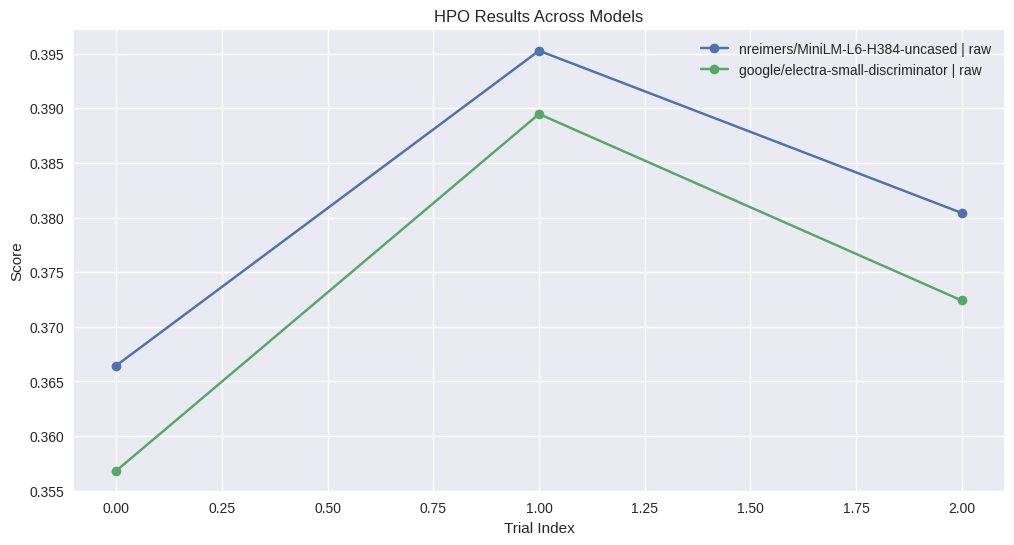


📈 Plotting training curves for nreimers/MiniLM-L6-H384-uncased | raw
  ⚠ trainer_state.json missing
⚠ Missing full/quantized metrics for nreimers/MiniLM-L6-H384-uncased (raw)

📘 EXPERIMENT SUMMARY TABLE:


,Model,Mode,Best HPO Trial,Best HPO Score,Trained?,Trained Path,Quantized?,Quantized Score,Quantized Path
0,nreimers/MiniLM-L6-H384-uncased,raw,1,0.395270,True,/content/drive/MyDrive/emotion_project/full/fi...,True,0.38793,/content/drive/MyDrive/emotion_project/full/fi...
1,google/electra-small-discriminator,raw,1,0.389481,False,None,False,NaN,None


📁 Saved summary table to: /content/drive/MyDrive/emotion_project/full/final_models/plots/experiment_summary.csv


In [32]:
# ============================================================
# UNIVERSAL EXPERIMENT DASHBOARD
#   ✔ Summary table (Pandas dataframe)
#   ✔ Saving all plots to Drive
#   ✔ Robusztus metric-kezelés (eval_ prefix + fallback)
# ============================================================

if GENERATE_FINAL_REPORT and not SMOKE_TEST:

  import json
  import matplotlib.pyplot as plt
  import pandas as pd
  from glob import glob

  PLOTS_DIR = os.path.join(FINAL_DIR, "plots")
  os.makedirs(PLOTS_DIR, exist_ok=True)

  def savefig(name):
      """Helper to save current plot to Drive."""
      path = os.path.join(PLOTS_DIR, name)
      plt.savefig(path, bbox_inches="tight", dpi=200)
      print(f"📁 Saved plot: {path}")


  # ------------------------------------------------------------
  # Helpers
  # ------------------------------------------------------------
  def try_load_json(path):
      if not os.path.exists(path):
          return None
      with open(path, "r") as f:
          return json.load(f)

  def get_metric(metrics_dict, metric_name):
      """
      Robusztus metrika-olvasó:
      - először próbálja a 'metric_name' kulcsot
      - ha nincs, akkor 'eval_metric_name'
      """
      if not metrics_dict:
          return None
      if metric_name in metrics_dict:
          return metrics_dict[metric_name]
      eval_key = f"eval_{metric_name}"
      if eval_key in metrics_dict:
          return metrics_dict[eval_key]
      return None

  def find_hpo_results():
      results = {}
      for model_cfg in BASE_MODELS:
          name = model_cfg["name"]
          key = name.replace("/", "_")
          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              trial_root = os.path.join(TRIALS_DIR, f"{key}_{mode}")
              if not os.path.exists(trial_root):
                  continue
              trial_jsons = sorted(glob(os.path.join(trial_root, "trial_*/metrics.json")))
              trials = [try_load_json(p) for p in trial_jsons if try_load_json(p)]
              if trials:
                  results[(name, mode)] = trials
      return results

  def find_trained_models():
      trained = []
      for model_cfg in BASE_MODELS:
          name = model_cfg["name"]
          key = name.replace("/", "_")
          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              p = os.path.join(FINAL_DIR, f"{key}_{mode}_final_trained")
              if os.path.exists(p):
                  trained.append((name, mode, p))
      return trained

  def find_quantized_models():
      quant = []
      for model_cfg in BASE_MODELS:
          name = model_cfg["name"]
          key = name.replace("/", "_")
          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              p = os.path.join(FINAL_DIR, f"{key}_{mode}_quantized_final")
              if not os.path.exists(p):
                  continue
              summary = try_load_json(os.path.join(p, "quantization_summary.json"))
              quant.append((name, mode, p, summary))
      return quant


  # ============================================================
  # 1) PLOT HPO RESULTS (AND SAVE)
  # ============================================================

  hpo_results = find_hpo_results()

  if hpo_results:
      print(hpo_results)
      print("📊 Plotting HPO results...")

      plt.figure(figsize=(12, 6))

      for (model_name, mode), trials in hpo_results.items():
          metric = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"
          xs = [t.get("trial_index", i) for i, t in enumerate(trials)]
          ys = [
              get_metric(t.get("eval_metrics", {}), metric) or 0.0
              for t in trials
          ]
          plt.plot(xs, ys, marker="o", label=f"{model_name} | {mode}")

      plt.title("HPO Results Across Models")
      plt.xlabel("Trial Index")
      plt.ylabel("Score")
      plt.grid(True)
      plt.legend()
      savefig("hpo_results.png")
      plt.show()
  else:
      print("⚠ No HPO results found.")


  # ============================================================
  # 2) PLOT TRAINING CURVES (AND SAVE)
  # ============================================================

  trained_models = find_trained_models()

  for (model_name, mode, path) in trained_models:
      print(f"\n📈 Plotting training curves for {model_name} | {mode}")

      state_path = os.path.join(path, "trainer_state.json")
      state = try_load_json(state_path)

      if not state:
          print("  ⚠ trainer_state.json missing")
          continue

      logs = state.get("log_history", [])
      train_loss = [l["loss"] for l in logs if "loss" in l]
      eval_loss = [l["eval_loss"] for l in logs if "eval_loss" in l]

      # Training Loss
      if train_loss:
          plt.figure(figsize=(10, 4))
          plt.plot(train_loss)
          plt.title(f"Training Loss — {model_name} ({mode})")
          plt.xlabel("Step")
          plt.ylabel("Loss")
          plt.grid(True)
          name = f"training_loss_{model_name.replace('/', '_')}_{mode}.png"
          savefig(name)
          plt.show()

      # Eval Loss
      if eval_loss:
          plt.figure(figsize=(10, 4))
          plt.plot(eval_loss, marker="o")
          plt.title(f"Eval Loss — {model_name} ({mode})")
          plt.xlabel("Epoch")
          plt.ylabel("Eval Loss")
          plt.grid(True)
          name = f"eval_loss_{model_name.replace('/', '_')}_{mode}.png"
          savefig(name)
          plt.show()


  # ============================================================
  # 3) FULL vs QUANTIZED PERFORMANCE (AND SAVE)
  # ============================================================

  quantized_models = find_quantized_models()

  for (model_name, mode, p, summary) in quantized_models:
      if not summary or "quantized_metrics" not in summary:
          continue

      metric = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"
      q_val = get_metric(summary["quantized_metrics"], metric)

      # Load full model metric
      key = model_name.replace("/", "_")
      full_path = os.path.join(FINAL_DIR, f"{key}_{mode}_final_trained")
      trainer_state = try_load_json(os.path.join(full_path, "trainer_state.json"))

      full_val = None
      if trainer_state:
          eval_logs = [
              l for l in trainer_state.get("log_history", [])
              if f"eval_{metric}" in l
          ]
          if eval_logs:
              full_val = eval_logs[-1][f"eval_{metric}"]

      if full_val is None or q_val is None:
          print(f"⚠ Missing full/quantized metrics for {model_name} ({mode})")
          continue

      plt.figure(figsize=(6, 4))
      plt.bar(["Full", "Quantized"], [full_val, q_val])
      plt.title(f"{metric}: Full vs Quantized — {model_name} ({mode})")
      plt.ylabel(metric)
      plt.grid(axis="y")
      name = f"full_vs_quant_{model_name.replace('/', '_')}_{mode}.png"
      savefig(name)
      plt.show()


  # ============================================================
  # 4) SUMMARY TABLE
  # ============================================================

  rows = []
  for (model_name, mode), hpo_trials in hpo_results.items():
      metric = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"

      # best trial robusztus kiválasztása
      def trial_score(t):
          return get_metric(t.get("eval_metrics", {}), metric) or -1.0

      best_trial = max(hpo_trials, key=trial_score)

      # trained?
      trained_path = os.path.join(
          FINAL_DIR,
          f"{model_name.replace('/', '_')}_{mode}_final_trained"
      )
      is_trained = os.path.exists(trained_path)

      # quantized?
      quant_path = os.path.join(
          FINAL_DIR,
          f"{model_name.replace('/', '_')}_{mode}_quantized_final"
      )
      quant_summary = try_load_json(os.path.join(quant_path, "quantization_summary.json"))

      quant_score = None
      if quant_summary and "quantized_metrics" in quant_summary:
          quant_score = get_metric(quant_summary["quantized_metrics"], metric)

      rows.append({
          "Model": model_name,
          "Mode": mode,
          "Best HPO Trial": best_trial.get("trial_index"),
          "Best HPO Score": trial_score(best_trial),
          "Trained?": is_trained,
          "Trained Path": trained_path if is_trained else None,
          "Quantized?": quant_summary is not None,
          "Quantized Score": quant_score,
          "Quantized Path": quant_path if quant_summary else None,
      })

  df_summary = pd.DataFrame(rows)
  print("\n📘 EXPERIMENT SUMMARY TABLE:")
  display(df_summary)

  # Save summary table
  df_summary.to_csv(os.path.join(PLOTS_DIR, "experiment_summary.csv"), index=False)
  print(f"📁 Saved summary table to: {os.path.join(PLOTS_DIR, 'experiment_summary.csv')}")


In [ ]:
# ============================================================
# FINAL REPORT GENERATOR → PDF
# Output:
#   /content/drive/MyDrive/emotion_project/final_report/final_report.pdf
# ============================================================

if GENERATE_FINAL_REPORT and not SMOKE_TEST:
  !pip install -q reportlab

  import os
  import json
  import datetime
  from glob import glob

  import pandas as pd
  from reportlab.lib.pagesizes import A4
  from reportlab.platypus import (
      SimpleDocTemplate,
      Paragraph,
      Spacer,
      Table,
      TableStyle,
      PageBreak,
  )
  from reportlab.lib.styles import getSampleStyleSheet
  from reportlab.lib import colors

  # -----------------------------
  # Paths
  # -----------------------------
  REPORT_DIR = os.path.join(PROJECT_ROOT, "final_report")
  os.makedirs(REPORT_DIR, exist_ok=True)

  REPORT_PDF = os.path.join(REPORT_DIR, "final_report.pdf")

  print("Report directory:", REPORT_DIR)
  print("Report PDF will be saved to:", REPORT_PDF)


  # -----------------------------
  # Helper functions (reuse logic from dashboard, de lokálisan)
  # -----------------------------
  def try_load_json(path):
      if not os.path.exists(path):
          return None
      with open(path, "r") as f:
          return json.load(f)

  def get_metric(metrics_dict, metric_name):
      """
      Robusztus metrika-olvasó:
      - először próbálja a 'metric_name' kulcsot
      - ha nincs, akkor 'eval_metric_name'
      """
      if not metrics_dict:
          return None
      if metric_name in metrics_dict:
          return metrics_dict[metric_name]
      eval_key = f"eval_{metric_name}"
      if eval_key in metrics_dict:
          return metrics_dict[eval_key]
      return None


  def find_hpo_results():
      results = {}
      for model_cfg in BASE_MODELS:
          name = model_cfg["name"]
          key = name.replace("/", "_")
          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              trial_root = os.path.join(TRIALS_DIR, f"{key}_{mode}")
              if not os.path.exists(trial_root):
                  continue
              trial_jsons = sorted(glob(os.path.join(trial_root, "trial_*/metrics.json")))
              trials = [try_load_json(p) for p in trial_jsons if try_load_json(p)]
              if trials:
                  results[(name, mode)] = trials
      return results


  def find_trained_models():
      trained = []
      for model_cfg in BASE_MODELS:
          name = model_cfg["name"]
          key = name.replace("/", "_")
          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              p = os.path.join(FINAL_DIR, f"{key}_{mode}_final_trained")
              if os.path.exists(p):
                  trained.append((name, mode, p))
      return trained


  def find_quantized_models():
      quant = []
      for model_cfg in BASE_MODELS:
          name = model_cfg["name"]
          key = name.replace("/", "_")
          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              p = os.path.join(FINAL_DIR, f"{key}_{mode}_quantized_final")
              if not os.path.exists(p):
                  continue
              summary = try_load_json(os.path.join(p, "quantization_summary.json"))
              quant.append((name, mode, p, summary))
      return quant


  # -----------------------------
  # Collect experiment artifacts
  # -----------------------------
  hpo_results = find_hpo_results()
  trained_models = find_trained_models()
  quantized_models = find_quantized_models()

  print(f"HPO result sets: {len(hpo_results)}")
  print(f"Trained models: {len(trained_models)}")
  print(f"Quantized models: {len(quantized_models)}")

  # Build a summary dataframe similar to the dashboard
  summary_rows = []
  for (model_name, mode), hpo_trials in hpo_results.items():
      metric = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"

      def trial_score(t):
          return get_metric(t.get("eval_metrics", {}), metric) or -1.0

      best_trial = max(
          hpo_trials,
          key=trial_score,
      )

      key = model_name.replace("/", "_")
      trained_path = os.path.join(FINAL_DIR, f"{key}_{mode}_final_trained")
      is_trained = os.path.exists(trained_path)

      quant_path = os.path.join(FINAL_DIR, f"{key}_{mode}_quantized_final")
      quant_summary = try_load_json(os.path.join(quant_path, "quantization_summary.json"))

      quant_score = None
      if quant_summary and "quantized_metrics" in quant_summary:
          quant_score = get_metric(quant_summary["quantized_metrics"], metric)

      summary_rows.append(
          {
              "Model": model_name,
              "Mode": mode,
              "Best HPO Trial": best_trial.get("trial_index"),
              "Best HPO Score": trial_score(best_trial),
              "Trained?": is_trained,
              "Trained Path": trained_path if is_trained else None,
              "Quantized?": quant_summary is not None,
              "Quantized Score": quant_score,
              "Quantized Path": quant_path if quant_summary else None,
          }
      )

  df_summary = pd.DataFrame(summary_rows) if summary_rows else pd.DataFrame()
  summary_csv_path = os.path.join(REPORT_DIR, "experiment_summary_for_report.csv")
  df_summary.to_csv(summary_csv_path, index=False)
  print("Saved summary CSV for report:", summary_csv_path)


  # -----------------------------
  # Build PDF document
  # -----------------------------
  styles = getSampleStyleSheet()
  style_title = styles["Title"]
  style_h1 = styles["Heading1"]
  style_h2 = styles["Heading2"]
  style_body = styles["BodyText"]

  story = []

  # ========== TITLE PAGE ==========
  title = "Lightweight Emotion Detection from Text — Final Report"
  today = datetime.date.today().strftime("%Y-%m-%d")

  story.append(Paragraph(title, style_title))
  story.append(Spacer(1, 24))
  story.append(Paragraph("Team: (to be filled in)", style_body))
  story.append(Paragraph(f"Date: {today}", style_body))
  story.append(Spacer(1, 40))

  model_names_str = ", ".join(sorted({cfg["name"] for cfg in BASE_MODELS}))
  story.append(Paragraph(f"Models considered: {model_names_str}", style_body))
  story.append(PageBreak())


  # ========== 1. OVERVIEW ==========
  story.append(Paragraph("1. Overview", style_h1))
  overview_text = """
  This report summarizes our experiments on lightweight emotion detection from text,
  using the GoEmotions dataset in two configurations: RAW (multi-label) and SIMPLIFIED
  (single-label). The main goals were:

  • to compare several compact transformer models on this task,
  • to incorporate a Plutchik-distance–aware evaluation instead of plain F1,
  • to explore a simple manual hyperparameter search (HPO) grid,
  • and to study the impact of INT8 quantization on model performance and size.
  """
  for line in overview_text.strip().split("\n"):
      story.append(Paragraph(line.strip(), style_body))
  story.append(Spacer(1, 12))


  # ========== 2. DATA & LABELLING ==========
  story.append(Paragraph("2. Data and Labelling Schemes", style_h1))

  raw_text = """
  RAW configuration:
  The RAW GoEmotions configuration is treated as a multi-label problem with 27 active emotion
  labels plus 'neutral'. Each text can have multiple emotions simultaneously, represented as
  a 28-dimensional multi-hot vector. We use a BCEWithLogitsLoss with per-label pos_weight
  to account for class imbalance.
  """

  simp_text = """
  SIMPLIFIED configuration:
  The SIMPLIFIED configuration provided by the dataset authors maps each example to a single
  dominant emotion label using a fixed priority rule over the annotations. This turns the problem
  into a single-label classification task with 28 emotion classes. For this setting we use a
  standard cross-entropy loss, optionally with class weights.
  """

  for t in (raw_text, simp_text):
      for line in t.strip().split("\n"):
          story.append(Paragraph(line.strip(), style_body))
      story.append(Spacer(1, 6))

  plutchik_text = """
  Plutchik-aware evaluation:
  Following your suggestion, we incorporate Plutchik's wheel-of-emotions as a simple distance
  model between emotions. For the RAW setting, we define a Plutchik-aware F1 score that gives
  partial credit when predicted emotions share the same Plutchik primary category as the true
  labels. For the SIMPLIFIED setting, we use a soft accuracy that awards 1.0 for exact matches,
  0.5 for same primary category, and 0.25 when one of the emotions is 'neutral'.
  """

  for line in plutchik_text.strip().split("\n"):
      story.append(Paragraph(line.strip(), style_body))
  story.append(Spacer(1, 12))


  # ========== 3. MODELS & TRAINING ==========
  story.append(Paragraph("3. Models and Training Setup", style_h1))

  models_text = """
  Models:
  We focus on three lightweight transformer-based encoders:

  • nreimers/MiniLM-L6-H384-uncased
  • google/electra-small-discriminator
  • roberta-base

  All models are fine-tuned for emotion detection using our custom WeightedTrainer. For the
  RAW (multi-label) setting we use BCEWithLogitsLoss with pos_weight; for the SIMPLIFIED
  setting, cross-entropy with optional class weights. A global seed is used for reproducibility.
  """

  for line in models_text.strip().split("\n"):
      story.append(Paragraph(line.strip(), style_body))
  story.append(Spacer(1, 6))

  hpo_text = """
  Manual HPO:
  Instead of a black-box hyperparameter search, we use a small manually designed grid of
  three configurations (learning rate, warmup ratio, weight decay, scheduler type, batch size,
  and max sequence length). For each model we only run HPO on the RAW configuration.
  For the SIMPLIFIED setting we simply reuse the best RAW hyperparameters, to save
  computation and to keep the comparison consistent.
  """

  for line in hpo_text.strip().split("\n"):
      story.append(Paragraph(line.strip(), style_body))
  story.append(Spacer(1, 12))


  # ========== 4. HPO RESULTS ==========
  story.append(Paragraph("4. Hyperparameter Optimization Results", style_h1))

  if df_summary.empty:
      story.append(Paragraph("No HPO results found yet in TRIALS_DIR.", style_body))
  else:
      story.append(
          Paragraph(
              "Table 1: Best HPO result per model and configuration "
              "(Plutchik-aware score).",
              style_h2,
          )
      )
      story.append(Spacer(1, 6))

      table_data = [
          [
              "Model",
              "Mode",
              "Best HPO Trial",
              "Best HPO Score",
              "Trained?",
              "Quantized?",
          ]
      ]

      for _, row in df_summary.iterrows():
          best_score = row["Best HPO Score"]
          table_data.append(
              [
                  str(row["Model"]),
                  str(row["Mode"]),
                  int(row["Best HPO Trial"]) if pd.notna(row["Best HPO Trial"]) else "N/A",
                  f"{best_score:.4f}" if pd.notna(best_score) else "N/A",
                  "Yes" if row["Trained?"] else "No",
                  "Yes" if row["Quantized?"] else "No",
              ]
          )

      table = Table(table_data, hAlign="LEFT")
      table.setStyle(
          TableStyle(
              [
                  ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
                  ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
                  ("ALIGN", (0, 0), (-1, -1), "CENTER"),
                  ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
              ]
          )
      )
      story.append(table)

  story.append(Spacer(1, 12))


  # ========== 5. FINAL TRAINING & PERFORMANCE ==========
  story.append(Paragraph("5. Final Training and Model Performance", style_h1))

  if not trained_models:
      story.append(
          Paragraph(
              "Final training has not been run yet (no *_final_trained directories found).",
              style_body,
          )
      )
  else:
      text = """
  For each model with available HPO results we perform a final training run using the best
  RAW hyperparameters. For the SIMPLIFIED setting we reuse the same hyperparameters.
  Performance is evaluated both with the standard metric (micro F1 / accuracy) and our
  Plutchik-aware metric.
  """
      for line in text.strip().split("\n"):
          story.append(Paragraph(line.strip(), style_body))
      story.append(Spacer(1, 6))

      story.append(
          Paragraph(
              "Training summaries (per model/mode) are stored next to the final trained "
              "models and can be inspected for detailed metrics and learning curves.",
              style_body,
          )
      )

  story.append(Spacer(1, 12))


  # ========== 6. QUANTIZATION ==========
  story.append(Paragraph("6. Quantization (FP32 vs INT8)", style_h1))

  if not quantized_models:
      story.append(
          Paragraph(
              "No quantized models found yet (no *_quantized_final directories with "
              "quantization_summary.json).",
              style_body,
          )
      )
  else:
      text = """
  We apply PyTorch dynamic quantization to the best final models, targeting Linear layers
  and converting them to INT8 where possible. When quantization fails, we fall back to
  exporting the FP32 weights. For each quantized model we re-evaluate the Plutchik-aware
  metric to measure the accuracy drop.
  """
      for line in text.strip().split("\n"):
          story.append(Paragraph(line.strip(), style_body))
      story.append(Spacer(1, 6))

      story.append(Paragraph("Table 2: Quantization summary.", style_h2))
      story.append(Spacer(1, 6))

      q_table_data = [
          ["Model", "Mode", "Quantization OK?", "Quantized Score (Plutchik)"]
      ]

      for (model_name, mode, p, summary) in quantized_models:
          if not summary or "quantized_metrics" not in summary:
              continue
          metric = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"
          q_val = get_metric(summary["quantized_metrics"], metric)
          q_table_data.append(
              [
                  model_name,
                  mode,
                  "Yes" if summary.get("quantized_success") else "No",
                  f"{q_val:.4f}" if q_val is not None else "N/A",
              ]
          )

      if len(q_table_data) > 1:
          q_table = Table(q_table_data, hAlign="LEFT")
          q_table.setStyle(
              TableStyle(
                  [
                      ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
                      ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
                      ("ALIGN", (0, 0), (-1, -1), "CENTER"),
                      ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
                  ]
              )
          )
          story.append(q_table)
      else:
          story.append(Paragraph("No detailed quantization summaries found.", style_body))

  story.append(Spacer(1, 12))


  # ========== 7. RAW vs SIMPLIFIED & MODEL DIFFERENCES ==========
  story.append(
      Paragraph("7. RAW vs SIMPLIFIED, and Model Differences", style_h1)
  )

  text_reason = """
  Difference between best models for RAW and SIMPLIFIED:
  In the RAW multi-label setting, the models are optimized to detect possibly several emotions
  per example. This tends to favour architectures that handle label co-occurrence patterns
  well and make use of the pos_weight vector. In the SIMPLIFIED single-label setup, the task
  is closer to standard multi-class classification, and the priority-based label selection
  can emphasise different parts of the label space. As a result, the relative ranking of
  models can differ between RAW and SIMPLIFIED.
  """

  for line in text_reason.strip().split("\n"):
      story.append(Paragraph(line.strip(), style_body))
  story.append(Spacer(1, 12))


  # ========== 8. PERFORMANCE INTERPRETATION ==========
  story.append(Paragraph("8. Performance Interpretation", style_h1))

  perf_text = """
  The raw F1 scores in earlier versions of the report were in the 0.47 range, which is modest
  for a classification task. However, this is partly due to the multi-label nature of emotions:
  expecting exact label-set matches is very strict. With the Plutchik-aware metrics we can
  distinguish between 'close' and 'far' mistakes (e.g., confusing joy with optimism vs joy
  with disgust), which gives a more informative picture of model behaviour.

  We also plan to inspect the main contributors to false positives and false negatives per label
  (e.g., which emotions are systematically over-predicted or under-predicted) and to include
  a small set of representative error examples in the final written report.
  """

  for line in perf_text.strip().split("\n"):
      story.append(Paragraph(line.strip(), style_body))

  story.append(Spacer(1, 12))


  # ========== 9. COMPUTATIONAL CONSIDERATIONS ==========
  story.append(Paragraph("9. Computational Considerations", style_h1))

  comp_text = """
  All experiments are run on Google Colab GPUs, which limits how many models and configurations
  we can train in one notebook run. For this reason, we:

  • run manual HPO only on the RAW configuration,
  • reuse the best RAW hyperparameters for the SIMPLIFIED setting,
  • train and quantize models one-by-one by toggling flags at the top of the notebook.

  We kept a global random seed and a fixed train/validation split to make results as
  reproducible as possible given these constraints.
  """

  for line in comp_text.strip().split("\n"):
      story.append(Paragraph(line.strip(), style_body))

  story.append(PageBreak())


  # ========== 10. APPENDIX: SUMMARY TABLE ==========
  story.append(Paragraph("10. Appendix: Experiment Summary Table", style_h1))

  if df_summary.empty:
      story.append(
          Paragraph(
              "No summary rows available yet. Please run HPO and training first.",
              style_body,
          )
      )
  else:
      story.append(
          Paragraph(
              f"Full summary also saved as CSV at: {summary_csv_path}", style_body
          )
      )
      story.append(Spacer(1, 6))

      # Render a small version of the summary table in the PDF (first N rows)
      max_rows = 15
      pdf_rows = min(len(df_summary), max_rows)
      story.append(
          Paragraph(
              f"Table 3: Overview of best HPO, training, and quantization status "
              f"for the first {pdf_rows} configurations.",
              style_h2,
          )
      )
      story.append(Spacer(1, 6))

      header = list(df_summary.columns)
      data = [header]
      for i in range(pdf_rows):
          row = df_summary.iloc[i]
          data.append([str(row[h]) for h in header])

      sum_table = Table(data, hAlign="LEFT")
      sum_table.setStyle(
          TableStyle(
              [
                  ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
                  ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
                  ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
                  ("ALIGN", (0, 0), (-1, -1), "LEFT"),
              ]
          )
      )
      story.append(sum_table)

  # -----------------------------
  # Build and save PDF
  # -----------------------------
  print("\nBuilding PDF report...")
  doc = SimpleDocTemplate(REPORT_PDF, pagesize=A4)
  doc.build(story)
  print("✅ Report written to:", REPORT_PDF)


### Enhanced Experiment Analysis and Reporting

This section incorporates additional analysis and visualization to provide a deeper understanding of the experimental results, addressing the suggestions discussed previously.

📊 Plotting HPO metrics vs. hyperparameters...


NameError: name 'savefig' is not defined

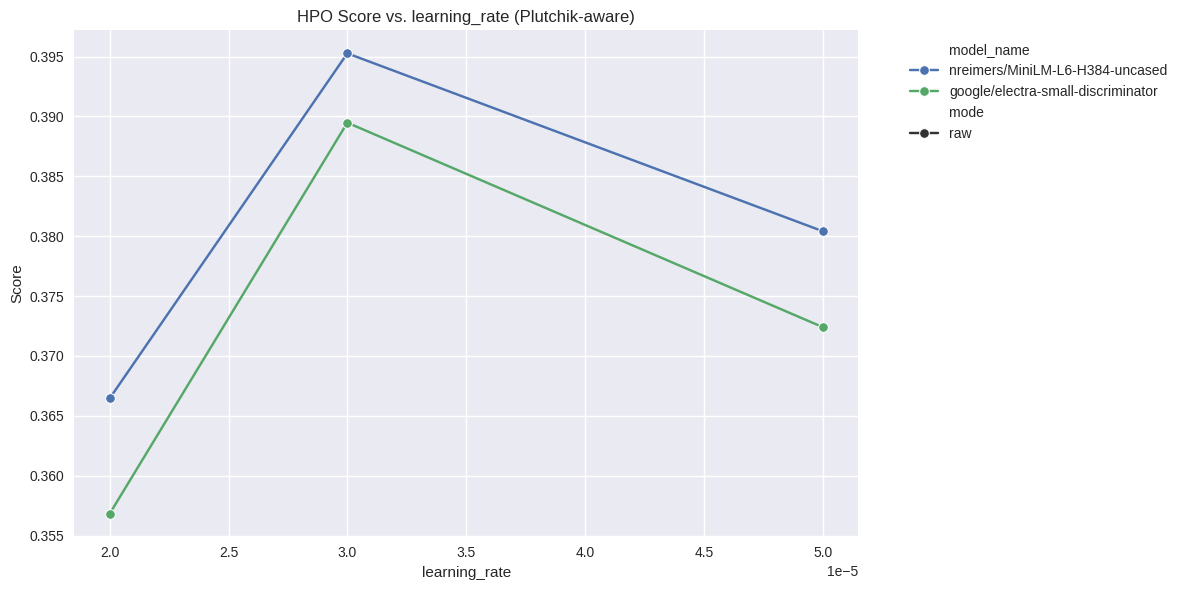

In [30]:
if not SMOKE_TEST:
  import matplotlib.pyplot as plt
  import pandas as pd
  import os
  import json
  from glob import glob
  import torch
  from transformers import AutoModelForSequenceClassification
  import seaborn as sns # Added seaborn import

  # Re-using helper functions defined earlier (if not already in scope in a fresh session)
  # For robustness, redefine them here if needed for independent execution of this block
  def try_load_json(path):
      if not os.path.exists(path):
          return None
      with open(path, "r", encoding="utf-8") as f:
          return json.load(f)

  def get_metric(metrics_dict, metric_name):
      if not metrics_dict:
          return None
      if metric_name in metrics_dict:
          return metrics_dict[metric_name]
      eval_key = f"eval_{metric_name}"
      if eval_key in metrics_dict:
          return metrics_dict[eval_key]
      return None

  def find_hpo_results():
      results = {}
      for model_cfg in BASE_MODELS:
          name = model_cfg["name"]
          key = name.replace("/", "_")
          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              trial_root = os.path.join(TRIALS_DIR, f"{key}_{mode}")
              if not os.path.exists(trial_root):
                  continue
              trial_jsons = sorted(glob(os.path.join(trial_root, "trial_*/metrics.json")))
              trials = [try_load_json(p) for p in trial_jsons if try_load_json(p)]
              if trials:
                  results[(name, mode)] = trials
      return results

  hpo_results = find_hpo_results()

  # ============================================================
  # 1. Enhanced HPO Analysis: Plotting Metric vs. Hyperparameter
  # ============================================================

  print("📊 Plotting HPO metrics vs. hyperparameters...")

  hpo_data_for_df = []
  for (model_name, mode), trials in hpo_results.items():
      metric_key = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"
      for t in trials:
          hpo_config = t.get("hpo_config", {})
          eval_metrics = t.get("eval_metrics", {})
          score = get_metric(eval_metrics, metric_key)
          if score is not None:
              row = {
                  "model_name": model_name,
                  "mode": mode,
                  "score": score,
                  "trial_index": t.get("trial_index"),
              }
              row.update(hpo_config)
              hpo_data_for_df.append(row)

  if hpo_data_for_df:
      df_hpo_detailed = pd.DataFrame(hpo_data_for_df)

      # Select a few key hyperparameters to plot
      params_to_plot = ["learning_rate", "batch_size", "max_length", "optimizer"]

      for param in params_to_plot:
          if param in df_hpo_detailed.columns:
              plt.figure(figsize=(12, 6))
              sns.lineplot(
                  data=df_hpo_detailed,
                  x=param,
                  y="score",
                  hue="model_name",
                  style="mode",
                  marker="o",
                  err_style="bars",
                  errorbar=("se", 2),
              )
              plt.title(f"HPO Score vs. {param} (Plutchik-aware)")
              plt.xlabel(param)
              plt.ylabel("Score")
              plt.grid(True)
              plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
              plt.tight_layout()
              savefig(f"hpo_score_vs_{param}.png")
              plt.show()
          else:
              print(f"Warning: Hyperparameter '{param}' not found in HPO results.")
  else:
      print("⚠ No detailed HPO results found for plotting hyperparameter impact.")


  # ============================================================
  # 2. Model Size Comparison (FP32 vs INT8)
  # ============================================================

  print("\n📏 Calculating and comparing model sizes...")

  def get_model_size_mb(model_path):
      # Calculate size of the pytorch_model.bin file
      model_bin_path = os.path.join(model_path, 'pytorch_model.bin')
      if os.path.exists(model_bin_path):
          return os.path.getsize(model_bin_path) / (1024 * 1024) # MB
      return None

  size_data = []
  for model_cfg in BASE_MODELS:
      model_name = model_cfg["name"]
      key = model_name.replace("/", "_")

      for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
          trained_path = os.path.join(FINAL_DIR, f"{key}_{mode}_final_trained")
          quantized_path = os.path.join(FINAL_DIR, f"{key}_{mode}_quantized_final")

          fp32_size = get_model_size_mb(trained_path)
          int8_size = get_model_size_mb(quantized_path)

          # Load quantization_summary to check if it was actually quantized
          quant_summary = try_load_json(os.path.join(quantized_path, "quantization_summary.json"))
          actually_quantized = quant_summary.get("quantized_success", False) if quant_summary else False

          if fp32_size:
              size_data.append({
                  "Model": model_name,
                  "Mode": mode,
                  "Type": "FP32",
                  "Size (MB)": fp32_size,
              })
          if int8_size:
              size_data.append({
                  "Model": model_name,
                  "Mode": mode,
                  "Type": "INT8" if actually_quantized else "FP32 (Fallback)",
                  "Size (MB)": int8_size,
              })

  if size_data:
      df_sizes = pd.DataFrame(size_data)
      print("\nModel Sizes Summary:")
      display(df_sizes)

      plt.figure(figsize=(12, 7))
      sns.barplot(
          data=df_sizes,
          x="Model",
          y="Size (MB)",
          hue="Type",
          palette="viridis",
          errorbar=None # No error bars for single size values
      )
      plt.title("Model Size Comparison (FP32 vs. Quantized INT8)")
      plt.xlabel("Model")
      plt.ylabel("Size (MB)")
      plt.xticks(rotation=45, ha='right')
      plt.grid(axis='y')
      plt.legend(title="Precision Type")
      plt.tight_layout()
      savefig("model_size_comparison.png")
      plt.show()
  else:
      print("⚠ No model size data found (models might not be trained/quantized yet).")


Available trained model directories:
 - /content/drive/MyDrive/emotion_project/full/final_models/nreimers_MiniLM-L6-H384-uncased_simplified_final_trained
 - /content/drive/MyDrive/emotion_project/full/final_models/nreimers_MiniLM-L6-H384-uncased_raw_final_trained

Using trainer_state from: /content/drive/MyDrive/emotion_project/full/final_models/nreimers_MiniLM-L6-H384-uncased_simplified_final_trained/checkpoint-8142/trainer_state.json


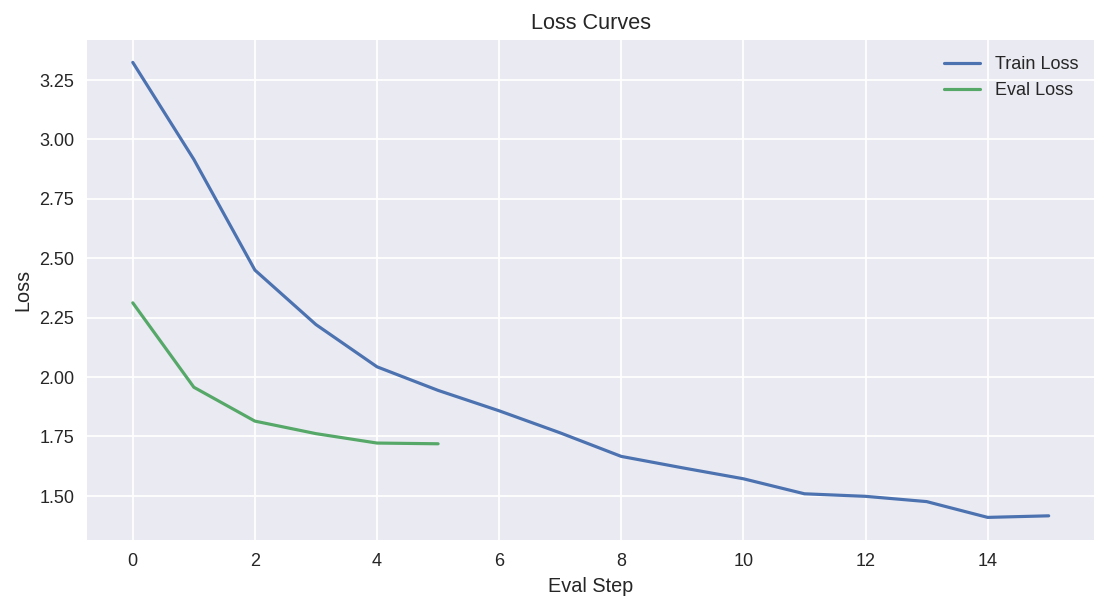

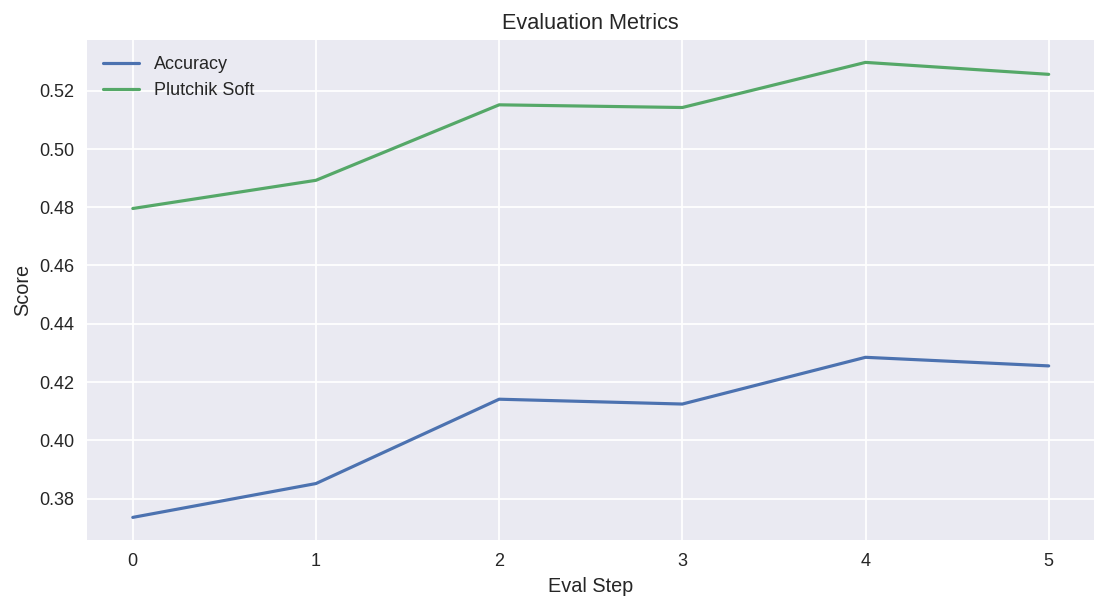

In [ ]:
if not SMOKE_TEST:
  import os
  import glob
  import json
  import matplotlib.pyplot as plt

  # 1) A FINAL_DIR értékét vedd át a notebookodból
  FINAL_DIR = FINAL_DIR  # itt NEM kell idézőjel, mert a notebookból veszi

  # 2) Válaszd ki melyik trained modelre csinálod a vizualizációt
  #    Pl.: "nreimers_MiniLM-L6-H384-uncased_raw_final_trained"
  #    A könyvtár neveket listázni fogjuk lentebb!
  trained_models = glob.glob(os.path.join(FINAL_DIR, "*_final_trained"))
  print("Available trained model directories:")
  for m in trained_models:
      print(" -", m)

  # --- ÁLLÍTSD BE ezt: ---
  model_dir = trained_models[0]   # vagy válaszd ki azt, amelyik érdekel

  # 3) Keresd meg az összes checkpointot
  checkpoints = glob.glob(os.path.join(model_dir, "checkpoint-*"))
  checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[-1]))

  if not checkpoints:
      raise ValueError("No checkpoints found!")

  latest = checkpoints[-1]
  state_path = os.path.join(latest, "trainer_state.json")

  print("\nUsing trainer_state from:", state_path)

  # 4) Load trainer_state.json
  with open(state_path, "r") as f:
      state = json.load(f)

  logs = state["log_history"]

  # 5) Extract metrics
  train_loss = []
  eval_loss = []
  acc = []
  psoft = []
  epochs = []

  for item in logs:
      if "loss" in item:
          train_loss.append(item["loss"])
      if "eval_loss" in item:
          eval_loss.append(item["eval_loss"])
      if "eval_accuracy" in item:
          acc.append(item["eval_accuracy"])
      if "eval_plutchik_soft" in item:
          psoft.append(item["eval_plutchik_soft"])

  # 6) Plot curves
  plt.figure(figsize=(10,5))
  plt.plot(train_loss, label="Train Loss")
  plt.plot(eval_loss, label="Eval Loss")
  plt.title("Loss Curves")
  plt.xlabel("Eval Step")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  plt.figure(figsize=(10,5))
  plt.plot(acc, label="Accuracy")
  plt.plot(psoft, label="Plutchik Soft")
  plt.title("Evaluation Metrics")
  plt.xlabel("Eval Step")
  plt.ylabel("Score")
  plt.legend()
  plt.show()


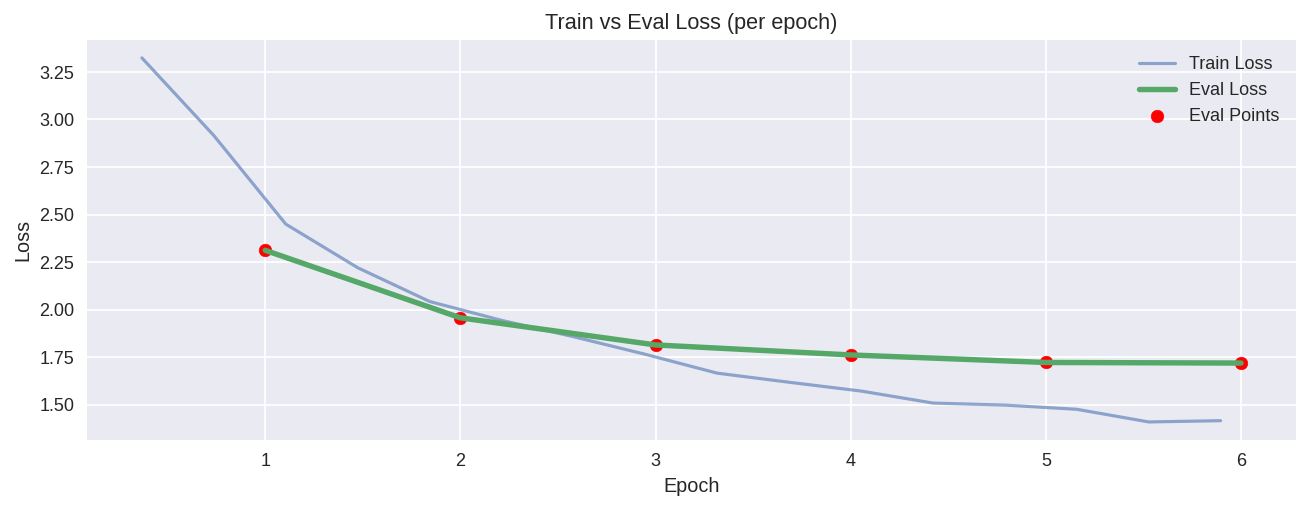

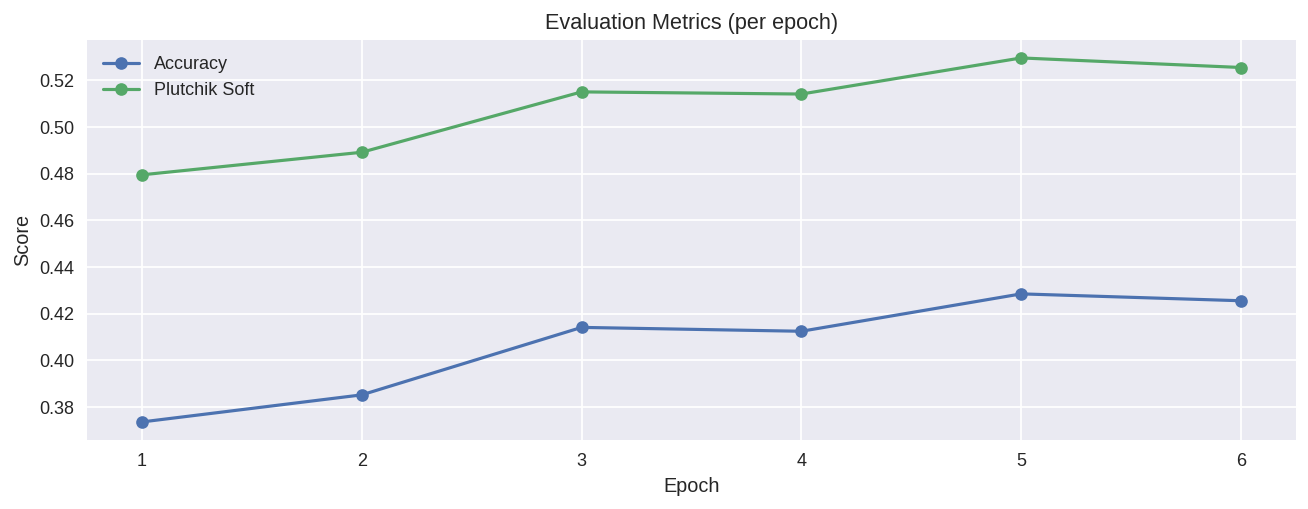

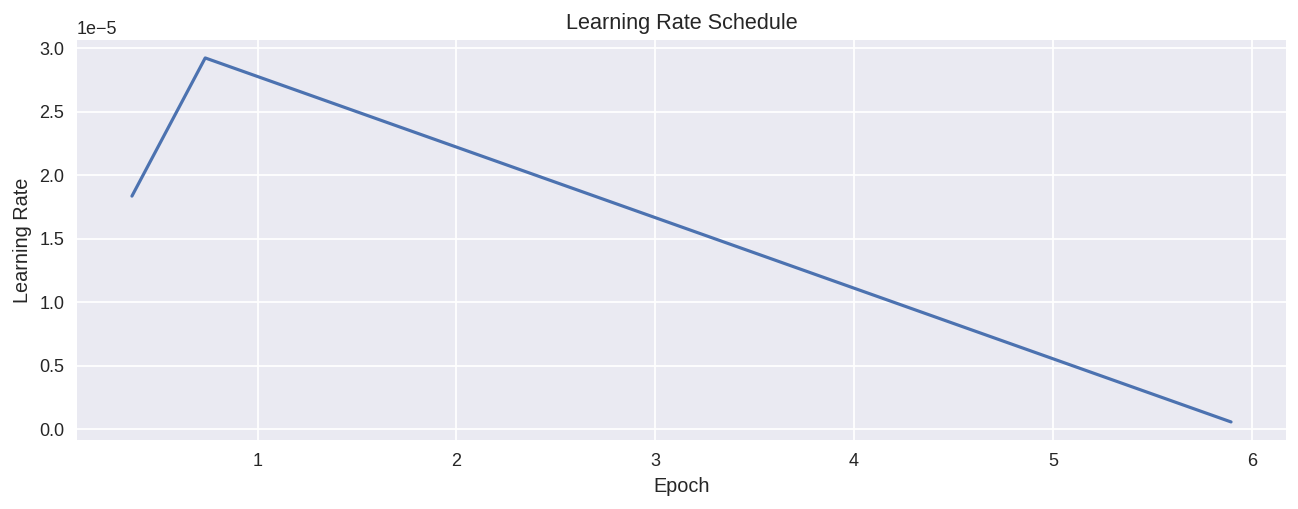


Best model checkpoint: /content/drive/MyDrive/emotion_project/full/final_models/nreimers_MiniLM-L6-H384-uncased_simplified_final_trained/checkpoint-8142
Best Plutchik score at epoch: 5.0


In [ ]:
if not SMOKE_TEST:
  import os
  import json
  import matplotlib.pyplot as plt
  import numpy as np

  # === LOAD TRAINER STATE ===
  latest = latest  # ha az előző cellában lefutott, ez már a helyes checkpoint
  state_path = os.path.join(latest, "trainer_state.json")

  with open(state_path, "r") as f:
      state = json.load(f)

  logs = state["log_history"]

  # === EXTRACT METRICS ===
  train_loss = []
  eval_loss = []
  accuracy = []
  plutchik = []
  epochs = []
  learning_rates = []

  for item in logs:
      if "loss" in item:
          train_loss.append((item["epoch"], item["loss"]))
      if "eval_loss" in item:
          eval_loss.append((item["epoch"], item["eval_loss"]))
      if "eval_accuracy" in item:
          accuracy.append((item["epoch"], item["eval_accuracy"]))
      if "eval_plutchik_soft" in item:
          plutchik.append((item["epoch"], item["eval_plutchik_soft"]))
      if "learning_rate" in item:
          learning_rates.append((item["epoch"], item["learning_rate"]))

  # Convert to arrays
  train_epochs, train_vals = zip(*train_loss)
  eval_epochs, eval_vals = zip(*eval_loss)
  acc_epochs, acc_vals = zip(*accuracy)
  psoft_epochs, psoft_vals = zip(*plutchik)
  lr_epochs, lr_vals = zip(*learning_rates)

  # === PLOT ===
  plt.figure(figsize=(12,4))
  plt.plot(train_epochs, train_vals, label="Train Loss", alpha=0.6)
  plt.plot(eval_epochs, eval_vals, label="Eval Loss", linewidth=3)
  plt.scatter(eval_epochs, eval_vals, color='red', label="Eval Points")
  plt.title("Train vs Eval Loss (per epoch)")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(12,4))
  plt.plot(acc_epochs, acc_vals, label="Accuracy", marker="o")
  plt.plot(psoft_epochs, psoft_vals, label="Plutchik Soft", marker="o")
  plt.title("Evaluation Metrics (per epoch)")
  plt.xlabel("Epoch")
  plt.ylabel("Score")
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(12,4))
  plt.plot(lr_epochs, lr_vals)
  plt.title("Learning Rate Schedule")
  plt.xlabel("Epoch")
  plt.ylabel("Learning Rate")
  plt.grid(True)
  plt.show()

  # === SHOW BEST CHECKPOINT INFO ===
  best_checkpoint = state["best_model_checkpoint"]
  print("\nBest model checkpoint:", best_checkpoint)

  best_epoch = None
  for ep, val in zip(psoft_epochs, psoft_vals):
      if abs(val - max(psoft_vals)) < 1e-6:
          best_epoch = ep
          break

  print(f"Best Plutchik score at epoch: {best_epoch:.1f}")


Using final model directory: /content/drive/MyDrive/emotion_project/full/final_models/nreimers_MiniLM-L6-H384-uncased_simplified_final_trained
Best checkpoint: /content/drive/MyDrive/emotion_project/full/final_models/nreimers_MiniLM-L6-H384-uncased_simplified_final_trained/checkpoint-8142
MODE: simplified
[CACHE] Loading tokenized dataset from /content/drive/MyDrive/emotion_project/full/tokenized/nreimers_MiniLM-L6-H384-uncased_simplified_len64


Eval:   0%|          | 0/5426 [00:00<?, ?it/s]/tmp/ipython-input-1678322432.py:81: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-1678322432.py:82: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

Eval: 100%|██████████| 5426/5426 [00:29<00:00, 184.27it/s]


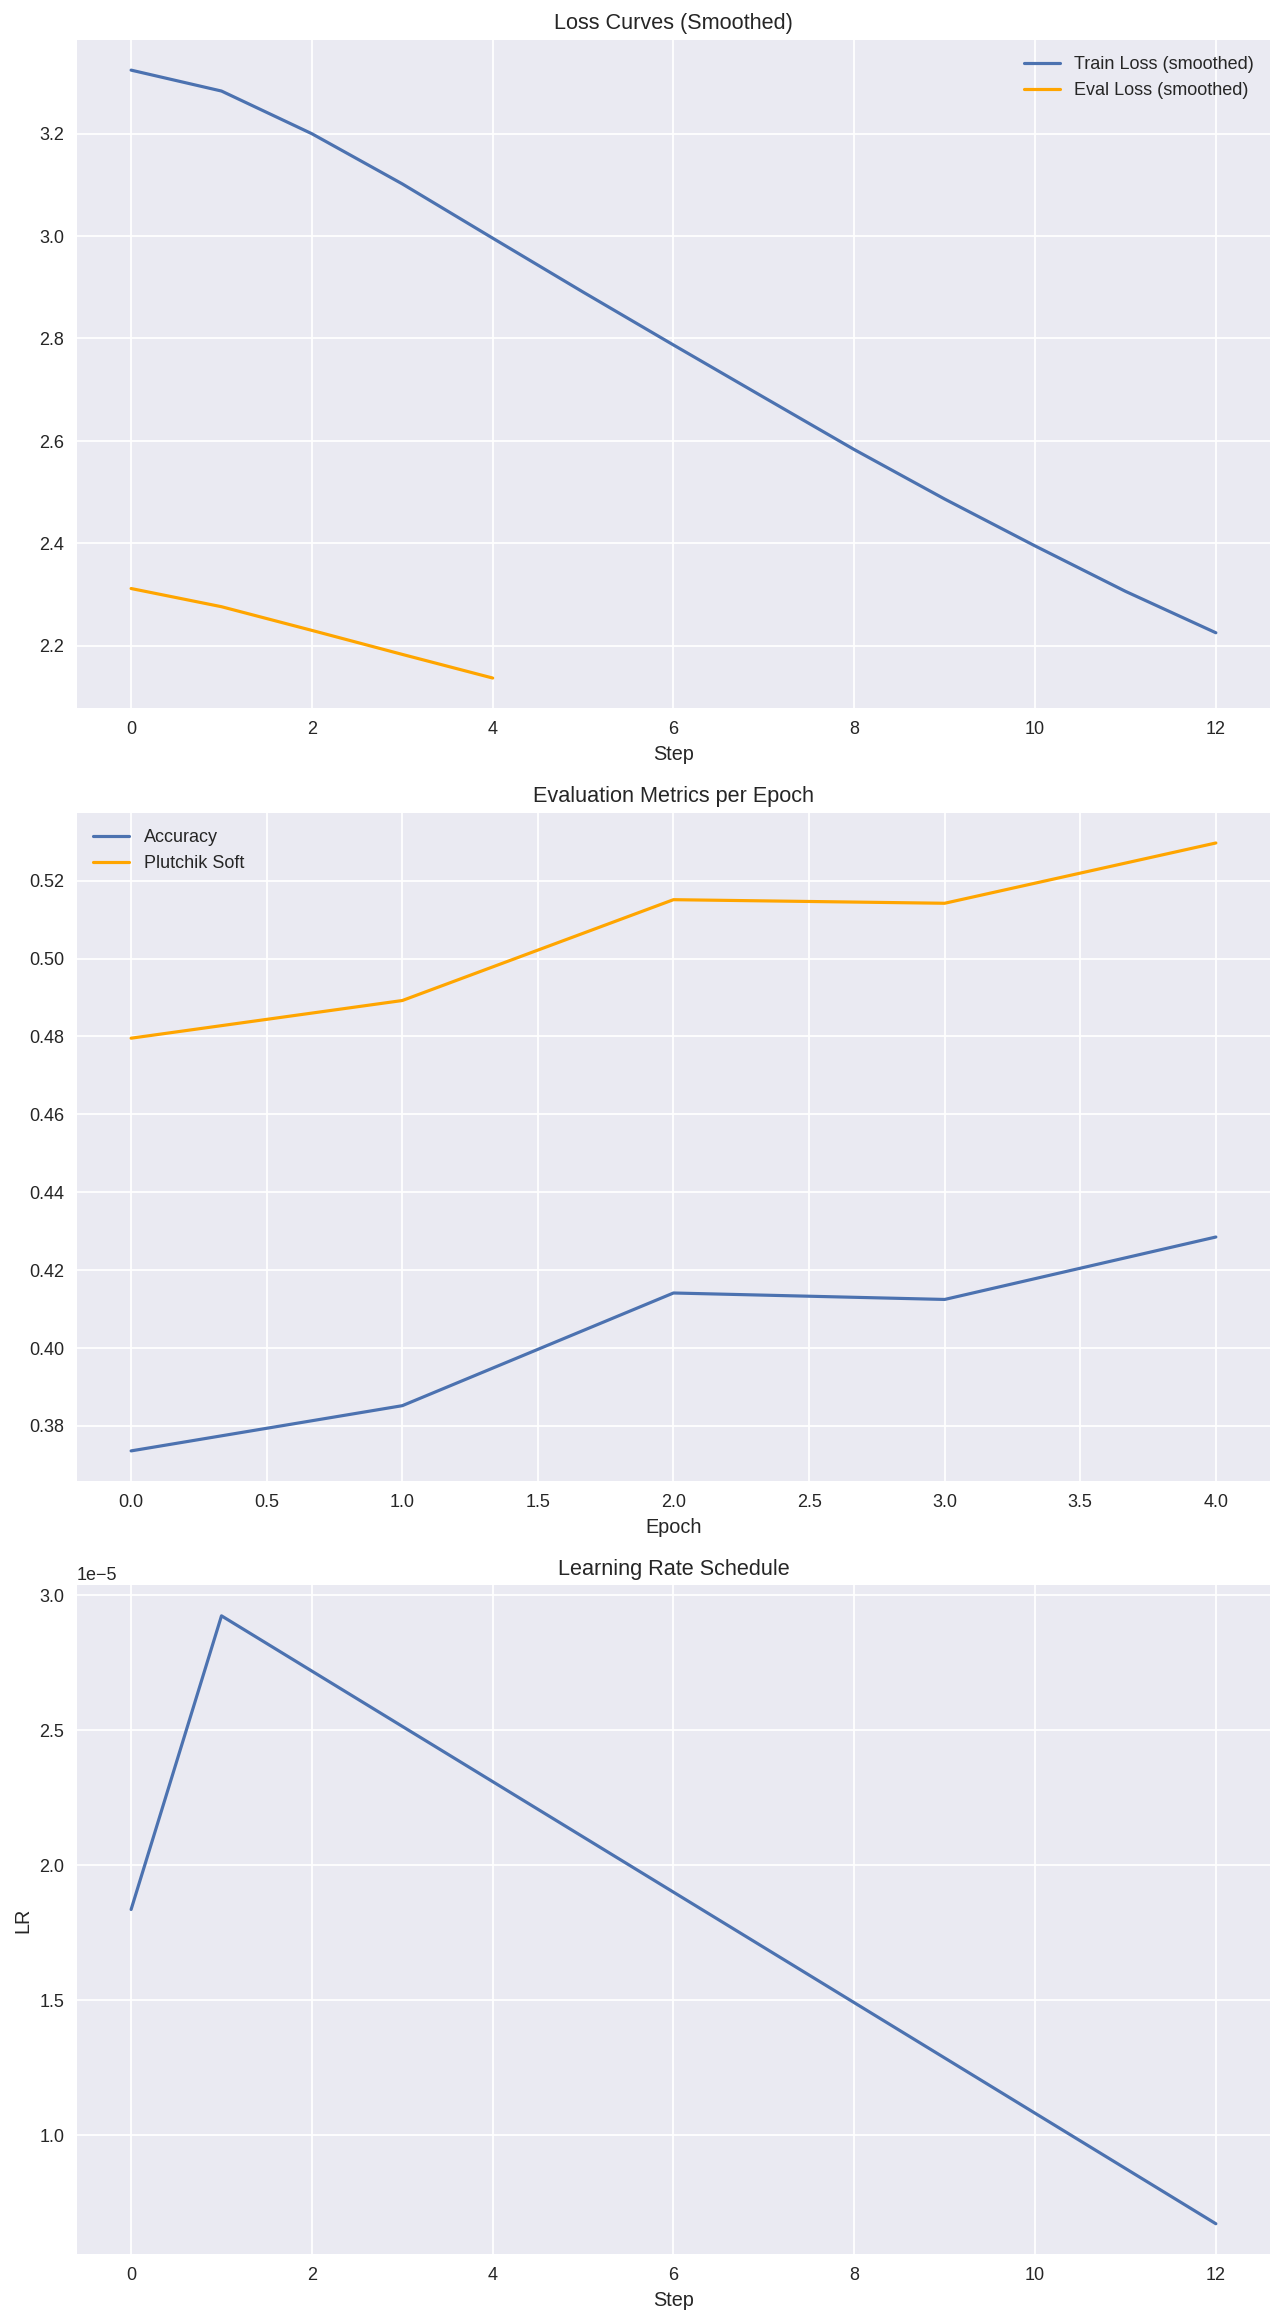

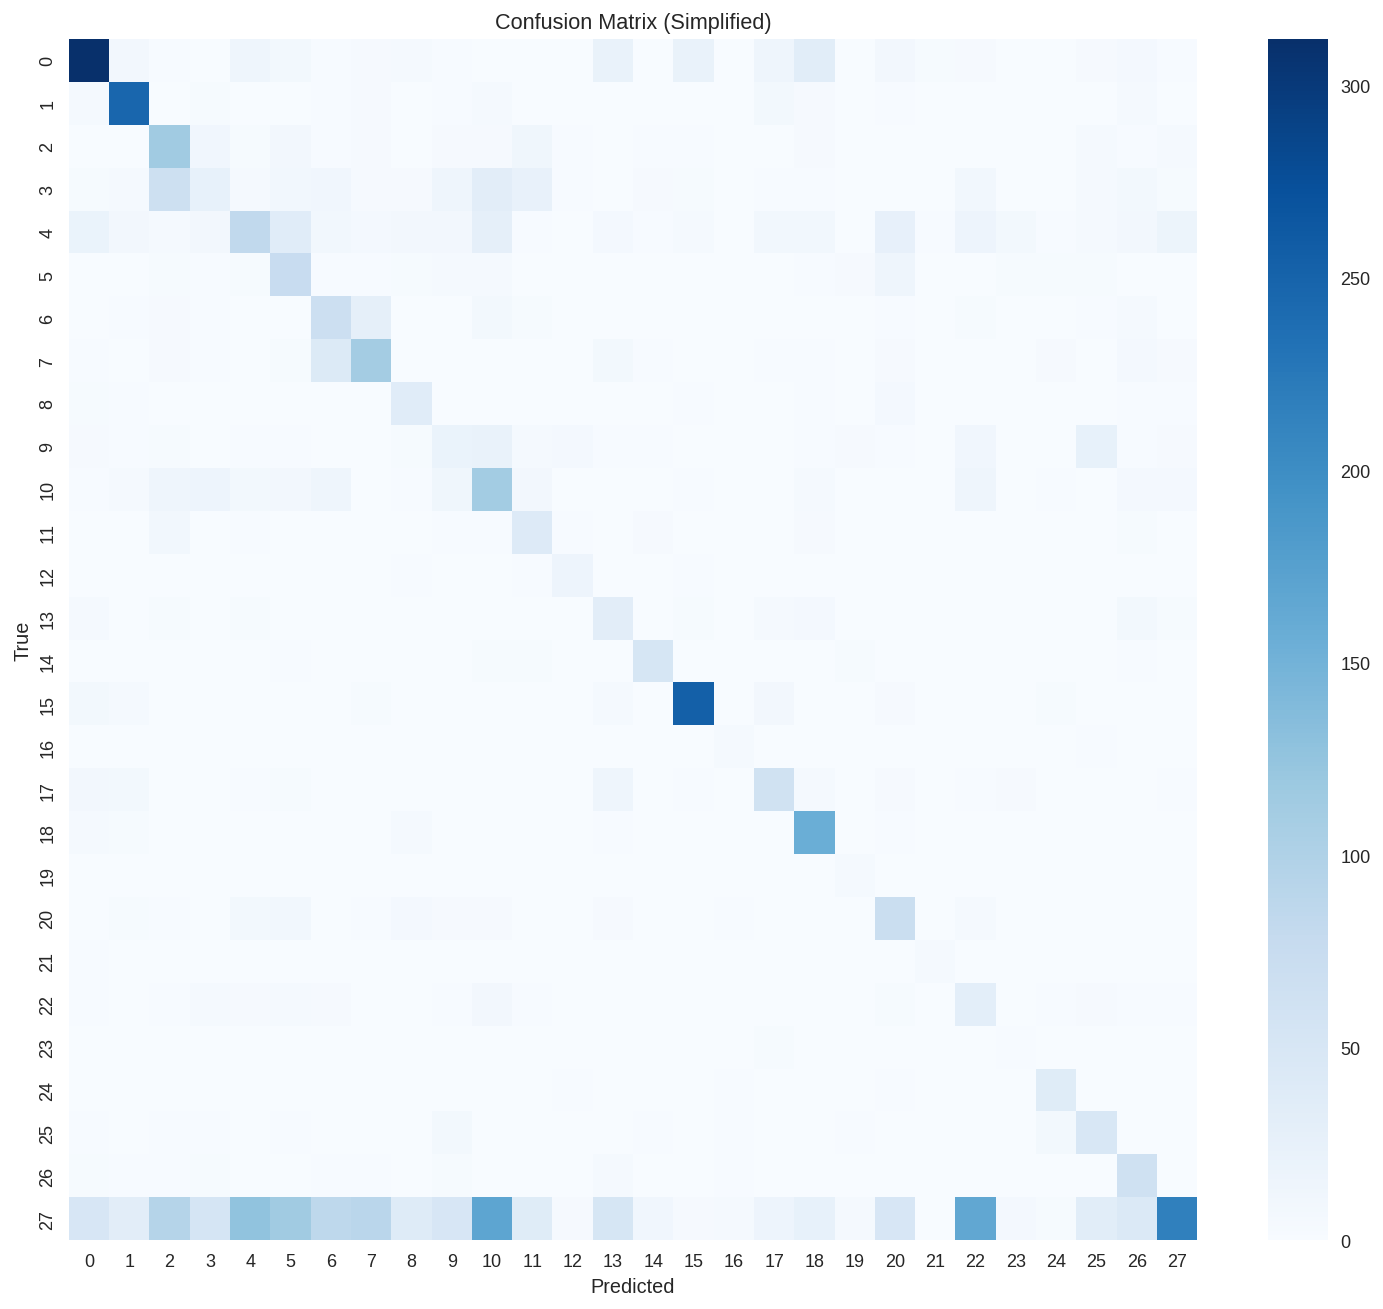

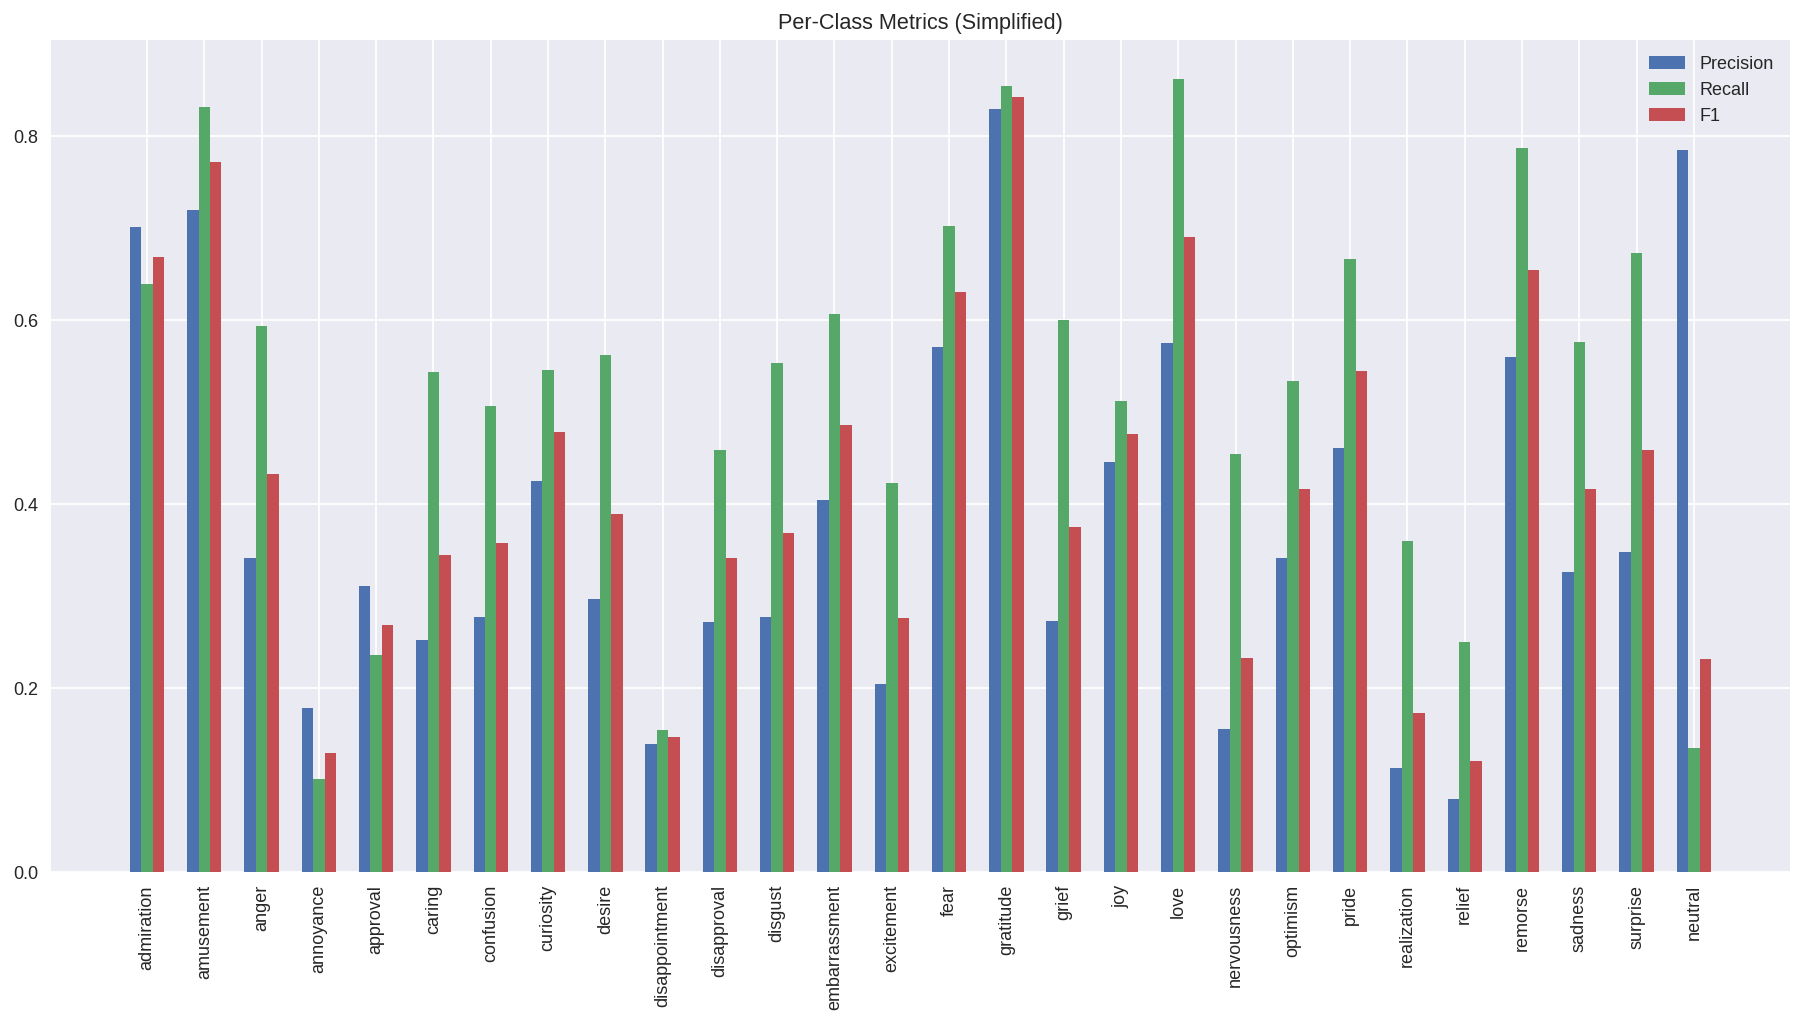

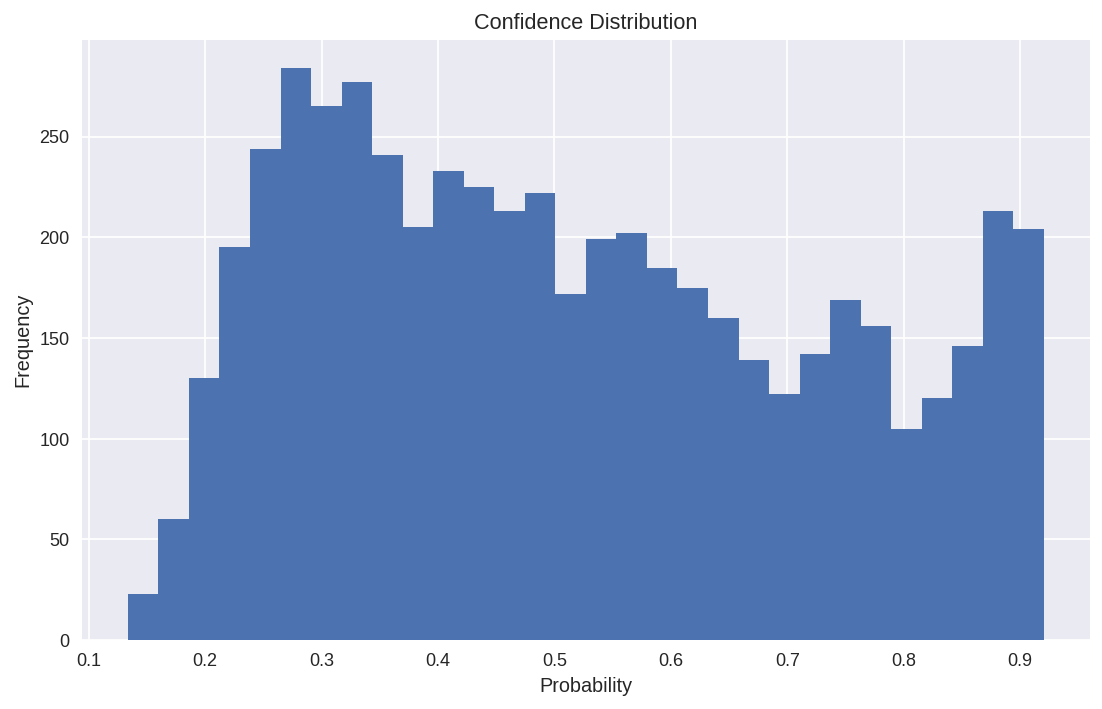

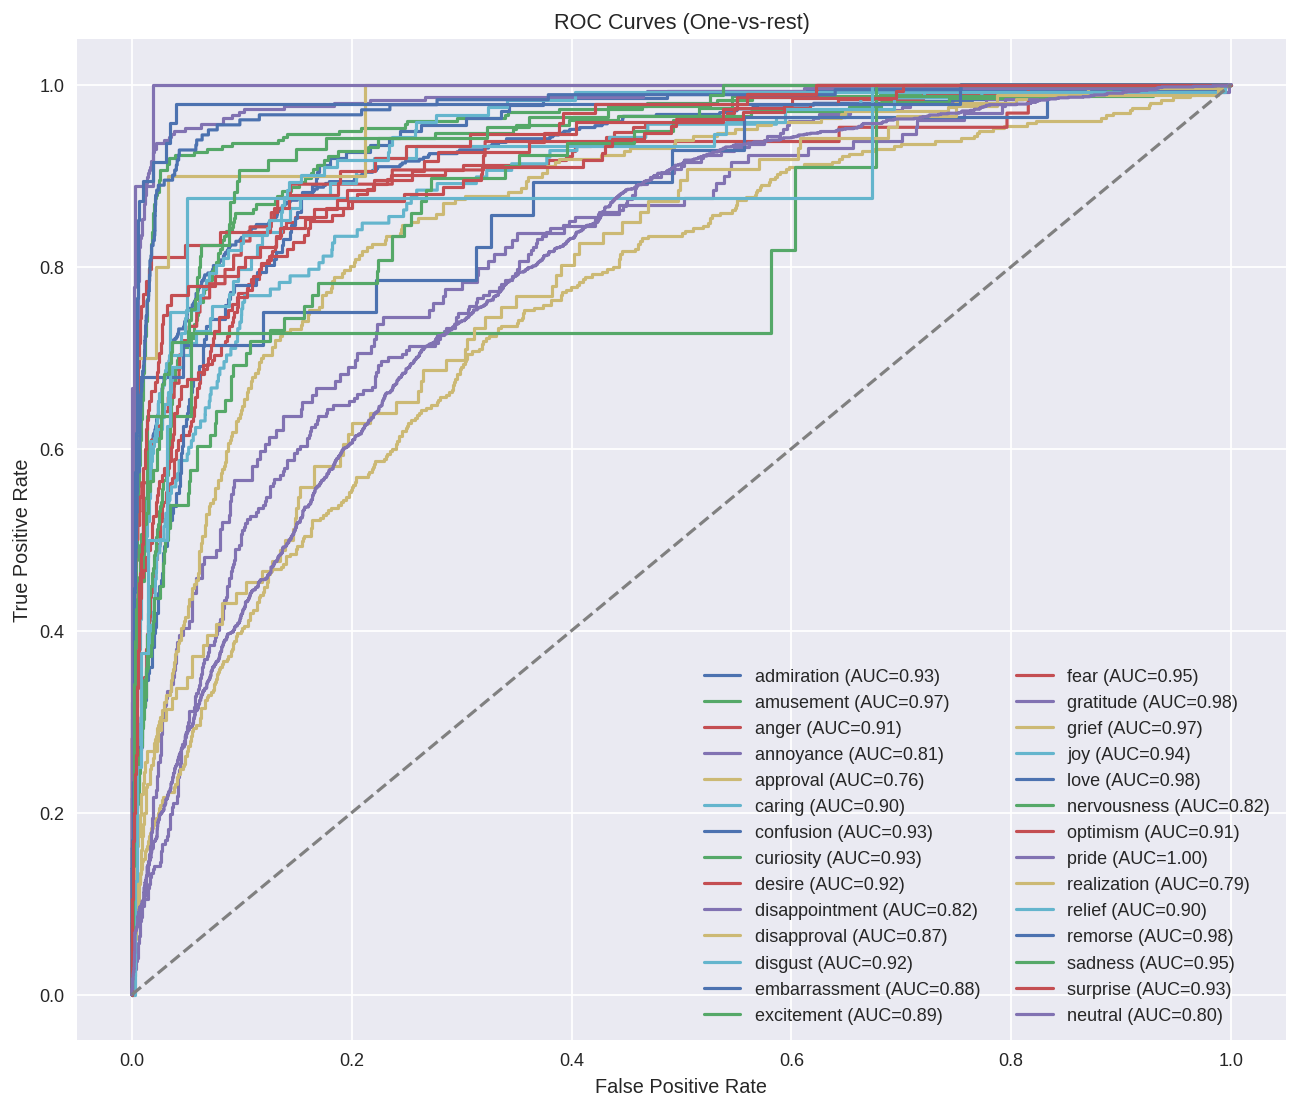

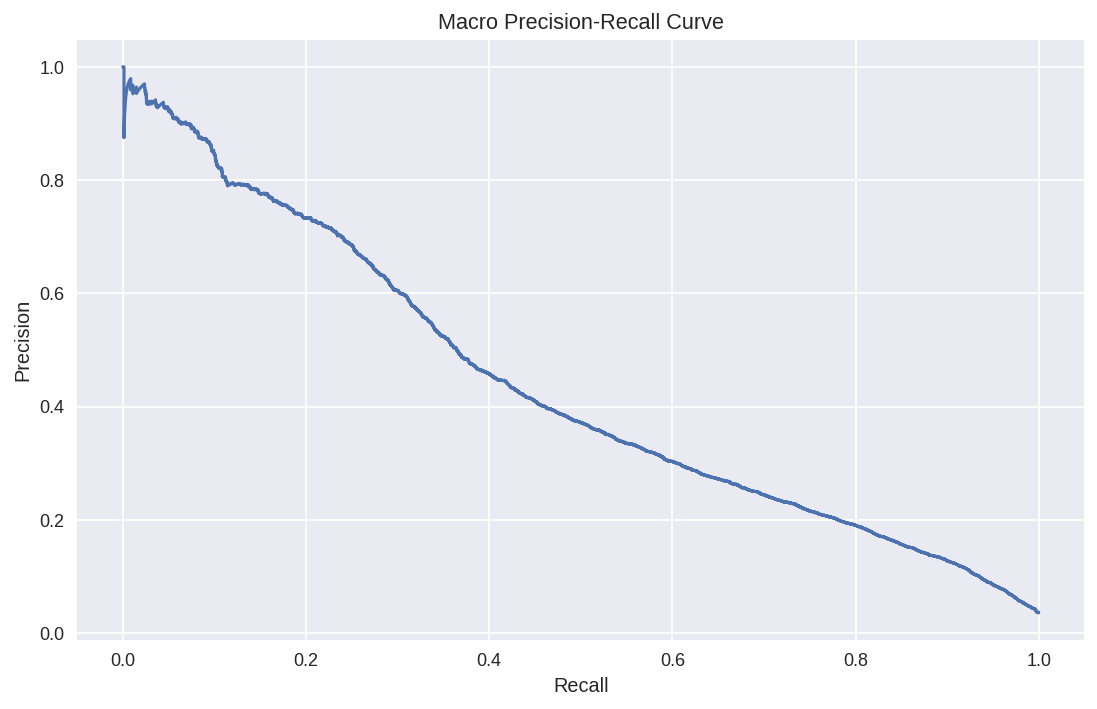



📊 SUPER REPORT COMPLETE.


In [ ]:
# ===============================================================
# SUPER REPORT GENERATOR FOR FINAL MODEL (RAW & SIMPLIFIED)
# ===============================================================
if not SMOKE_TEST:

  import os
  import json
  import numpy as np
  import matplotlib.pyplot as plt
  from sklearn.metrics import (
      confusion_matrix, precision_recall_fscore_support,
      roc_curve, auc, precision_recall_curve
  )
  import seaborn as sns
  import torch
  from transformers import AutoModelForSequenceClassification, AutoTokenizer
  from tqdm import tqdm

  # ===============================================================
  # 1. Locate the final-trained model directory
  # ===============================================================

  base = FINAL_DIR  # same as training
  dirs = [d for d in os.listdir(base) if d.endswith("_final_trained")]
  dirs

  if len(dirs) == 0:
      raise ValueError("No final trained model directory found.")

  model_dir = os.path.join(base, dirs[0])
  print("Using final model directory:", model_dir)

  # find best checkpoint (load_best_model_at_end=True → checkpoint-X)
  ckpts = [d for d in os.listdir(model_dir) if d.startswith("checkpoint")]
  if ckpts:
      best_ckpt = os.path.join(model_dir, sorted(ckpts)[-1])
  else:
      best_ckpt = model_dir

  print("Best checkpoint:", best_ckpt)

  # load summary
  summary_path = os.path.join(model_dir, "training_summary.json")
  with open(summary_path, "r") as f:
      summary = json.load(f)

  mode = summary["mode"]
  print("MODE:", mode)

  # ===============================================================
  # 2. Load tokenizer, model, dataset
  # ===============================================================
  tokenized_ds, tokenizer, label_info = get_tokenized_dataset_cached(
      base_model_name=summary["model_name"],
      mode=mode,
      max_len=summary["best_hpo_config"]["max_length"],
  )

  id2label = label_info["id2label"]
  label2id = label_info["label2id"]
  num_labels = label_info["num_labels"]

  model = AutoModelForSequenceClassification.from_pretrained(best_ckpt)
  model.eval()
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model.to(device)

  is_multilabel = mode == RAW_CONFIG_NAME

  # ===============================================================
  # 3. Collect predictions on validation set  (FIXED VERSION)
  # ===============================================================

  val = tokenized_ds["validation"]

  all_logits = []
  all_labels = []

  for batch in tqdm(val, desc="Eval"):
      inp = {
          "input_ids": torch.tensor(batch["input_ids"]).unsqueeze(0).to(device),
          "attention_mask": torch.tensor(batch["attention_mask"]).unsqueeze(0).to(device),
      }

      labels = np.array(batch["labels"])
      if not is_multilabel:
          labels = int(labels)

      with torch.no_grad():
          logits = model(**inp).logits.cpu().numpy()

      all_logits.append(logits[0])
      all_labels.append(labels)

  all_logits = np.array(all_logits)
  all_labels = np.array(all_labels)


  # ===============================================================
  # 4. Convert logits → probabilities → predictions
  # ===============================================================

  if is_multilabel:
      probs = 1 / (1 + np.exp(-all_logits))
      preds = (probs >= 0.5).astype(int)
  else:
      exp = np.exp(all_logits)
      probs = exp / exp.sum(axis=1, keepdims=True)
      preds = np.argmax(probs, axis=1)

  # ===============================================================
  # 5. Load training curves for visualization
  # ===============================================================

  trainer_state = None
  for ck in ckpts:
      st = os.path.join(model_dir, ck, "trainer_state.json")
      if os.path.exists(st):
          trainer_state = st
          break

  if trainer_state:
      with open(trainer_state, "r") as f:
          state = json.load(f)
      logs = state["log_history"]
  else:
      print("No trainer_state.json found!")
      logs = []

  train_loss = [x["loss"] for x in logs if "loss" in x]
  eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]
  eval_acc  = [x.get("eval_accuracy") for x in logs if "eval_accuracy" in x]
  eval_ps   = [x.get("eval_plutchik_soft") for x in logs if "eval_plutchik_soft" in x]

  # smoothing
  def smooth(x, alpha=0.9):
      if len(x) == 0: return x
      s = [x[0]]
      for v in x[1:]:
          s.append(alpha * s[-1] + (1 - alpha) * v)
      return s

  train_loss_s = smooth(train_loss)
  eval_loss_s  = smooth(eval_loss)

  # ===============================================================
  # 6. VISUALIZATIONS
  # ===============================================================

  fig, axes = plt.subplots(3, 1, figsize=(10, 18))

  # ----- Loss curves -----
  axes[0].plot(train_loss_s, label="Train Loss (smoothed)")
  axes[0].plot(eval_loss_s, label="Eval Loss (smoothed)", color="orange")
  axes[0].set_title("Loss Curves (Smoothed)")
  axes[0].set_xlabel("Step")
  axes[0].legend()

  # ----- Metrics per epoch -----
  axes[1].plot(eval_acc, label="Accuracy")
  axes[1].plot(eval_ps, label="Plutchik Soft", color="orange")
  axes[1].set_title("Evaluation Metrics per Epoch")
  axes[1].set_xlabel("Epoch")
  axes[1].legend()

  # ----- LR schedule -----
  lrs = [x["learning_rate"] for x in logs if "learning_rate" in x]
  axes[2].plot(lrs)
  axes[2].set_title("Learning Rate Schedule")
  axes[2].set_xlabel("Step")
  axes[2].set_ylabel("LR")

  plt.tight_layout()
  plt.show()

  # ===============================================================
  # 7. Confusion Matrix (simplified only)
  # ===============================================================

  if not is_multilabel:
      cm = confusion_matrix(all_labels, preds)
      plt.figure(figsize=(14,12))
      sns.heatmap(cm, annot=False, cmap="Blues")
      plt.title("Confusion Matrix (Simplified)")
      plt.xlabel("Predicted")
      plt.ylabel("True")
      plt.show()

  # ===============================================================
  # 8. Per-class metrics (simplified)
  # ===============================================================

  if not is_multilabel:
      prec, rec, f1, _ = precision_recall_fscore_support(
          all_labels, preds, average=None
      )
      idx = np.arange(num_labels)

      plt.figure(figsize=(14,8))
      plt.bar(idx-0.2, prec, width=0.2, label="Precision")
      plt.bar(idx, rec, width=0.2, label="Recall")
      plt.bar(idx+0.2, f1, width=0.2, label="F1")
      plt.xticks(idx, [id2label[i] for i in idx], rotation=90)
      plt.title("Per-Class Metrics (Simplified)")
      plt.legend()
      plt.tight_layout()
      plt.show()

  # ===============================================================
  # 9. Prediction probability distribution
  # ===============================================================

  plt.figure(figsize=(10,6))
  if is_multilabel:
      flat = probs.flatten()
  else:
      flat = np.max(probs, axis=1)
  plt.hist(flat, bins=30)
  plt.title("Confidence Distribution")
  plt.xlabel("Probability")
  plt.ylabel("Frequency")
  plt.show()

  # ===============================================================
  # 10. ROC + PR CURVES (simplified only)
  # ===============================================================

  if not is_multilabel:
      # one-vs-rest encoding
      y_true = np.zeros((len(all_labels), num_labels))
      for i, lab in enumerate(all_labels):
          y_true[i, lab] = 1

      plt.figure(figsize=(12,10))
      for c in range(num_labels):
          fpr, tpr, _ = roc_curve(y_true[:,c], probs[:,c])
          auc_c = auc(fpr, tpr)
          plt.plot(fpr, tpr, label=f"{id2label[c]} (AUC={auc_c:.2f})")

      plt.plot([0,1],[0,1],"--", color="gray")
      plt.title("ROC Curves (One-vs-rest)")
      plt.xlabel("False Positive Rate")
      plt.ylabel("True Positive Rate")
      plt.legend(ncol=2)
      plt.show()

      # macro PR curve
      precision, recall, _ = precision_recall_curve(y_true.ravel(), probs.ravel())

      plt.figure(figsize=(10,6))
      plt.plot(recall, precision)
      plt.title("Macro Precision-Recall Curve")
      plt.xlabel("Recall")
      plt.ylabel("Precision")
      plt.show()

  # ===============================================================
  # 11. RAW MODE: THRESHOLD SWEEP
  # ===============================================================

  if is_multilabel:
      thresholds = np.linspace(0.1, 0.9, 17)
      f1_scores = []

      for t in thresholds:
          pr = (probs >= t).astype(int)
          _, _, f1, _ = precision_recall_fscore_support(
              all_labels, pr, average="micro", zero_division=0
          )
          f1_scores.append(f1)

      plt.figure(figsize=(10,6))
      plt.plot(thresholds, f1_scores, marker="o")
      best_t = thresholds[np.argmax(f1_scores)]
      best_f = max(f1_scores)
      plt.axvline(best_t, color="r", linestyle="--", label=f"best={best_t:.2f}")
      plt.title("Threshold Sweep (RAW mode)")
      plt.xlabel("Threshold")
      plt.ylabel("Micro F1")
      plt.legend()
      plt.show()

  print("\n\n📊 SUPER REPORT COMPLETE.")


,model_name,model_key,mode,trial_index,metric,learning_rate,warmup_ratio,weight_decay,scheduler,batch_size,max_length,optimizer
0,nreimers/MiniLM-L6-H384-uncased,nreimers_MiniLM-L6-H384-uncased,raw,0,0.381437,0.00001,0.00,0.01,linear,32,128,adamw_torch
1,nreimers/MiniLM-L6-H384-uncased,nreimers_MiniLM-L6-H384-uncased,raw,1,0.457061,0.00002,0.05,0.01,cosine,16,64,adamw_torch
2,nreimers/MiniLM-L6-H384-uncased,nreimers_MiniLM-L6-H384-uncased,raw,2,0.459518,0.00003,0.10,0.00,linear,32,64,adamw_torch


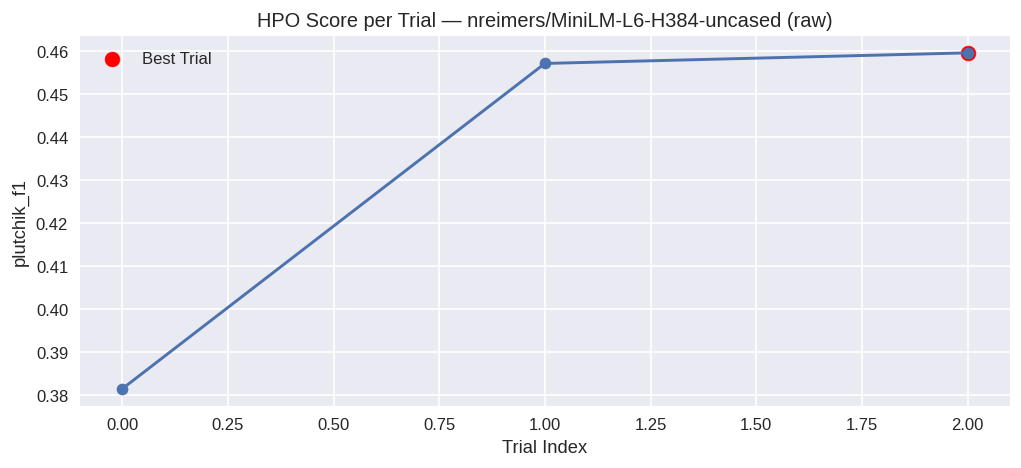


===== PARAMETER EFFECT PLOTS for nreimers/MiniLM-L6-H384-uncased (raw) =====


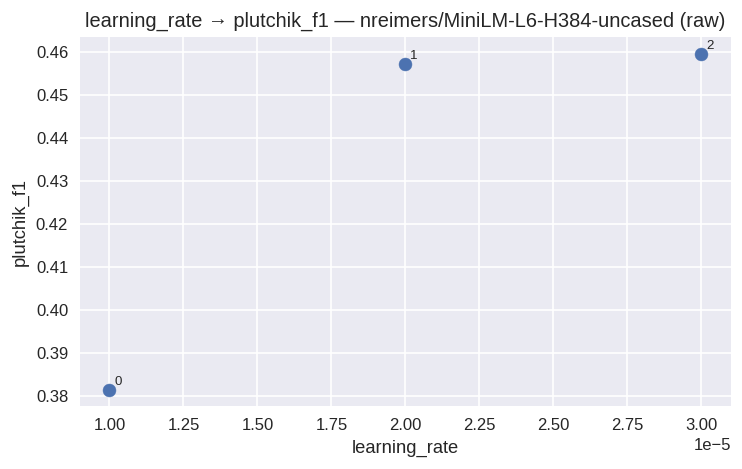

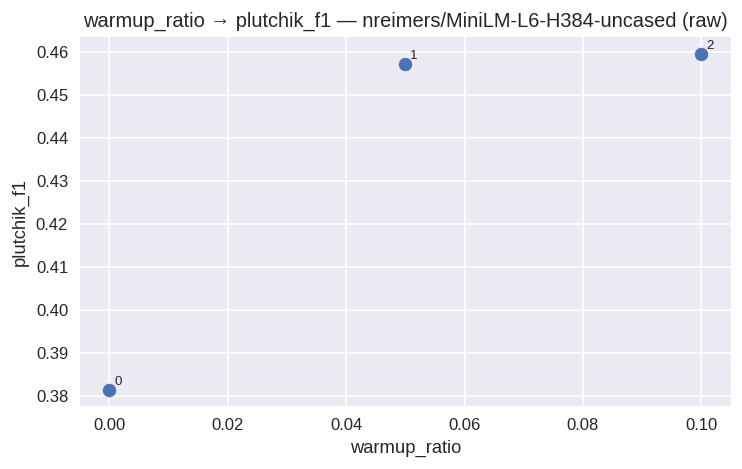

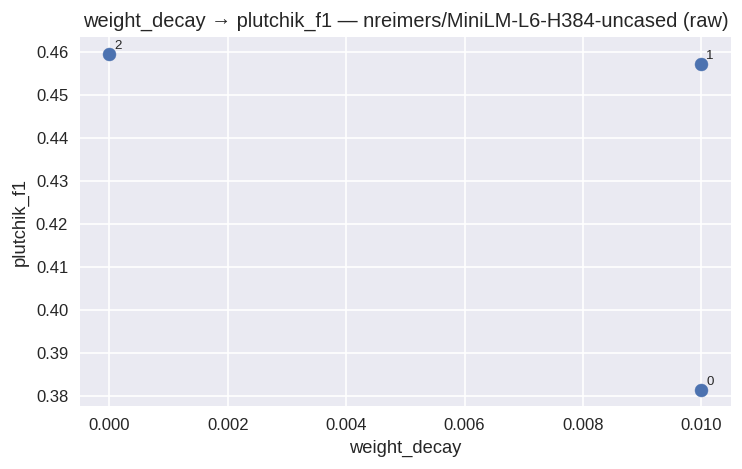

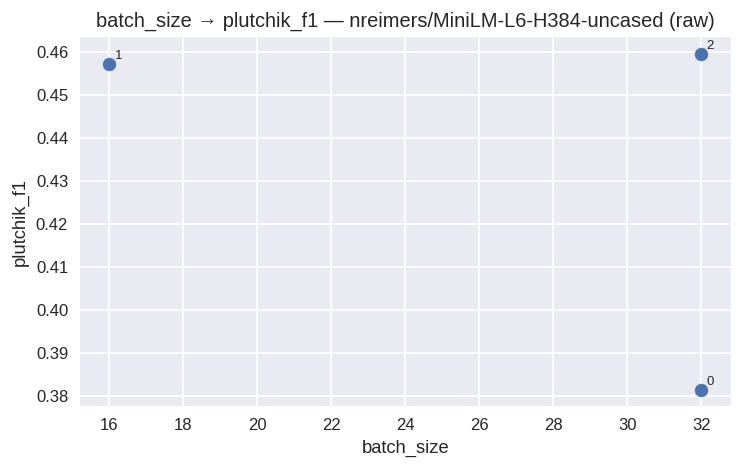

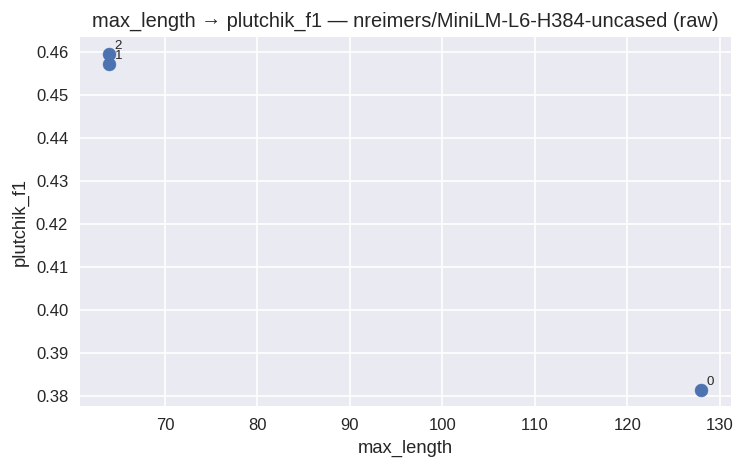

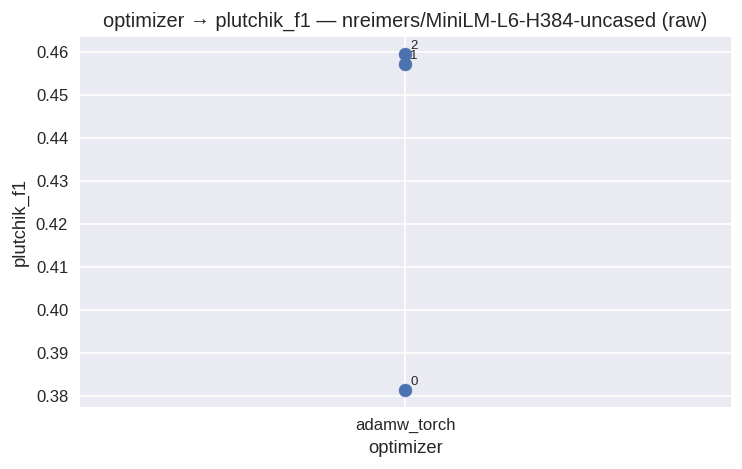

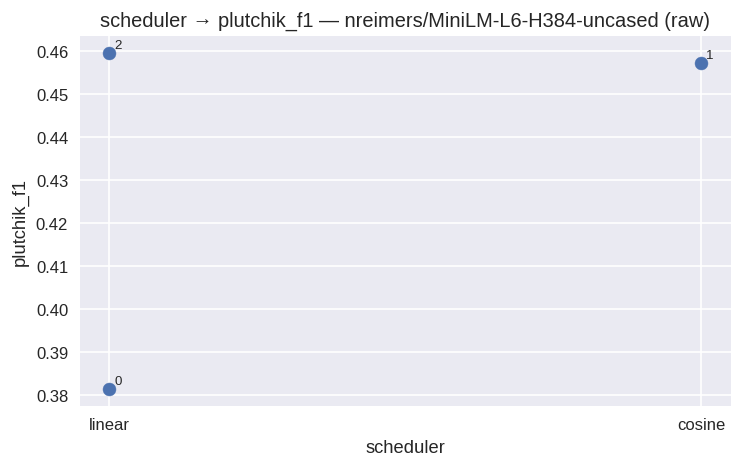

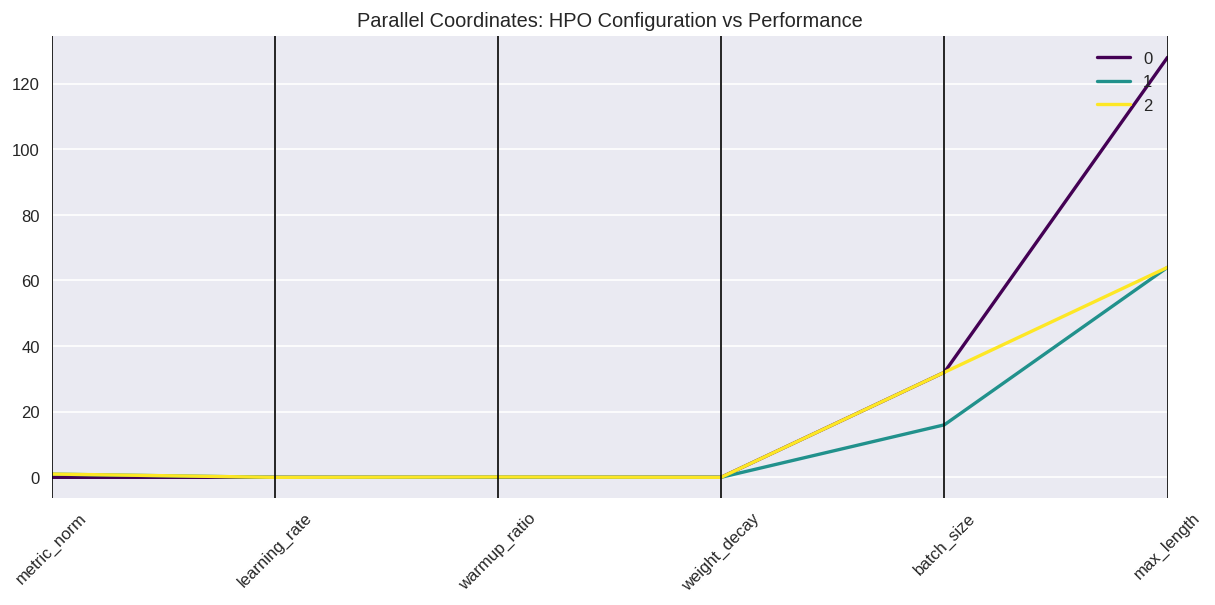

Done.


In [ ]:
# ============================================================
# PROFESSIONAL HPO VISUALIZATION DASHBOARD
# ============================================================
if not SMOKE_TEST:

  import json
  import matplotlib.pyplot as plt
  import pandas as pd
  import seaborn as sns
  from glob import glob

  plt.rcParams['figure.dpi'] = 120
  plt.rcParams['font.size'] = 11

  def load_all_hpo_results():
      rows = []
      for model_cfg in BASE_MODELS:
          model_name = model_cfg["name"]
          key = model_name.replace("/", "_")

          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              trial_dir = os.path.join(TRIALS_DIR, f"{key}_{mode}")
              if not os.path.exists(trial_dir):
                  continue

              for metrics_path in sorted(glob(os.path.join(trial_dir, "trial_*/metrics.json"))):
                  with open(metrics_path, "r") as f:
                      data = json.load(f)

                  metric_name = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"
                  metric_val = (
                      data["eval_metrics"].get(metric_name)
                      or data["eval_metrics"].get(f"eval_{metric_name}")
                  )

                  row = {
                      "model_name": model_name,
                      "model_key": key,
                      "mode": mode,
                      "trial_index": data["trial_index"],
                      "metric": metric_val,
                  }
                  # add HPO params
                  for k, v in data["hpo_config"].items():
                      row[k] = v

                  rows.append(row)

      return pd.DataFrame(rows)


  # Load the complete HPO table
  df_hpo = load_all_hpo_results()
  display(df_hpo)

  if df_hpo.empty:
      print("⚠ No HPO results found.")
  else:
      # ============================================================
      # 1. SCATTER: Trial-by-trial comparison
      # ============================================================
      for (model, mode), df_sub in df_hpo.groupby(["model_name", "mode"]):

          metric_name = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"

          plt.figure(figsize=(10, 4))
          plt.plot(df_sub["trial_index"], df_sub["metric"], "-o")
          best_idx = df_sub["metric"].idxmax()
          best_trial = df_sub.loc[best_idx]

          plt.scatter(best_trial["trial_index"], best_trial["metric"],
                      color="red", s=80, label="Best Trial")
          plt.title(f"HPO Score per Trial — {model} ({mode})")
          plt.xlabel("Trial Index")
          plt.ylabel(metric_name)
          plt.grid(True)
          plt.legend()
          plt.show()

      # ============================================================
      # 2. PARAMETER EFFECT PLOTS
      # ============================================================
      hpo_params = ["learning_rate", "warmup_ratio", "weight_decay", "batch_size",
                    "max_length", "optimizer", "scheduler"]

      for (model, mode), df_sub in df_hpo.groupby(["model_name", "mode"]):

          metric_name = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"
          print(f"\n===== PARAMETER EFFECT PLOTS for {model} ({mode}) =====")

          for param in hpo_params:
              if param not in df_sub.columns:
                  continue

              plt.figure(figsize=(7, 4))
              plt.scatter(df_sub[param], df_sub["metric"], s=60)
              plt.title(f"{param} → {metric_name} — {model} ({mode})")
              plt.xlabel(param)
              plt.ylabel(metric_name)
              plt.grid(True)

              # annotate trial index
              for _, row in df_sub.iterrows():
                  plt.annotate(int(row["trial_index"]),
                              (row[param], row["metric"]),
                              textcoords="offset points", xytext=(3,3), fontsize=8)

              plt.show()

      # ============================================================
      # 3. PARALLEL COORDINATES PLOT (most informative)
      # ============================================================
      from pandas.plotting import parallel_coordinates

      df_norm = df_hpo.copy()
      # normalize metric to [0, 1]
      df_norm["metric_norm"] = (df_norm["metric"] - df_norm["metric"].min()) / (df_norm["metric"].max() - df_norm["metric"].min())

      # only numeric columns for parallel plot
      numeric_cols = ["metric_norm", "learning_rate", "warmup_ratio", "weight_decay", "batch_size", "max_length"]

      df_parallel = df_norm[numeric_cols + ["trial_index"]].copy()
      df_parallel["trial_index"] = df_parallel["trial_index"].astype(str)

      plt.figure(figsize=(12, 5))
      parallel_coordinates(df_parallel, "trial_index", colormap="viridis", linewidth=2)
      plt.title("Parallel Coordinates: HPO Configuration vs Performance")
      plt.xticks(rotation=45)
      plt.grid(True)
      plt.show()

      print("Done.")


,model,mode,trial_index,metric_name,score,learning_rate,warmup_ratio,weight_decay,scheduler,batch_size,max_length,optimizer
0,nreimers/MiniLM-L6-H384-uncased,raw,0,plutchik_f1,0.381437,0.00001,0.00,0.01,linear,32,128,adamw_torch
1,nreimers/MiniLM-L6-H384-uncased,raw,1,plutchik_f1,0.457061,0.00002,0.05,0.01,cosine,16,64,adamw_torch
2,nreimers/MiniLM-L6-H384-uncased,raw,2,plutchik_f1,0.459518,0.00003,0.10,0.00,linear,32,64,adamw_torch


📁 Saved: /content/drive/MyDrive/emotion_project/full/final_models/plots/hpo/hpo_overview_nreimers_MiniLM-L6-H384-uncased_raw.png


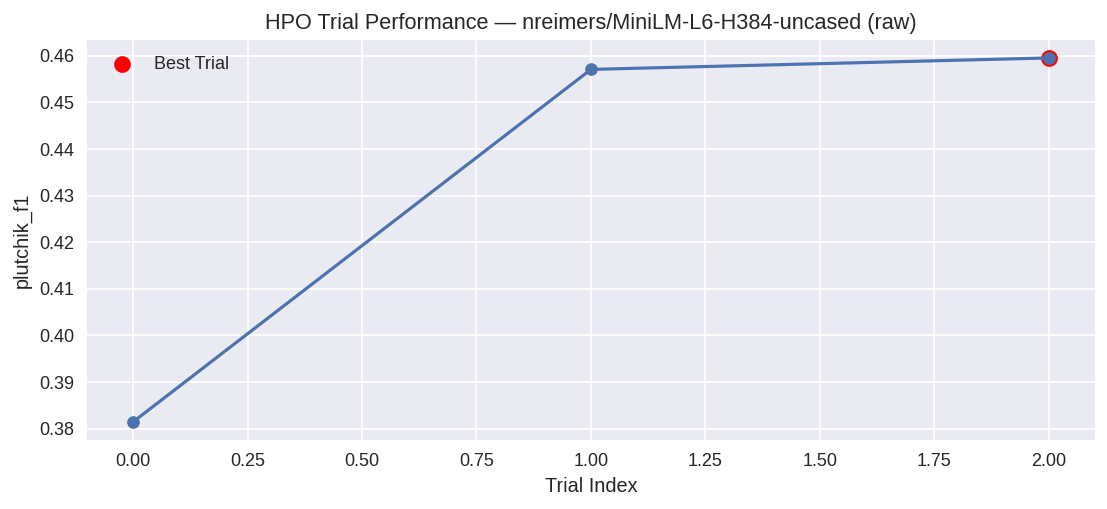


===== PARAMETER IMPACT — nreimers/MiniLM-L6-H384-uncased (raw) =====
📁 Saved: /content/drive/MyDrive/emotion_project/full/final_models/plots/hpo/hpo_param_learning_rate_nreimers_MiniLM-L6-H384-uncased_raw.png


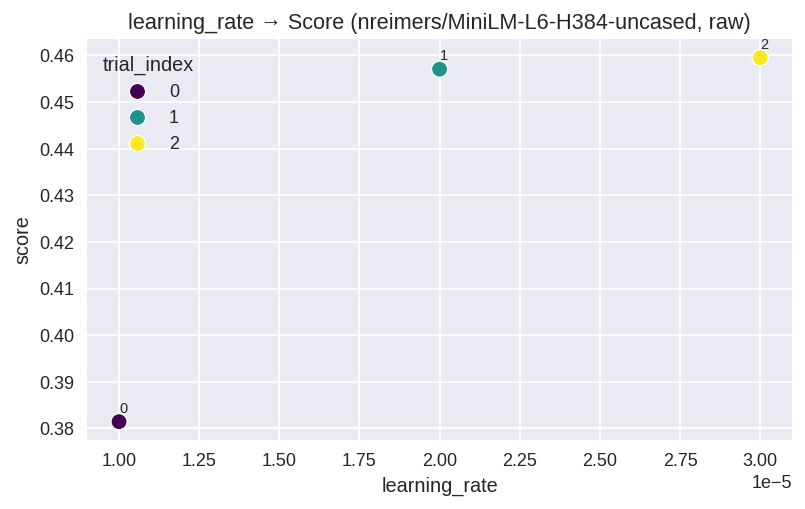

📁 Saved: /content/drive/MyDrive/emotion_project/full/final_models/plots/hpo/hpo_param_warmup_ratio_nreimers_MiniLM-L6-H384-uncased_raw.png


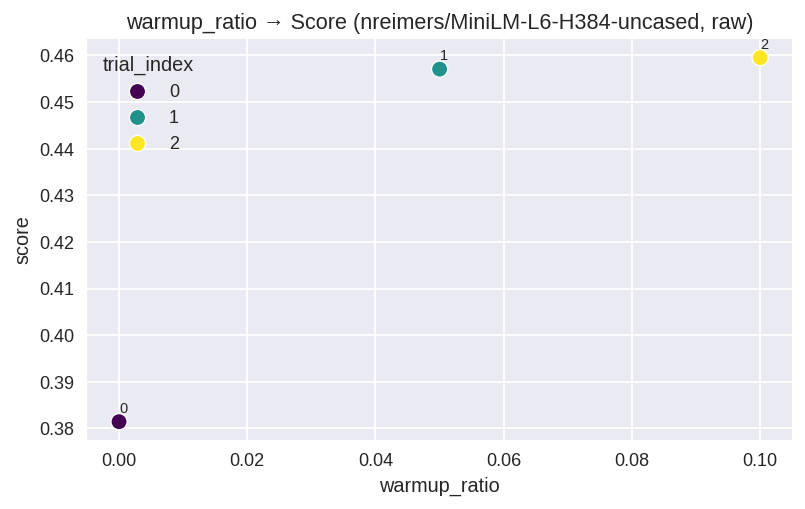

📁 Saved: /content/drive/MyDrive/emotion_project/full/final_models/plots/hpo/hpo_param_weight_decay_nreimers_MiniLM-L6-H384-uncased_raw.png


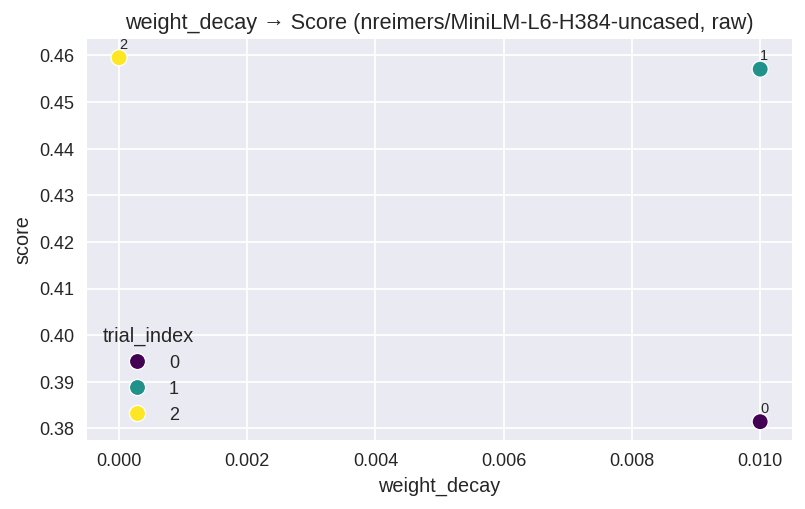

📁 Saved: /content/drive/MyDrive/emotion_project/full/final_models/plots/hpo/hpo_param_batch_size_nreimers_MiniLM-L6-H384-uncased_raw.png


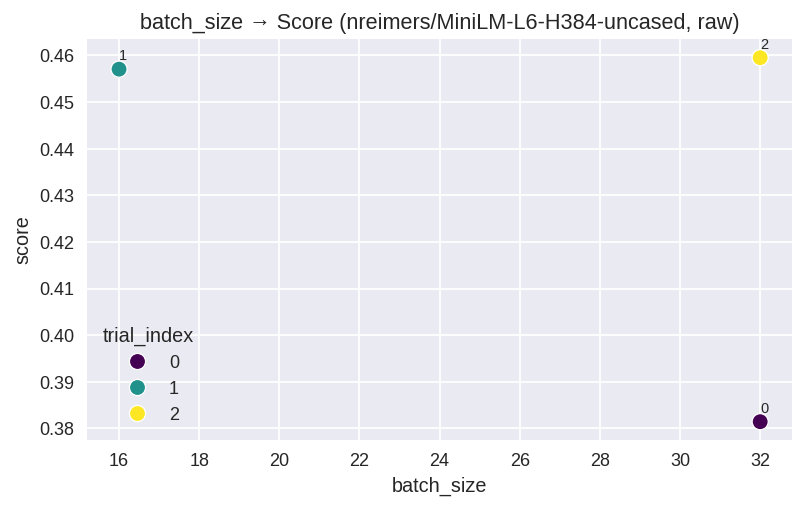

📁 Saved: /content/drive/MyDrive/emotion_project/full/final_models/plots/hpo/hpo_param_max_length_nreimers_MiniLM-L6-H384-uncased_raw.png


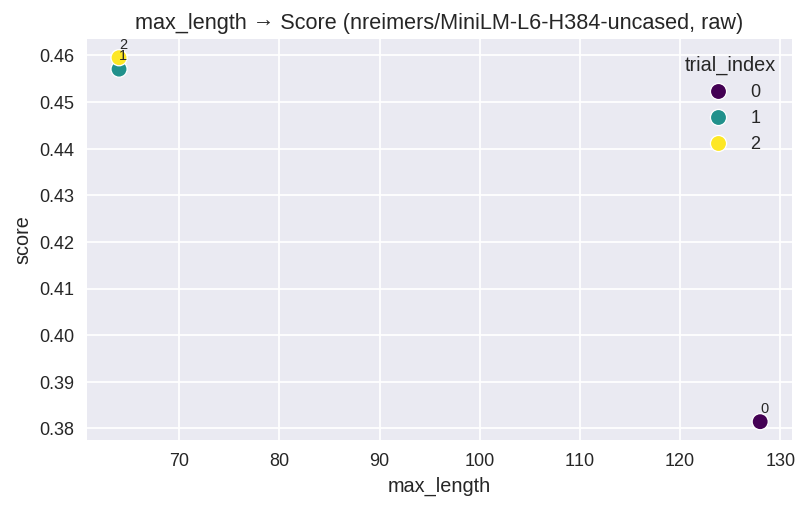

📁 Saved: /content/drive/MyDrive/emotion_project/full/final_models/plots/hpo/hpo_param_optimizer_nreimers_MiniLM-L6-H384-uncased_raw.png


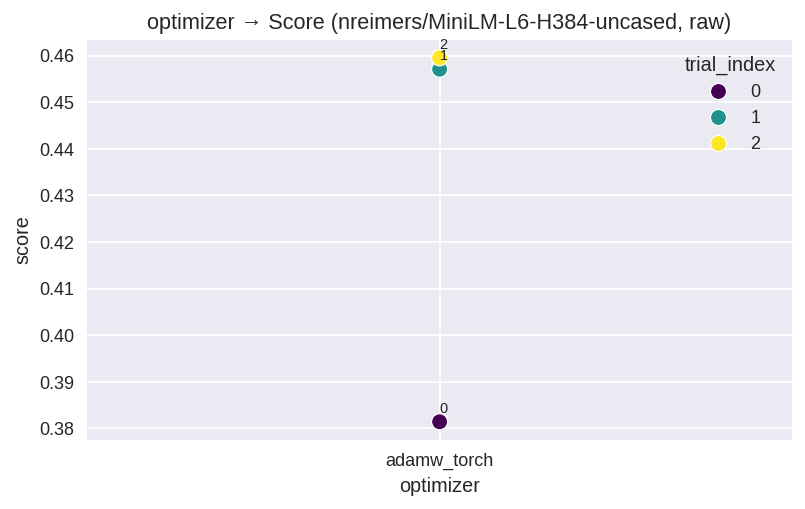

📁 Saved: /content/drive/MyDrive/emotion_project/full/final_models/plots/hpo/hpo_param_scheduler_nreimers_MiniLM-L6-H384-uncased_raw.png


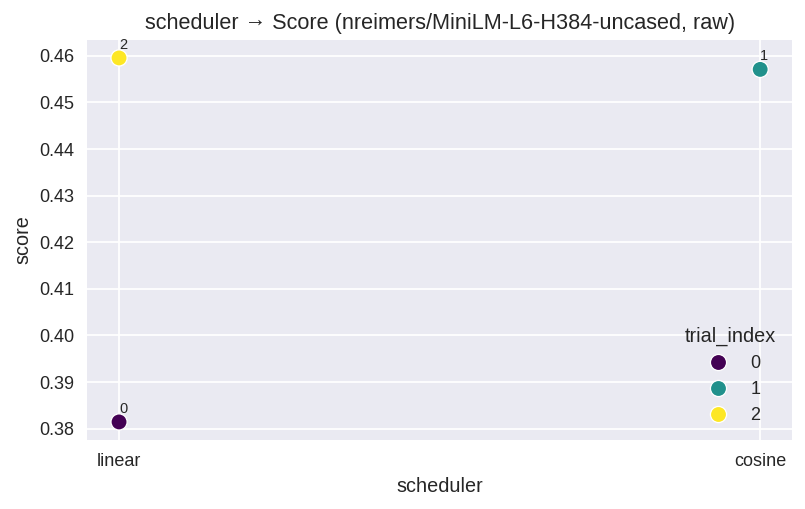

📁 Saved: /content/drive/MyDrive/emotion_project/full/final_models/plots/hpo/hpo_heatmap_learning_rate_warmup_ratio_nreimers_MiniLM-L6-H384-uncased_raw.png


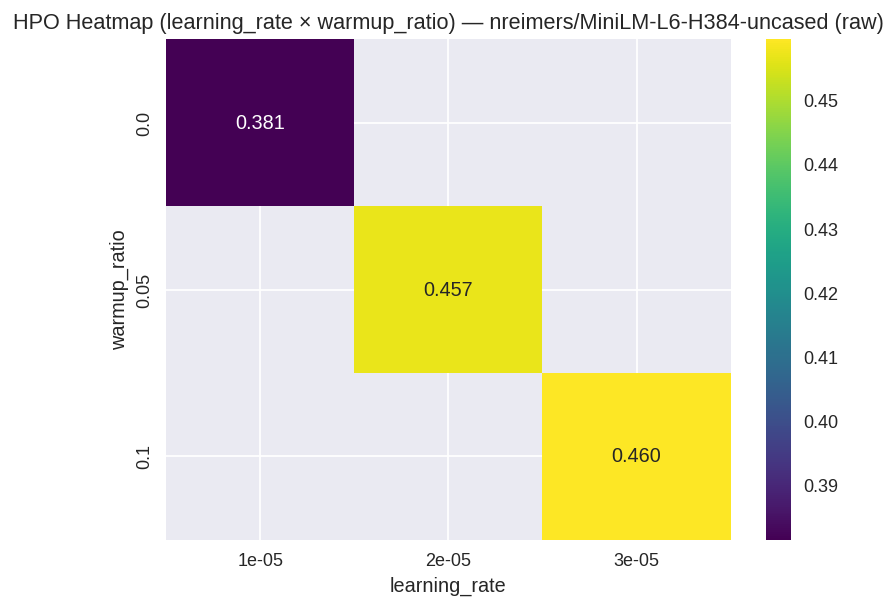

📁 Saved: /content/drive/MyDrive/emotion_project/full/final_models/plots/hpo/hpo_heatmap_batch_size_max_length_nreimers_MiniLM-L6-H384-uncased_raw.png


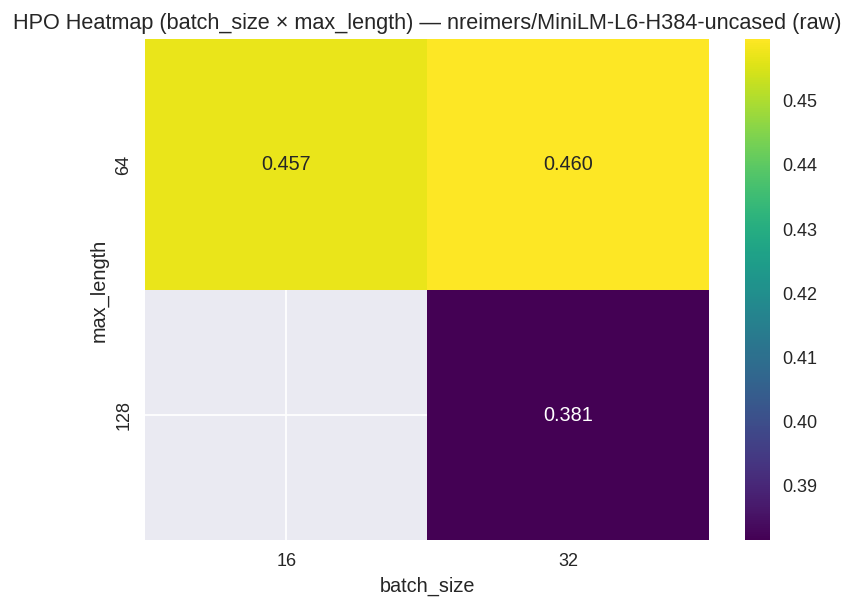

📁 Saved: /content/drive/MyDrive/emotion_project/full/final_models/plots/hpo/hpo_heatmap_optimizer_scheduler_nreimers_MiniLM-L6-H384-uncased_raw.png


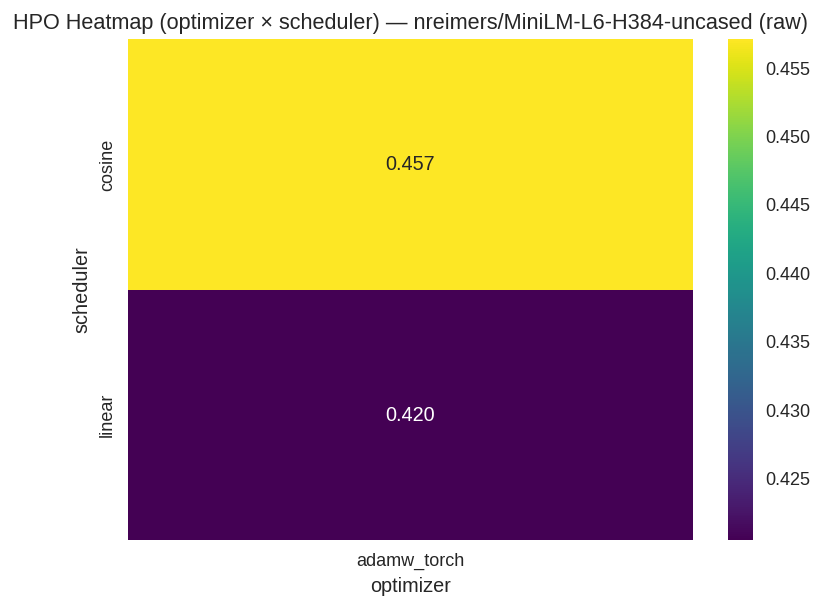

📁 Saved: /content/drive/MyDrive/emotion_project/full/final_models/plots/hpo/hpo_parallel_coordinates.png


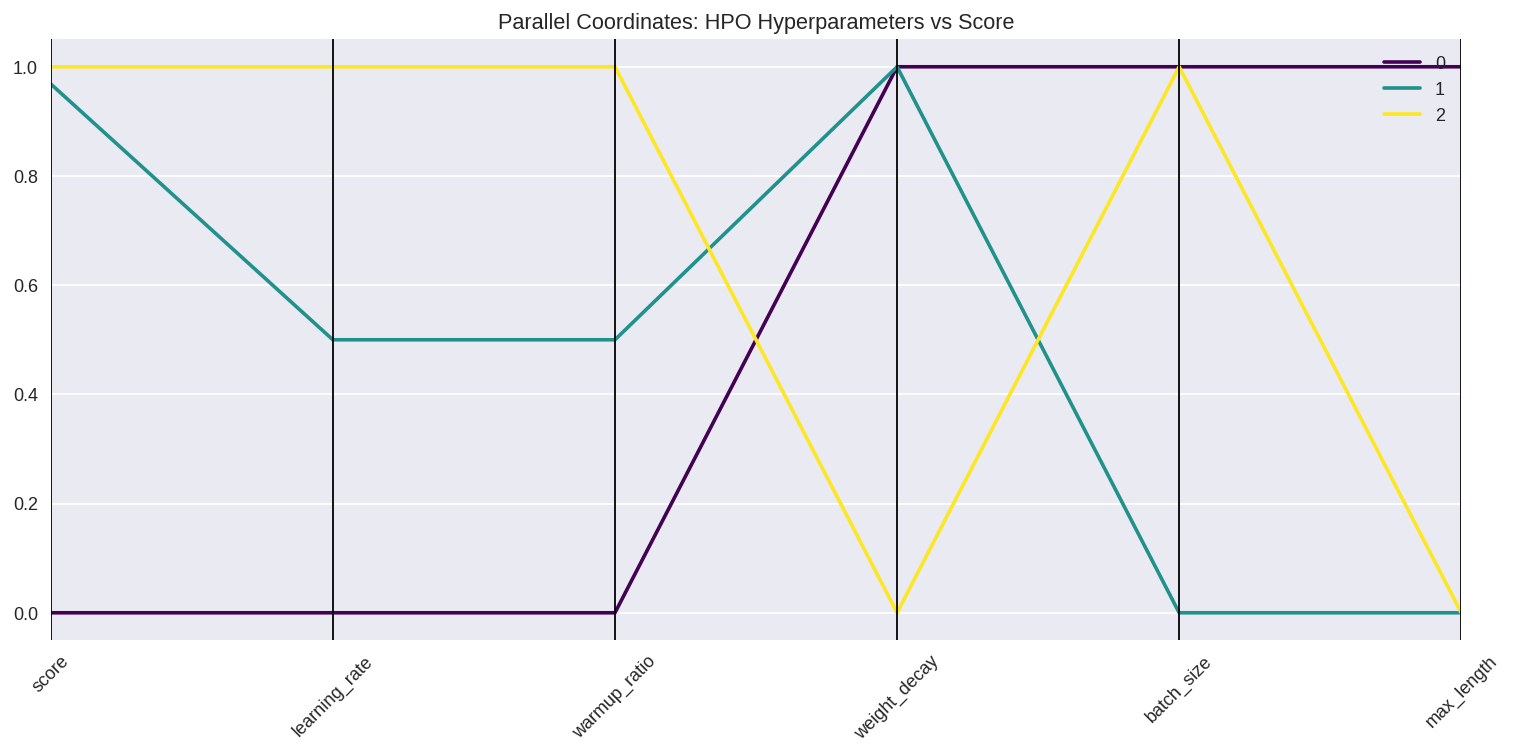


🎉 HPO Visualization Completed.


In [ ]:
# ============================================================
#             📊 PROFESSIONAL HPO VISUALIZATION
#     Multi-panel research-quality analysis for all trials
# ============================================================
if not SMOKE_TEST:

  import json
  import os
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns
  from glob import glob
  from pandas.plotting import parallel_coordinates

  plt.rcParams["figure.dpi"] = 130
  plt.rcParams["font.size"] = 11

  # ------------------------------------------------------------
  # Create output directory
  # ------------------------------------------------------------
  HPO_PLOTS_DIR = os.path.join(FINAL_DIR, "plots", "hpo")
  os.makedirs(HPO_PLOTS_DIR, exist_ok=True)

  def save_plot(name):
      path = os.path.join(HPO_PLOTS_DIR, name)
      plt.savefig(path, dpi=200, bbox_inches="tight")
      print(f"📁 Saved: {path}")

  # ------------------------------------------------------------
  # Helper functions
  # ------------------------------------------------------------

  def try_load_json(path):
      if not os.path.exists(path):
          return None
      with open(path, "r") as f:
          return json.load(f)

  def get_metric(metrics_dict, metric_name):
      if metric_name in metrics_dict:
          return metrics_dict[metric_name]
      if f"eval_{metric_name}" in metrics_dict:
          return metrics_dict[f"eval_{metric_name}"]
      return None

  def load_hpo_table():
      rows = []
      for model_cfg in BASE_MODELS:
          model = model_cfg["name"]
          key = model.replace("/", "_")

          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              trial_root = os.path.join(TRIALS_DIR, f"{key}_{mode}")
              if not os.path.exists(trial_root):
                  continue

              for metrics_path in sorted(glob(os.path.join(trial_root, "trial_*/metrics.json"))):
                  data = try_load_json(metrics_path)
                  if not data:
                      continue

                  hpo_cfg = data["hpo_config"]
                  metric_name = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"
                  score = get_metric(data["eval_metrics"], metric_name)

                  row = {
                      "model": model,
                      "mode": mode,
                      "trial_index": data["trial_index"],
                      "metric_name": metric_name,
                      "score": score,
                  }
                  row.update(hpo_cfg)
                  rows.append(row)
      return pd.DataFrame(rows)

  # ------------------------------------------------------------
  # Load HPO dataframe
  # ------------------------------------------------------------
  df_hpo = load_hpo_table()

  if df_hpo.empty:
      print("⚠ No HPO results found.")
  else:
      display(df_hpo)

  # ------------------------------------------------------------
  # 1) Trial Score Overview
  # ------------------------------------------------------------
  for (model, mode), df_sub in df_hpo.groupby(["model", "mode"]):

      plt.figure(figsize=(10, 4))
      plt.plot(df_sub["trial_index"], df_sub["score"], "-o")
      best = df_sub.loc[df_sub["score"].idxmax()]

      plt.scatter(best["trial_index"], best["score"], color="red", s=80, label="Best Trial")
      plt.title(f"HPO Trial Performance — {model} ({mode})")
      plt.xlabel("Trial Index")
      plt.ylabel(best["metric_name"])
      plt.grid(True)
      plt.legend()

      save_plot(f"hpo_overview_{model.replace('/', '_')}_{mode}.png")
      plt.show()

  # ------------------------------------------------------------
  # 2) Parameter impact analysis (scatter)
  # ------------------------------------------------------------
  PARAMETERS = ["learning_rate", "warmup_ratio", "weight_decay",
                "batch_size", "max_length", "optimizer", "scheduler"]

  for (model, mode), df_sub in df_hpo.groupby(["model", "mode"]):
      print(f"\n===== PARAMETER IMPACT — {model} ({mode}) =====")

      for p in PARAMETERS:
          if p not in df_sub.columns:
              continue

          plt.figure(figsize=(7, 4))
          sns.scatterplot(data=df_sub, x=p, y="score", hue="trial_index", palette="viridis", s=80)
          for _, row in df_sub.iterrows():
              plt.annotate(int(row["trial_index"]),
                          (row[p], row["score"]),
                          textcoords="offset points", xytext=(0,5), fontsize=8)

          plt.title(f"{p} → Score ({model}, {mode})")
          plt.grid(True)
          save_plot(f"hpo_param_{p}_{model.replace('/', '_')}_{mode}.png")
          plt.show()

  # ------------------------------------------------------------
  # 3) Heatmaps for hyperparameter pairs
  # ------------------------------------------------------------
  HEATMAP_PAIRS = [
      ("learning_rate", "warmup_ratio"),
      ("batch_size", "max_length"),
      ("optimizer", "scheduler"),
  ]

  for (model, mode), df_sub in df_hpo.groupby(["model", "mode"]):

      for x, y in HEATMAP_PAIRS:
          if x not in df_sub.columns or y not in df_sub.columns:
              continue

          pivot = df_sub.pivot_table(index=y, columns=x, values="score", aggfunc="mean")
          plt.figure(figsize=(7, 5))
          sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
          plt.title(f"HPO Heatmap ({x} × {y}) — {model} ({mode})")
          plt.xlabel(x)
          plt.ylabel(y)
          save_plot(f"hpo_heatmap_{x}_{y}_{model.replace('/', '_')}_{mode}.png")
          plt.show()

  # ------------------------------------------------------------
  # 4) Parallel Coordinates Plot — research level
  # ------------------------------------------------------------
  df_norm = df_hpo.copy()

  # Determine numeric parameters
  numeric_cols = []
  for p in PARAMETERS:
      if p in df_norm.columns and pd.api.types.is_numeric_dtype(df_norm[p]):
          numeric_cols.append(p)

  # Normalize all numeric columns for parallel plot
  for col in ["score"] + numeric_cols:
      df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min() + 1e-12)

  # Convert trial_index to string (required by parallel_coordinates)
  df_norm["trial_index_str"] = df_norm["trial_index"].astype(str)

  plt.figure(figsize=(14, 6))
  parallel_coordinates(df_norm[["trial_index_str", "score"] + numeric_cols],
                      "trial_index_str", colormap="viridis", linewidth=2)

  plt.title("Parallel Coordinates: HPO Hyperparameters vs Score")
  plt.xticks(rotation=45)
  plt.grid(True)
  save_plot("hpo_parallel_coordinates.png")
  plt.show()

  print("\n🎉 HPO Visualization Completed.")


In [ ]:
def format_hpo_label(row, short=True):
    """
    short=True:  compact label:  T3 lr=3e-5 bs=8
    short=False: long label:     T3 | lr=3e-5 | warm=0.1 | ...
    """

    trial = f"T{int(row['trial_index'])}"

    if short:
        return (
            f"{trial}  "
            f"lr={row['learning_rate']:.0e} "
            f"bs={row['batch_size']} "
            f"len={row['max_length']}"
        )
    else:
        return (
            f"{trial} | "
            f"lr={row['learning_rate']:.0e} | "
            f"warm={row['warmup_ratio']} | "
            f"wd={row['weight_decay']} | "
            f"bs={row['batch_size']} | "
            f"len={row['max_length']} | "
            f"{row['optimizer']} | "
            f"{row['scheduler']}"
        )


📁 Saved: /content/drive/MyDrive/emotion_project/full/final_models/plots/hpo/hpo_overview_annotated_nreimers_MiniLM-L6-H384-uncased_raw.png


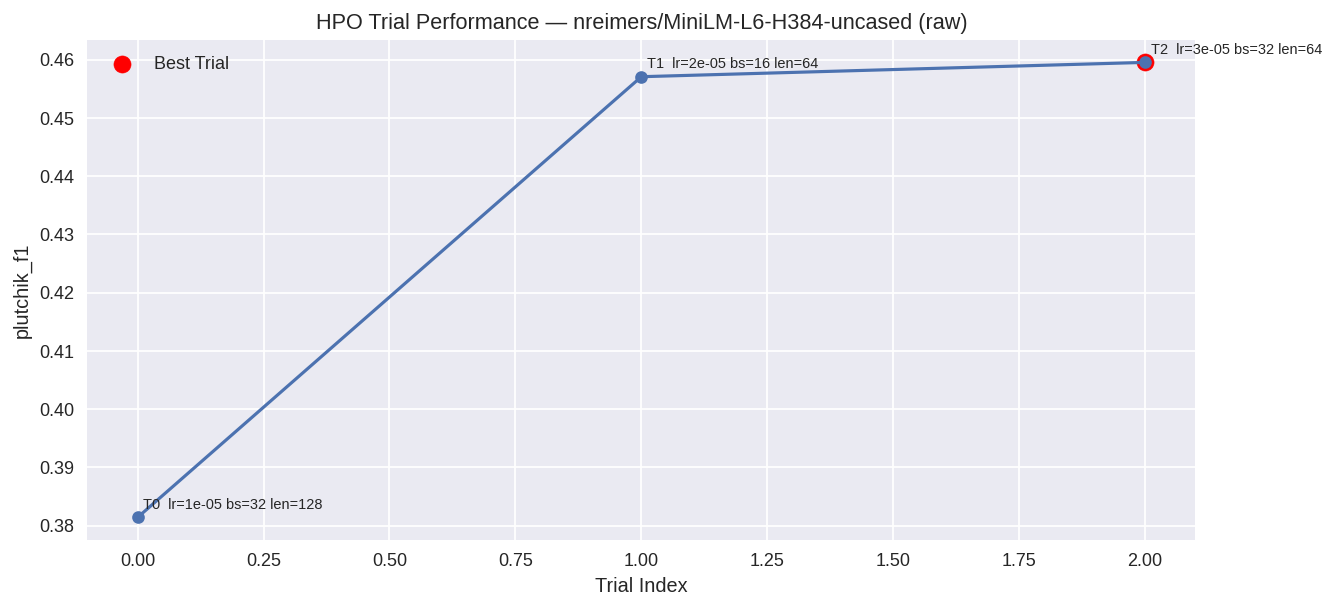

In [ ]:
if not SMOKE_TEST:
  # ------------------------------------------------------------
  # 1) Trial Score Overview — with annotated hyperparameter labels
  # ------------------------------------------------------------
  for (model, mode), df_sub in df_hpo.groupby(["model", "mode"]):

      plt.figure(figsize=(11, 5))
      plt.plot(df_sub["trial_index"], df_sub["score"], "-o", markersize=7)

      best = df_sub.loc[df_sub["score"].idxmax()]

      plt.scatter(best["trial_index"], best["score"], color="red", s=90, label="Best Trial")

      # Annotate every point with compact hyperparameter summary
      for _, row in df_sub.iterrows():
          label = format_hpo_label(row, short=True)
          plt.annotate(label, (row["trial_index"], row["score"]),
                      textcoords="offset points", xytext=(3,5), fontsize=8)

      plt.title(f"HPO Trial Performance — {model} ({mode})")
      plt.xlabel("Trial Index")
      plt.ylabel(row["metric_name"])
      plt.grid(True)
      plt.legend()

      save_plot(f"hpo_overview_annotated_{model.replace('/', '_')}_{mode}.png")
      plt.show()


📁 Saved: /content/drive/MyDrive/emotion_project/full/final_models/plots/hpo/hpo_param_scheduler_annotated_nreimers_MiniLM-L6-H384-uncased_raw.png


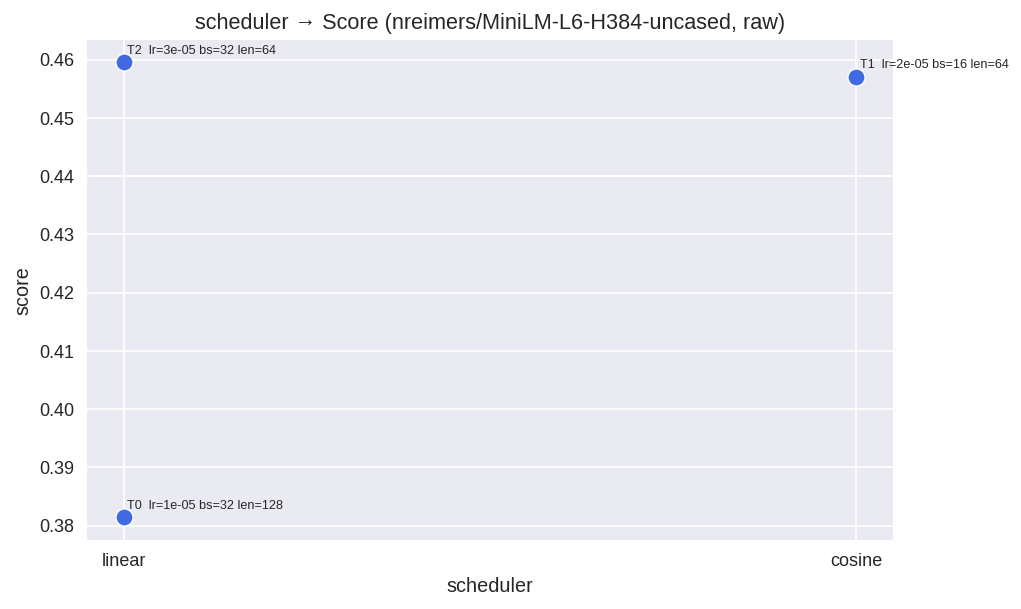

In [ ]:
if not SMOKE_TEST:
  plt.figure(figsize=(8, 5))
  sns.scatterplot(data=df_sub, x=p, y="score", s=90, color="royalblue")

  for _, row in df_sub.iterrows():
      label = format_hpo_label(row, short=True)
      plt.annotate(label,
                  (row[p], row["score"]),
                  textcoords="offset points",
                  xytext=(2, 5),
                  fontsize=7)

  plt.title(f"{p} → Score ({model}, {mode})")
  plt.grid(True)
  save_plot(f"hpo_param_{p}_annotated_{model.replace('/', '_')}_{mode}.png")
  plt.show()


In [ ]:
# ============================================================
#      📊 INTERACTIVE HPO DASHBOARD (PLOTLY VERSION)
# ============================================================
if not SMOKE_TEST:

  import json
  import os
  import pandas as pd
  from glob import glob
  import plotly.express as px

  # ------------------------------------------------------------
  # Helper functions
  # ------------------------------------------------------------

  def try_load_json(path):
      if not os.path.exists(path):
          return None
      with open(path, "r") as f:
          return json.load(f)

  def get_metric(metrics_dict, metric_name):
      if metric_name in metrics_dict:
          return metrics_dict[metric_name]
      eval_key = f"eval_{metric_name}"
      if eval_key in metrics_dict:
          return metrics_dict[eval_key]
      return None

  def load_hpo_table():
      rows = []
      for model_cfg in BASE_MODELS:
          model = model_cfg["name"]
          key = model.replace("/", "_")

          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              trial_root = os.path.join(TRIALS_DIR, f"{key}_{mode}")
              if not os.path.exists(trial_root):
                  continue

              for mpath in sorted(glob(os.path.join(trial_root, "trial_*/metrics.json"))):
                  data = try_load_json(mpath)
                  if not data:
                      continue

                  metric_name = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"
                  score = get_metric(data["eval_metrics"], metric_name)

                  row = {
                      "model": model,
                      "mode": mode,
                      "trial_index": data["trial_index"],
                      "metric": score,
                  }
                  for k, v in data["hpo_config"].items():
                      row[k] = v

                  rows.append(row)
      return pd.DataFrame(rows)


  # ------------------------------------------------------------
  # Load all HPO results
  # ------------------------------------------------------------
  df_hpo = load_hpo_table()
  display(df_hpo)

  if df_hpo.empty:
      print("⚠ No HPO results found.")
  else:
      print("✔ Loaded HPO results.")


  # ============================================================
  # 1) INTERACTIVE: Trial index → Score
  # ============================================================

  for (model, mode), df_sub in df_hpo.groupby(["model", "mode"]):

      title = f"HPO Score per Trial — {model} ({mode})"

      fig = px.scatter(
          df_sub,
          x="trial_index",
          y="metric",
          color="learning_rate",
          size="batch_size",
          hover_data=[
              "trial_index", "metric",
              "learning_rate", "warmup_ratio", "weight_decay",
              "batch_size", "max_length",
              "optimizer", "scheduler"
          ],
          title=title,
          labels={"metric": "Score"},
      )

      fig.update_traces(mode="markers+lines")

      fig.show()


  # ============================================================
  # 2) INTERACTIVE: Hyperparameter → Score plots
  # ============================================================

  PARAMS = ["learning_rate", "warmup_ratio", "weight_decay",
            "batch_size", "max_length", "optimizer", "scheduler"]

  for (model, mode), df_sub in df_hpo.groupby(["model", "mode"]):
      for p in PARAMS:
          if p not in df_sub.columns:
              continue

          title = f"{p} vs Score — {model} ({mode})"

          fig = px.scatter(
              df_sub,
              x=p,
              y="metric",
              color="trial_index",
              hover_data=[
                  "trial_index", "metric",
                  "learning_rate", "warmup_ratio", "weight_decay",
                  "batch_size", "max_length",
                  "optimizer", "scheduler"
              ],
              title=title,
          )

          fig.update_traces(marker=dict(size=10))
          fig.show()


  # ============================================================
  # 3) INTERACTIVE Parallel Coordinates (best for research)
  # ============================================================

  df_pc = df_hpo.copy()

  # normalize numeric columns
  numeric_cols = ["metric", "learning_rate", "warmup_ratio",
                  "weight_decay", "batch_size", "max_length"]

  for col in numeric_cols:
      df_pc[col] = (df_pc[col] - df_pc[col].min()) / (df_pc[col].max() - df_pc[col].min() + 1e-12)

  fig = px.parallel_coordinates(
      df_pc,
      dimensions=numeric_cols,
      color="metric",
      color_continuous_scale=px.colors.sequential.Viridis,
      labels={col: col for col in numeric_cols},
      title="Parallel Coordinate Analysis of HPO Space"
  )

  fig.show()

  print("🎉 Interactive HPO Dashboard Ready.")


,model,mode,trial_index,metric,learning_rate,warmup_ratio,weight_decay,scheduler,batch_size,max_length,optimizer
0,nreimers/MiniLM-L6-H384-uncased,raw,0,0.381437,0.00001,0.00,0.01,linear,32,128,adamw_torch
1,nreimers/MiniLM-L6-H384-uncased,raw,1,0.457061,0.00002,0.05,0.01,cosine,16,64,adamw_torch
2,nreimers/MiniLM-L6-H384-uncased,raw,2,0.459518,0.00003,0.10,0.00,linear,32,64,adamw_torch


✔ Loaded HPO results.


🎉 Interactive HPO Dashboard Ready.


In [ ]:
if EXPORT_FOR_GIT:
  import os
  import shutil
  import json
  from pathlib import Path

  # ==========================================
  # CONFIG — hálózati mappa, ahonnan exportálunk
  # ==========================================
  PROJECT_ROOT = "/content/drive/MyDrive/emotion_project/full"
  FINAL_MODELS = f"{PROJECT_ROOT}/final_models"
  PLOTS_DIR = f"{FINAL_MODELS}/plots"

  EXPORT_DIR = "/content/emotion_project_github_export"
  shutil.rmtree(EXPORT_DIR, ignore_errors=True)
  os.makedirs(EXPORT_DIR, exist_ok=True)

  print("📁 Export directory created:", EXPORT_DIR)


  # ============================================================
  # 1) NOTEBOOKOK exportálása
  # ============================================================
  def export_notebooks():
      nb_dir = "/content"
      export_nb_dir = f"{EXPORT_DIR}/notebooks"
      os.makedirs(export_nb_dir, exist_ok=True)

      for nb in os.listdir(nb_dir):
          if nb.endswith(".ipynb"):
              shutil.copy(f"{nb_dir}/{nb}", f"{export_nb_dir}/{nb}")
              print("✔ Notebook exported:", nb)


  # ============================================================
  # 2) CONFIG fájlok exportálása
  # ============================================================
  def export_configs():
      config_dir = f"{EXPORT_DIR}/configs"
      os.makedirs(config_dir, exist_ok=True)

      possible_configs = [
          "hpo_grid.json",
          "base_models.json",
          "label_info_raw.json",
          "label_info_simplified.json",
      ]

      for conf in possible_configs:
          full_path = f"{PROJECT_ROOT}/{conf}"
          if os.path.exists(full_path):
              shutil.copy(full_path, config_dir)
              print("✔ Config exported:", conf)


  # ============================================================
  # 3) SUMMARY fájlok exportja (kicsik, fontosak)
  # ============================================================
  def export_summaries():
      summary_dir = f"{EXPORT_DIR}/results"
      os.makedirs(summary_dir, exist_ok=True)

      for root, dirs, files in os.walk(FINAL_MODELS):
          for file in files:
              if file in ["training_summary.json", "quantization_summary.json"]:
                  src = os.path.join(root, file)

                  # output struktúra: results/<model>/<file>.json
                  rel = root.replace(FINAL_MODELS, "").strip("/")
                  tgt_dir = os.path.join(summary_dir, rel)
                  os.makedirs(tgt_dir, exist_ok=True)

                  shutil.copy(src, f"{tgt_dir}/{file}")
                  print("✔ Summary exported:", src)


  # ============================================================
  # 4) PLOTOK exportálása
  # ============================================================
  def export_plots():
      if not os.path.exists(PLOTS_DIR):
          print("⚠ No plots directory found:", PLOTS_DIR)
          return

      plot_export = f"{EXPORT_DIR}/results/plots"
      shutil.copytree(PLOTS_DIR, plot_export)
      print("✔ Plot directory exported")


  # ============================================================
  # 5) .gitignore generálás
  # ============================================================
  def export_gitignore():
      gitignore_path = f"{EXPORT_DIR}/.gitignore"
      gitignore_content = """
  # Model checkpoints (too large for GitHub)
  **/checkpoint-*/
  **/*.bin
  **/*.safetensors
  **/optimizer.pt
  **/scheduler.pt
  **/rng_state.pth
  **/training_args.bin

  # Tokenized dataset
  tokenized/
  **/*.arrow

  # HuggingFace cache
  ~/.cache/huggingface

  # Python cache
  __pycache__/
  *.pyc

  # Colab
  *.ipynb_checkpoints/
      """.strip()

      with open(gitignore_path, "w") as f:
          f.write(gitignore_content)
      print("✔ .gitignore created")


  # ============================================================
  # 6) README generálás
  # ============================================================
  def export_readme():
      readme_path = f"{EXPORT_DIR}/README.md"
      readme = """
  # Emotion Classification Project — GitHub Export

  This export contains only the *lightweight, GitHub-safe* files:
  - training summaries
  - quantization summaries
  - HPO results and plots
  - all configs (HPO grid, label mappings)
  - notebooks

  Model weights and checkpoints are intentionally excluded.

  To fully reproduce the project, place your model directories into:

  final_models/<model_name>/

  And run the provided notebooks.

  ---
  Generated automatically by the GitHub export tool.
      """.strip()

      with open(readme_path, "w") as f:
          f.write(readme)

      print("✔ README.md created")


  # ============================================================
  # 7) ZIP készítése
  # ============================================================
  def create_zip():
      zip_path = "/content/emotion_project_github_export.zip"
      shutil.make_archive("/content/emotion_project_github_export", "zip", EXPORT_DIR)
      print("\n📦 ZIP GENERATED:", zip_path)
      return zip_path


  # =========================
  # RUN ALL EXPORT STEPS
  # =========================
  export_notebooks()
  export_configs()
  export_summaries()
  export_plots()
  export_gitignore()
  export_readme()

  zip_path = create_zip()

  zip_path


📁 Export directory created: /content/emotion_project_github_export
✔ Summary exported: /content/drive/MyDrive/emotion_project/full/final_models/nreimers_MiniLM-L6-H384-uncased_simplified_final_trained/training_summary.json
✔ Summary exported: /content/drive/MyDrive/emotion_project/full/final_models/nreimers_MiniLM-L6-H384-uncased_simplified_quantized_final/quantization_summary.json
✔ Summary exported: /content/drive/MyDrive/emotion_project/full/final_models/nreimers_MiniLM-L6-H384-uncased_raw_final_trained/training_summary.json
✔ Summary exported: /content/drive/MyDrive/emotion_project/full/final_models/nreimers_MiniLM-L6-H384-uncased_raw_quantized_final/quantization_summary.json
✔ Plot directory exported
✔ .gitignore created
✔ README.md created

📦 ZIP GENERATED: /content/emotion_project_github_export.zip
